This code utilizes the CSV dataset files containing data from 2012 to 2022 on median house value, median household income, and racial demographics for all census tracts in the New Jersey Mercer County area.

This data is used to predict future house value, creating an LSTM model with various combinations of features and sequence lengths in order to determine the most effective model. K-fold cross validation is used to more accurately determine error scores.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir = "/path/to/your/data/" # Replace with actual file directory and name

# Functions

In [ ]:
def reshape_wide_to_long(df, field_name, years):
    """
    Reshape the DataFrame from wide to long format and add a 'Year' column.

    Parameters:
    - df: The DataFrame containing census data in wide format.
    - field_names: List of field names to reshape.
    - years: The years for which data is available.

    Returns:
    - data_long: The DataFrame in long format.
    """

    # Melt DataFrame to long format
    data_long = pd.melt(
        df,
        id_vars=['Census_Tract'],
        value_vars=[f'{field_name}_{year}' for year in years],
        var_name='Year',
        value_name=field_name
    )

    # Extract the year from the variable name
    data_long['Year'] = data_long['Year'].str.extract(r'(\d{4})').astype(int)

    return data_long





def reshape_wide_to_long_multiple_fields(df, field_names, years):
    """
    Reshape the DataFrame from wide to long format with separate columns for each field.

    Parameters:
    - df: The DataFrame containing census data in wide format.
    - field_names: List of field names to reshape.
    - years: The years for which data is available.

    Returns:
    - data_long: The DataFrame in long format with one row per Census_Tract-Year,
                 and each field as a separate column.
    """

    # Create a list to hold dataframes for each field reshaped to long format
    long_dfs = []

    for field in field_names:
        # Melt for this field
        temp_long = pd.melt(
            df,
            id_vars=['Census_Tract'],
            value_vars=[f"{field}_{year}" for year in years],
            var_name="Year",
            value_name=field
        )
        # Extract year number as int
        temp_long["Year"] = temp_long["Year"].str.extract(r'(\d{4})').astype(int)
        long_dfs.append(temp_long)

    # Merge all long dfs on Census_Tract and Year
    from functools import reduce
    data_long = reduce(
        lambda left, right: pd.merge(left, right, on=['Census_Tract', 'Year'], how='outer'),
        long_dfs
    )

    return data_long

In [ ]:
def fill_missing_values(df, column_name):
    """
    Fills missing values in a specified column using linear interpolation,
    forward fill (ffill), and backward fill (bfill).

    Parameters:
    - df: The input DataFrame.
    - column_name: The name of the column to process.

    Returns:
    - df: The DataFrame with missing values filled.
    """
    # Replace -666666666 with NaN
    df[column_name] = df[column_name].replace(-666666666, np.nan)

    # Sort by Census Tract and Year to maintain proper order
    df.sort_values(by=['Census_Tract', 'Year'], inplace=True)

    # Group by Census Tract and fill missing values using interpolation, ffill, and bfill
    df[column_name] = df.groupby('Census_Tract')[column_name].transform(lambda group: group.interpolate(method='linear').ffill().bfill())

    return df




import numpy as np

def fill_missing_values_multiple_fields(df, column_names):
    """
    Fills missing values in specified columns using linear interpolation,
    forward fill (ffill), and backward fill (bfill).

    Parameters:
    - df: The input DataFrame.
    - column_names: List of column names to process.

    Returns:
    - df: The DataFrame with missing values filled for specified columns.
    """
    # Sort by Census_Tract and Year once
    df.sort_values(by=['Census_Tract', 'Year'], inplace=True)

    for column_name in column_names:
        # Replace -666666666 with NaN
        df[column_name] = df[column_name].replace(-666666666, np.nan)

        # Group by Census_Tract and fill missing values
        df[column_name] = (
            df.groupby('Census_Tract')[column_name]
            .transform(lambda group: group.interpolate(method='linear').ffill().bfill())
        )

    return df


In [ ]:
# this scales each tract individually, probably not good!

# def scale_by_census_tract(df, column_to_scale, new_column_name):
#     """
#     Scales a column in a DataFrame by Census Tract using MinMaxScaler.

#     Parameters:
#     - df: The DataFrame containing the census data.
#     - column_to_scale: The name of the column to scale.
#     - new_column_name: The name of the new column to store scaled values.

#     Returns:
#     - df: The DataFrame with the scaled column added.
#     - scalers: Dictionary of the scalers used for each Census Tract.
#     """

#     df[new_column_name] = 0  # Placeholder for scaled values
#     scalers = {}

#     for tract_id in df['Census_Tract'].unique():
#         scaler = MinMaxScaler(feature_range=(0, 1))
#         tract_data = df[df['Census_Tract'] == tract_id][column_to_scale].fillna(0).values.reshape(-1, 1)
#         scaled_data = scaler.fit_transform(tract_data)
#         df.loc[df['Census_Tract'] == tract_id, new_column_name] = np.nan_to_num(scaled_data.flatten(), nan=0.0)
#         scalers[tract_id] = scaler  # Store scaler for potential inverse transformation

#     return df, scalers

In [ ]:
import numpy as np

def log_transform_column(df, column_to_transform, new_column_name):
    """
    Applies a global log(1 + x) transform to a specified column.

    Parameters:
    - df: The DataFrame containing the census data.
    - column_to_transform: The name of the column to transform.
    - new_column_name: The name of the new column to store log-transformed values.

    Returns:
    - df: The DataFrame with the log-transformed column added.
    """
    # Replace missing or invalid values with 0 before log transform if needed
    df[column_to_transform] = df[column_to_transform].fillna(0)

    # Apply log(1 + x) transform globally
    df[new_column_name] = np.log1p(df[column_to_transform])

    # Optionally, drop the original column if you want to replace it completely:
    if new_column_name != column_to_transform:
        df.drop(columns=[column_to_transform], inplace=True)

    return df


import numpy as np

def log_transform_columns(df, columns_to_transform, drop_original=True, prefix="Log_"):
    """
    Applies a global log(1 + x) transform to a list of specified columns.

    Parameters:
    - df: The DataFrame containing the data.
    - columns_to_transform: A list of column names to transform.
    - drop_original: Whether to drop the original columns after transformation. Default is True.
    - suffix: Suffix to append to the new log-transformed columns.

    Returns:
    - df: The DataFrame with log-transformed columns added (or replaced).
    """
    for column in columns_to_transform:
        # Fill NaNs with 0 before applying log1p
        df[column] = df[column].fillna(0)

        # Create the new column name
        new_column_name = prefix + column

        # Apply log1p transformation
        df[new_column_name] = np.log1p(df[column])

        # Drop original column if requested and names differ
        if drop_original and new_column_name != column:
            df.drop(columns=[column], inplace=True)

    return df

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

def scale_by_column(df, column_to_scale, new_column_name):
    """
    Scales a column in a DataFrame by Census Tract using MinMaxScaler.

    Parameters:
    - df: The DataFrame containing the census data.
    - column_to_scale: The name of the column to scale.
    - new_column_name: The name of the new column to store scaled values.

    Returns:
    - df: The DataFrame with the scaled column added.
    - scaler: Scaler used.
    """

    scaler = MinMaxScaler(feature_range=(0, 1)) # or RobustScaler() to account for outliers
    vals = df[column_to_scale].values.reshape(-1, 1)
    scaled_vals = scaler.fit_transform(vals)
    df[new_column_name] = scaled_vals.flatten()

    if new_column_name != column_to_scale:
        df.drop(columns=[column_to_scale], inplace=True)

    return df, scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

def scale_features(train_df, test_df, feature_cols, scaler=None):
    """
    Scale multiple features consistently using a scaler (default StandardScaler).

    Parameters:
    - train_df: pd.DataFrame for training features
    - test_df: pd.DataFrame for test features
    - feature_cols: list of column names to scale
    - scaler: an instantiated sklearn scaler, e.g. StandardScaler()
              If None, defaults to StandardScaler.

    Returns:
    - train_scaled: pd.DataFrame with scaled features (only columns in feature_cols replaced)
    - test_scaled: pd.DataFrame with scaled features (only columns in feature_cols replaced)
    - scaler: the fitted scaler object (useful for inverse transform)
    """
    if scaler is None:
        scaler = StandardScaler()

    train_scaled = train_df.copy()
    test_scaled = test_df.copy()

    # Fit scaler on train data only
    scaler.fit(train_df[feature_cols])

    # Transform train and test
    train_scaled[feature_cols] = scaler.transform(train_df[feature_cols])
    test_scaled[feature_cols] = scaler.transform(test_df[feature_cols])

    return train_scaled, test_scaled, scaler


# EDA

In [ ]:
# Define the path to the .csv file in Google Drive
file_path = dir + 'median_household_income_and_median_house_value.csv'
file_path2 = dir + 'race_populations_percentages.csv'
file_path3 = dir + 'educational_attainment_percentages.csv'

# Load the data
data = pd.read_csv(file_path)
data2 = pd.read_csv(file_path2)
data3 = pd.read_csv(file_path3)

race_types = ['White_Population','Black_Population','Native_Population','Asian_Population','Hawaiian_Population','Other_Population','Two_Population']
edu_types = ['NoEdu_Population', 'NurseryEdu_Population', 'KindergartenEdu_Population', '1stEdu_Population', '2ndEdu_Population',
             '3rdEdu_Population', '4thEdu_Population', '5thEdu_Population', '6thEdu_Population', '7thEdu_Population', '8thEdu_Population', '9thEdu_Population',
             '10thEdu_Population', '11thEdu_Population', '12thEdu_Population', 'HighSchoolEdu_Population', 'GEDEdu_Population', 'College1Edu_Population',
             'College2Edu_Population', 'AssociateEdu_Population', 'BachelorEdu_Population', 'MasterEdu_Population', 'ProfessionalEdu_Population', 'DoctorateEdu_Population']

In [ ]:
# Reshape datasets from wide to long format
house_value_data_long = reshape_wide_to_long(data, 'Median_House_Value', range(2012, 2023))
hh_income_data_long = reshape_wide_to_long(data, 'Median_Household_Income', range(2012, 2023))
race_pop_data_long = reshape_wide_to_long_multiple_fields(data2, race_types, range(2012, 2023))
edu_data_long = reshape_wide_to_long_multiple_fields(data3, edu_types, range(2012, 2023))

# Fill in NA values with averages or previous/forward values
house_value_data_long = fill_missing_values(house_value_data_long, 'Median_House_Value')
hh_income_data_long = fill_missing_values(hh_income_data_long, 'Median_Household_Income')
race_pop_data_long = fill_missing_values_multiple_fields(race_pop_data_long, race_types)
edu_data_long = fill_missing_values_multiple_fields(edu_data_long, edu_types)

# Log-transform values
house_value_data_long = log_transform_column(house_value_data_long, 'Median_House_Value', 'Log_House_Value')
hh_income_data_long = log_transform_column(hh_income_data_long, 'Median_Household_Income', 'Log_Household_Income')
race_pop_data_long = log_transform_columns(race_pop_data_long, race_types)
edu_data_long = log_transform_columns(edu_data_long, edu_types)

# MinMaxScale values
house_value_data_long, house_value_scaler = scale_by_column(house_value_data_long, 'Log_House_Value', 'Scaled_House_Value')
hh_income_data_long, hh_income_scaler = scale_by_column(hh_income_data_long, 'Log_Household_Income', 'Scaled_Household_Income')
# race population and edu percentage already 0-1

# Merge the DataFrames based on 'Census_Tract' and 'Year'
merged_data = pd.merge(house_value_data_long, hh_income_data_long, on=['Census_Tract', 'Year'])
merged_data = pd.merge(merged_data, race_pop_data_long, on=['Census_Tract', 'Year'])
merged_data = pd.merge(merged_data, edu_data_long, on=['Census_Tract', 'Year'])
merged_data.head()

Census_Tract  Year  Scaled_House_Value  Scaled_Household_Income  \
0           100  2012            0.188852                 0.275932   
1           100  2013            0.187686                 0.289775   
2           100  2014            0.172022                 0.283605   
3           100  2015            0.185041                 0.268946   
4           100  2016            0.190882                 0.282499   

   Log_White_Population  Log_Black_Population  Log_Native_Population  \
0              0.446940              0.192330                    0.0   
1              0.453797              0.161566                    0.0   
2              0.461877              0.168126                    0.0   
3              0.462008              0.142608                    0.0   
4              0.488437              0.175060                    0.0   

   Log_Asian_Population  Log_Hawaiian_Population  Log_Other_Population  ...  \
0              0.000000                      0.0              0.202458  ...   
1              0.040548                      0.0              0.189786  ...   
2              0.048377                      0.0              0.163927  ...   
3              0.061186                      0.0              0.177746  ...   
4              0.060752                      0.0              0.101913  ...   

   Log_12thEdu_Population  Log_HighSchoolEdu_Population  \
0                0.016043                      0.327188   
1                0.017544                      0.294413   
2                0.026194                      0.273435   
3                0.047502                      0.255347   
4                0.033034                      0.233497   

   Log_GEDEdu_Population  Log_College1Edu_Population  \
0               0.022916                    0.033920   
1               0.023476                    0.016170   
2               0.025706                    0.018358   
3               0.020910                    0.037140   
4               0.028447                    0.058786   

   Log_College2Edu_Population  Log_AssociateEdu_Population  \
0                    0.137768                     0.039117   
1                    0.096284                     0.018916   
2                    0.107212                     0.026194   
3                    0.096426                     0.031442   
4                    0.119778                     0.019209   

   Log_BachelorEdu_Population  Log_MasterEdu_Population  \
0                    0.053017                  0.009123   
1                    0.107640                  0.014336   
2                    0.122390                  0.014417   
3                    0.134514                  0.019947   
4                    0.112196                  0.021989   

   Log_ProfessionalEdu_Population  Log_DoctorateEdu_Population  
0                        0.000000                          0.0  
1                        0.000000                          0.0  
2                        0.000000                          0.0  
3                        0.004902                          0.0  
4                        0.003777                          0.0  

[5 rows x 35 columns]

In [ ]:
house_value_data_long = reshape_wide_to_long(data, 'Median_House_Value', range(2012, 2023))
hh_income_data_long = reshape_wide_to_long(data, 'Median_Household_Income', range(2012, 2023))
race_pop_data_long = reshape_wide_to_long_multiple_fields(data2, race_types, range(2012, 2023))
edu_data_long = reshape_wide_to_long_multiple_fields(data3, edu_types, range(2012, 2023))

house_value_data_long = fill_missing_values(house_value_data_long, 'Median_House_Value')
hh_income_data_long = fill_missing_values(hh_income_data_long, 'Median_Household_Income')
race_pop_data_long = fill_missing_values_multiple_fields(race_pop_data_long, race_types)
edu_data_long = fill_missing_values_multiple_fields(edu_data_long, edu_types)


combined_data = pd.merge(merged_data, house_value_data_long, on=['Census_Tract', 'Year'])
combined_data = pd.merge(combined_data, hh_income_data_long, on=['Census_Tract', 'Year'])
combined_data = pd.merge(combined_data, race_pop_data_long, on=['Census_Tract', 'Year'])
combined_data = pd.merge(combined_data, edu_data_long, on=['Census_Tract', 'Year'])
combined_data.head()

Census_Tract  Year  Scaled_House_Value  Scaled_Household_Income  \
0           100  2012            0.188852                 0.275932   
1           100  2013            0.187686                 0.289775   
2           100  2014            0.172022                 0.283605   
3           100  2015            0.185041                 0.268946   
4           100  2016            0.190882                 0.282499   

   Log_White_Population  Log_Black_Population  Log_Native_Population  \
0              0.446940              0.192330                    0.0   
1              0.453797              0.161566                    0.0   
2              0.461877              0.168126                    0.0   
3              0.462008              0.142608                    0.0   
4              0.488437              0.175060                    0.0   

   Log_Asian_Population  Log_Hawaiian_Population  Log_Other_Population  ...  \
0              0.000000                      0.0              0.202458  ...   
1              0.040548                      0.0              0.189786  ...   
2              0.048377                      0.0              0.163927  ...   
3              0.061186                      0.0              0.177746  ...   
4              0.060752                      0.0              0.101913  ...   

   12thEdu_Population  HighSchoolEdu_Population  GEDEdu_Population  \
0            0.016173                  0.387062           0.023181   
1            0.017699                  0.342338           0.023754   
2            0.026540                  0.314472           0.026039   
3            0.048649                  0.290909           0.021130   
4            0.033586                  0.263009           0.028855   

   College1Edu_Population  College2Edu_Population  AssociateEdu_Population  \
0                0.034501                0.147709                 0.039892   
1                0.016302                0.101071                 0.019096   
2                0.018528                0.113170                 0.026540   
3                0.037838                0.101229                 0.031941   
4                0.060549                0.127247                 0.019395   

   BachelorEdu_Population  MasterEdu_Population  ProfessionalEdu_Population  \
0                0.054447              0.009164                    0.000000   
1                0.113647              0.014439                    0.000000   
2                0.130195              0.014522                    0.000000   
3                0.143980              0.020147                    0.004914   
4                0.118732              0.022233                    0.003784   

   DoctorateEdu_Population  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  

[5 rows x 68 columns]

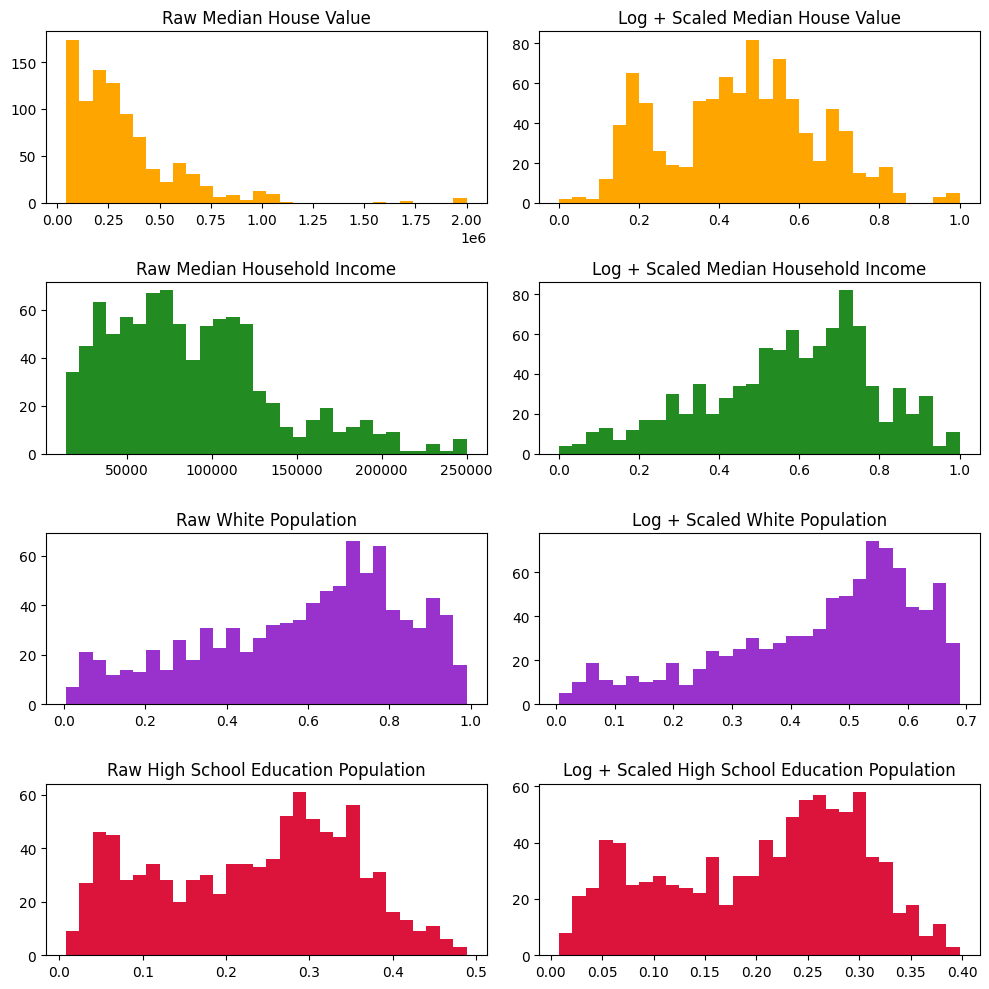

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(10, 10))

fields = [
    ("Median_House_Value", "Scaled_House_Value", "Median House Value", "orange"),
    ("Median_Household_Income", "Scaled_Household_Income", "Median Household Income", "forestgreen"),
    ("White_Population", "Log_White_Population", "White Population", "darkorchid"),
    ("HighSchoolEdu_Population", "Log_HighSchoolEdu_Population", "High School Education Population", "crimson")
]

for i, (raw, log, title, color) in enumerate(fields):
    axes[i, 0].hist(combined_data[raw], bins=30, color=color)
    axes[i, 0].set_title(f"Raw {title}")

    axes[i, 1].hist(combined_data[log], bins=30, color=color)
    axes[i, 1].set_title(f"Log + Scaled {title}")

plt.tight_layout()
plt.show()


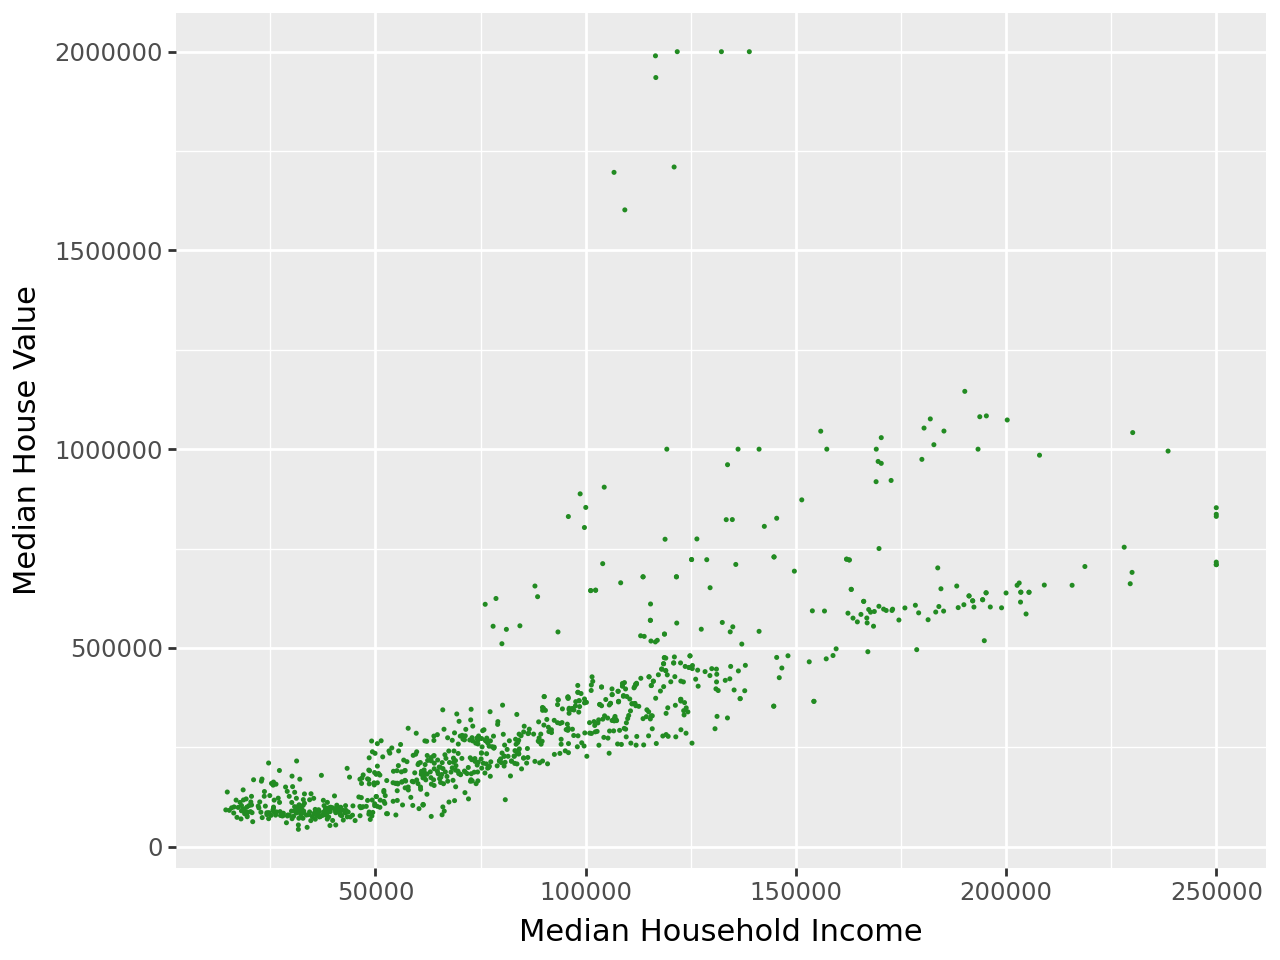

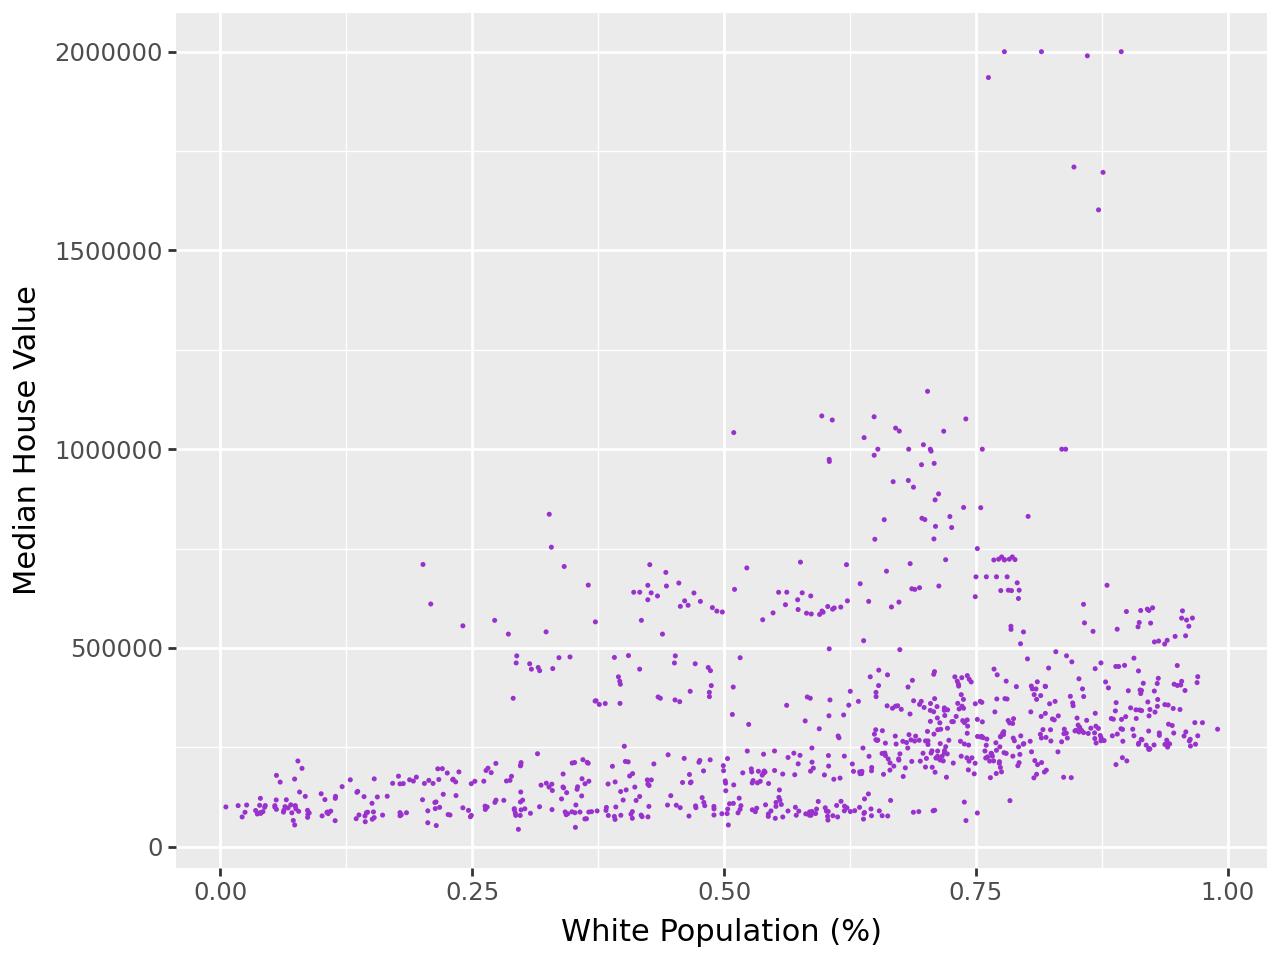

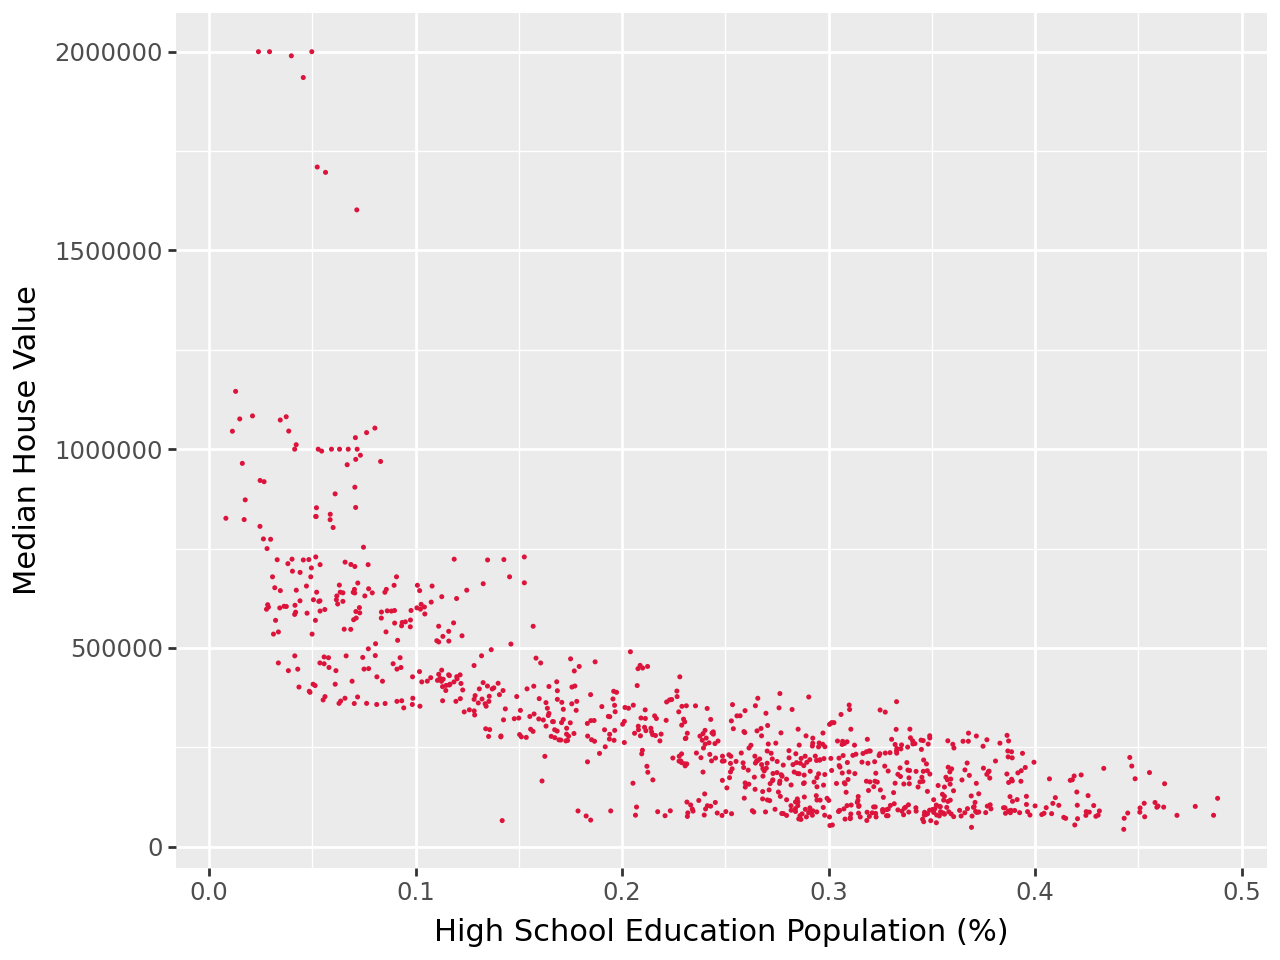

In [ ]:
from plotnine import ggplot, aes, geom_jitter, geom_histogram, facet_wrap, labs, theme_minimal

p1 = (
    ggplot(combined_data, aes(x="Median_Household_Income", y="Median_House_Value"))
    + geom_jitter(color="forestgreen", size=0.02)
    + labs(x="Median Household Income", y="Median House Value")
)

p2 = (
    ggplot(combined_data, aes(x="White_Population", y="Median_House_Value"))
    + geom_jitter(color="darkorchid", size=0.02)
    + labs(x="White Population (%)", y="Median House Value")
)

p3 = (
    ggplot(combined_data, aes(x="HighSchoolEdu_Population", y="Median_House_Value"))
    + geom_jitter(color="crimson", size=0.02)
    + labs(x="High School Education Population (%)", y="Median House Value")
)



from IPython.display import display

display(p1)
display(p2)
display(p3)

# Loading Data

In [ ]:
# Define the path to the .csv file in Google Drive
file_path = dir + 'median_household_income_and_median_house_value.csv'
file_path2 = dir + 'race_populations_percentages.csv'
file_path3 = dir + 'educational_attainment_percentages.csv'

# Load the data
data = pd.read_csv(file_path)
data2 = pd.read_csv(file_path2)
data3 = pd.read_csv(file_path3)

race_types = ['White_Population','Black_Population','Native_Population','Asian_Population','Hawaiian_Population','Other_Population','Two_Population']
edu_types = ['NoEdu_Population', 'NurseryEdu_Population', 'KindergartenEdu_Population', '1stEdu_Population', '2ndEdu_Population',
             '3rdEdu_Population', '4thEdu_Population', '5thEdu_Population', '6thEdu_Population', '7thEdu_Population', '8thEdu_Population', '9thEdu_Population',
             '10thEdu_Population', '11thEdu_Population', '12thEdu_Population', 'HighSchoolEdu_Population', 'GEDEdu_Population', 'College1Edu_Population',
             'College2Edu_Population', 'AssociateEdu_Population', 'BachelorEdu_Population', 'MasterEdu_Population', 'ProfessionalEdu_Population', 'DoctorateEdu_Population']

In [ ]:
# Reshape datasets from wide to long format
house_value_data_long = reshape_wide_to_long(data, 'Median_House_Value', range(2012, 2023))
hh_income_data_long = reshape_wide_to_long(data, 'Median_Household_Income', range(2012, 2023))
race_pop_data_long = reshape_wide_to_long_multiple_fields(data2, race_types, range(2012, 2023))
edu_data_long = reshape_wide_to_long_multiple_fields(data3, edu_types, range(2012, 2023))

# Fill in NA values with averages or previous/forward values
house_value_data_long = fill_missing_values(house_value_data_long, 'Median_House_Value')
hh_income_data_long = fill_missing_values(hh_income_data_long, 'Median_Household_Income')
race_pop_data_long = fill_missing_values_multiple_fields(race_pop_data_long, race_types)
edu_data_long = fill_missing_values_multiple_fields(edu_data_long, edu_types)

# Merge the DataFrames based on 'Census_Tract' and 'Year'
merged_data = pd.merge(house_value_data_long, hh_income_data_long, on=['Census_Tract', 'Year'])
merged_data = pd.merge(merged_data, race_pop_data_long, on=['Census_Tract', 'Year'])
merged_data = pd.merge(merged_data, edu_data_long, on=['Census_Tract', 'Year'])
merged_data.head()

Census_Tract  Year  Median_House_Value  Median_Household_Income  \
0           100  2012             89800.0                  31667.0   
1           100  2013             89400.0                  32943.0   
2           100  2014             84200.0                  32368.0   
3           100  2015             88500.0                  31042.0   
4           100  2016             90500.0                  32266.0   

   White_Population  Black_Population  Native_Population  Asian_Population  \
0          0.563521          0.212071                0.0          0.000000   
1          0.574278          0.175350                0.0          0.041381   
2          0.587051          0.183086                0.0          0.049566   
3          0.587258          0.153278                0.0          0.063096   
4          0.629767          0.191318                0.0          0.062636   

   Hawaiian_Population  Other_Population  ...  12thEdu_Population  \
0                  0.0          0.224408  ...            0.016173   
1                  0.0          0.208991  ...            0.017699   
2                  0.0          0.178129  ...            0.026540   
3                  0.0          0.194521  ...            0.048649   
4                  0.0          0.107287  ...            0.033586   

   HighSchoolEdu_Population  GEDEdu_Population  College1Edu_Population  \
0                  0.387062           0.023181                0.034501   
1                  0.342338           0.023754                0.016302   
2                  0.314472           0.026039                0.018528   
3                  0.290909           0.021130                0.037838   
4                  0.263009           0.028855                0.060549   

   College2Edu_Population  AssociateEdu_Population  BachelorEdu_Population  \
0                0.147709                 0.039892                0.054447   
1                0.101071                 0.019096                0.113647   
2                0.113170                 0.026540                0.130195   
3                0.101229                 0.031941                0.143980   
4                0.127247                 0.019395                0.118732   

   MasterEdu_Population  ProfessionalEdu_Population  DoctorateEdu_Population  
0              0.009164                    0.000000                      0.0  
1              0.014439                    0.000000                      0.0  
2              0.014522                    0.000000                      0.0  
3              0.020147                    0.004914                      0.0  
4              0.022233                    0.003784                      0.0  

[5 rows x 35 columns]

In [ ]:
# Create lag features
lag_years = [1, 2]
for lag in lag_years:
    merged_data[f'Lag{lag}_House_Value'] = merged_data.groupby('Census_Tract')['Median_House_Value'].shift(lag)

# Drop rows where any lag feature is NaN
merged_data.dropna(subset=[f'Lag{lag}_House_Value' for lag in lag_years], inplace=True)

merged_data.head()

Census_Tract  Year  Median_House_Value  Median_Household_Income  \
2           100  2014             84200.0                  32368.0   
3           100  2015             88500.0                  31042.0   
4           100  2016             90500.0                  32266.0   
5           100  2017             95000.0                  32462.0   
6           100  2018             94600.0                  31367.0   

   White_Population  Black_Population  Native_Population  Asian_Population  \
2          0.587051          0.183086           0.000000          0.049566   
3          0.587258          0.153278           0.000000          0.063096   
4          0.629767          0.191318           0.000000          0.062636   
5          0.645900          0.219962           0.000000          0.055308   
6          0.591893          0.235599           0.036574          0.007315   

   Hawaiian_Population  Other_Population  ...  GEDEdu_Population  \
2                  0.0          0.178129  ...           0.026039   
3                  0.0          0.194521  ...           0.021130   
4                  0.0          0.107287  ...           0.028855   
5                  0.0          0.070248  ...           0.026553   
6                  0.0          0.119171  ...           0.036697   

   College1Edu_Population  College2Edu_Population  AssociateEdu_Population  \
2                0.018528                0.113170                 0.026540   
3                0.037838                0.101229                 0.031941   
4                0.060549                0.127247                 0.019395   
5                0.085823                0.129445                 0.026079   
6                0.090826                0.154128                 0.050917   

   BachelorEdu_Population  MasterEdu_Population  ProfessionalEdu_Population  \
2                0.130195              0.014522                    0.000000   
3                0.143980              0.020147                    0.004914   
4                0.118732              0.022233                    0.003784   
5                0.128971              0.022285                    0.003793   
6                0.084862              0.023853                    0.005505   

   DoctorateEdu_Population  Lag1_House_Value  Lag2_House_Value  
2                      0.0           89400.0           89800.0  
3                      0.0           84200.0           89400.0  
4                      0.0           88500.0           84200.0  
5                      0.0           90500.0           88500.0  
6                      0.0           95000.0           90500.0  

[5 rows x 37 columns]

In [ ]:
# Log-transform target and income
merged_data = log_transform_column(merged_data, 'Median_House_Value', 'Log_House_Value')
merged_data = log_transform_column(merged_data, 'Median_Household_Income', 'Log_Household_Income')

for lag in lag_years:
    merged_data = log_transform_column(merged_data, f'Lag{lag}_House_Value', f'Log_Lag{lag}_House_Value')

# Scale using your scale_by_column function (MinMaxScaler)
merged_data, house_value_scaler = scale_by_column(merged_data, 'Log_House_Value', 'Scaled_House_Value')
merged_data, hh_income_scaler = scale_by_column(merged_data, 'Log_Household_Income', 'Scaled_Household_Income')

for lag in lag_years:
    merged_data[f'Scaled_Lag{lag}_House_Value'] = house_value_scaler.transform(
        merged_data[[f'Log_Lag{lag}_House_Value']].values.reshape(-1, 1)
    )


In [ ]:
# Getting predictors, dropping one column set from race_population_percentages and educational_attainment_percentages because they are perfectly collinear (add up to 1)
exclude = ['White_Population','HighSchoolEdu_Population']
predictors = ['Scaled_Household_Income'] + [c for c in race_types + edu_types if c not in exclude]

# Add scaled lag features
predictors += [f'Scaled_Lag{lag}_House_Value' for lag in lag_years]

X = merged_data[predictors]
y = merged_data['Scaled_House_Value']

In [ ]:
train_years = list(range(2012 + max(lag_years), 2021))  # 2014–2020
test_years = [2021, 2022]

X_train = X[merged_data['Year'].isin(train_years)]
y_train = y[merged_data['Year'].isin(train_years)]

X_test = X[merged_data['Year'].isin(test_years)]
y_test = y[merged_data['Year'].isin(test_years)]

# Loading Data (no lag features)

In [ ]:
# Define the path to the .csv file in Google Drive
file_path = dir + 'median_household_income_and_median_house_value.csv'
file_path2 = dir + 'race_populations_percentages.csv'
file_path3 = dir + 'educational_attainment_percentages.csv'

# Load the data
data = pd.read_csv(file_path)
data2 = pd.read_csv(file_path2)
data3 = pd.read_csv(file_path3)

race_types = ['White_Population','Black_Population','Native_Population','Asian_Population','Hawaiian_Population','Other_Population','Two_Population']
edu_types = ['NoEdu_Population', 'NurseryEdu_Population', 'KindergartenEdu_Population', '1stEdu_Population', '2ndEdu_Population',
             '3rdEdu_Population', '4thEdu_Population', '5thEdu_Population', '6thEdu_Population', '7thEdu_Population', '8thEdu_Population', '9thEdu_Population',
             '10thEdu_Population', '11thEdu_Population', '12thEdu_Population', 'HighSchoolEdu_Population', 'GEDEdu_Population', 'College1Edu_Population',
             'College2Edu_Population', 'AssociateEdu_Population', 'BachelorEdu_Population', 'MasterEdu_Population', 'ProfessionalEdu_Population', 'DoctorateEdu_Population']

In [ ]:
# Reshape datasets from wide to long format
house_value_data_long = reshape_wide_to_long(data, 'Median_House_Value', range(2012, 2023))
hh_income_data_long = reshape_wide_to_long(data, 'Median_Household_Income', range(2012, 2023))
race_pop_data_long = reshape_wide_to_long_multiple_fields(data2, race_types, range(2012, 2023))
edu_data_long = reshape_wide_to_long_multiple_fields(data3, edu_types, range(2012, 2023))

# Fill in NA values with averages or previous/forward values
house_value_data_long = fill_missing_values(house_value_data_long, 'Median_House_Value')
hh_income_data_long = fill_missing_values(hh_income_data_long, 'Median_Household_Income')
race_pop_data_long = fill_missing_values_multiple_fields(race_pop_data_long, race_types)
edu_data_long = fill_missing_values_multiple_fields(edu_data_long, edu_types)

# Merge the DataFrames based on 'Census_Tract' and 'Year'
merged_data = pd.merge(house_value_data_long, hh_income_data_long, on=['Census_Tract', 'Year'])
merged_data = pd.merge(merged_data, race_pop_data_long, on=['Census_Tract', 'Year'])
merged_data = pd.merge(merged_data, edu_data_long, on=['Census_Tract', 'Year'])
merged_data.head()

Census_Tract  Year  Median_House_Value  Median_Household_Income  \
0           100  2012             89800.0                  31667.0   
1           100  2013             89400.0                  32943.0   
2           100  2014             84200.0                  32368.0   
3           100  2015             88500.0                  31042.0   
4           100  2016             90500.0                  32266.0   

   White_Population  Black_Population  Native_Population  Asian_Population  \
0          0.563521          0.212071                0.0          0.000000   
1          0.574278          0.175350                0.0          0.041381   
2          0.587051          0.183086                0.0          0.049566   
3          0.587258          0.153278                0.0          0.063096   
4          0.629767          0.191318                0.0          0.062636   

   Hawaiian_Population  Other_Population  ...  12thEdu_Population  \
0                  0.0          0.224408  ...            0.016173   
1                  0.0          0.208991  ...            0.017699   
2                  0.0          0.178129  ...            0.026540   
3                  0.0          0.194521  ...            0.048649   
4                  0.0          0.107287  ...            0.033586   

   HighSchoolEdu_Population  GEDEdu_Population  College1Edu_Population  \
0                  0.387062           0.023181                0.034501   
1                  0.342338           0.023754                0.016302   
2                  0.314472           0.026039                0.018528   
3                  0.290909           0.021130                0.037838   
4                  0.263009           0.028855                0.060549   

   College2Edu_Population  AssociateEdu_Population  BachelorEdu_Population  \
0                0.147709                 0.039892                0.054447   
1                0.101071                 0.019096                0.113647   
2                0.113170                 0.026540                0.130195   
3                0.101229                 0.031941                0.143980   
4                0.127247                 0.019395                0.118732   

   MasterEdu_Population  ProfessionalEdu_Population  DoctorateEdu_Population  
0              0.009164                    0.000000                      0.0  
1              0.014439                    0.000000                      0.0  
2              0.014522                    0.000000                      0.0  
3              0.020147                    0.004914                      0.0  
4              0.022233                    0.003784                      0.0  

[5 rows x 35 columns]

In [ ]:
# Log-transform target and income
merged_data = log_transform_column(merged_data, 'Median_House_Value', 'Log_House_Value')
merged_data = log_transform_column(merged_data, 'Median_Household_Income', 'Log_Household_Income')

# Scale using your scale_by_column function (MinMaxScaler)
merged_data, house_value_scaler = scale_by_column(merged_data, 'Log_House_Value', 'Scaled_House_Value')
merged_data, hh_income_scaler = scale_by_column(merged_data, 'Log_Household_Income', 'Scaled_Household_Income')


In [ ]:
# Getting predictors, dropping one column set from race_population_percentages and educational_attainment_percentages because they are perfectly collinear (add up to 1)
exclude = ['White_Population','HighSchoolEdu_Population']
predictors = ['Scaled_Household_Income'] + [c for c in race_types + edu_types if c not in exclude]

X = merged_data[predictors]
y = merged_data['Scaled_House_Value']

In [ ]:
train_years = list(range(2012, 2021))  # 2014–2020
test_years = [2021, 2022]

X_train = X[merged_data['Year'].isin(train_years)]
y_train = y[merged_data['Year'].isin(train_years)]

X_test = X[merged_data['Year'].isin(test_years)]
y_test = y[merged_data['Year'].isin(test_years)]

# Linear Model

## OLS

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.anova import anova_lm

# Add constant term for intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
X_test_const = X_test_const[X_train_const.columns]

# 2. Fit linear regression model
model = sm.OLS(y_train, X_train_const).fit()

# 3. Summary output
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Scaled_House_Value   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1293.
Date:                Sat, 16 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:50:32   Log-Likelihood:                 1396.9
No. Observations:                 581   AIC:                            -2728.
Df Residuals:                     548   BIC:                            -2584.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

MAE: 24642.57
RMSE: 36289.24
R²: 0.986


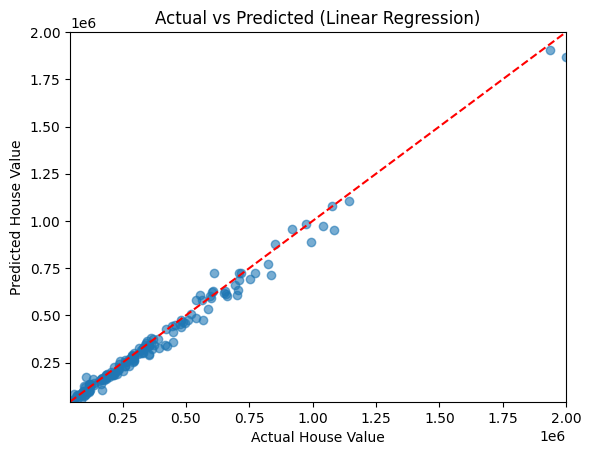

In [ ]:
# Predict on test set (scaled target)
y_pred_scaled = model.predict(X_test_const)

# Inverse transform predicted scaled house value
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled.values.reshape(-1, 1)).flatten()

# Undo log-transform (assumes natural log was used)
y_pred_original = np.expm1(y_pred_inv_scaled)

# Inverse transform actual scaled house value
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Undo log-transform for actual values
y_test_original = np.expm1(y_test_inv_scaled)

# Calculate metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# Plot with equal limits
lims = [min(min(y_test_original), min(y_pred_original)), max(max(y_test_original), max(y_pred_original))]

plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (Linear Regression)")
plt.show()

### Implied Baseline Coefficient and p-value

In [ ]:
from scipy.stats import t

# Set baseline
baseline = 'White_Population'
included = [col for col in race_types if col != baseline]

# Extract model parameters and covariance matrix
params = model.params
cov = model.cov_params()

# Compute implied coefficient for White
beta_white = -sum(params[col] for col in included)

# Compute variance of linear combination for White
var_white = sum(cov.loc[col, col] for col in included) + \
            2*sum(cov.loc[included[i], included[j]]
                  for i in range(len(included)) for j in range(i+1, len(included)))
std_white = np.sqrt(var_white)

# Compute t-statistic and p-value
t_white = beta_white / std_white
p_white = 2 * (1 - t.cdf(np.abs(t_white), df=model.df_resid))

print("Implied White_Population coefficient:", beta_white)
print("Implied White_Population p-value:", p_white)

Implied White_Population coefficient: 0.499736412988043
Implied White_Population p-value: 0.3131218295272109


In [ ]:
# Set baseline
baseline = 'HighSchoolEdu_Population'
included = [col for col in edu_types if col != baseline]

# Extract model parameters and covariance matrix
params = model.params
cov = model.cov_params()

# Compute implied coefficient for HighSchoolEdu
beta_hs = -sum(params[col] for col in included)

# Compute variance of linear combination for HighSchoolEdu
var_hs = sum(cov.loc[col, col] for col in included) + \
            2*sum(cov.loc[included[i], included[j]]
                  for i in range(len(included)) for j in range(i+1, len(included)))
std_hs = np.sqrt(var_hs)

# Compute t-statistic and p-value
t_hs = beta_hs / std_hs
p_hs = 2 * (1 - t.cdf(np.abs(t_hs), df=model.df_resid))

print("Implied HighSchoolEdu_Population coefficient:", beta_hs)
print("Implied HighSchoolEdu_Population p-value:", p_hs)

Implied HighSchoolEdu_Population coefficient: 0.853470067903063
Implied HighSchoolEdu_Population p-value: 0.6276889568159167


### Assumption Testing

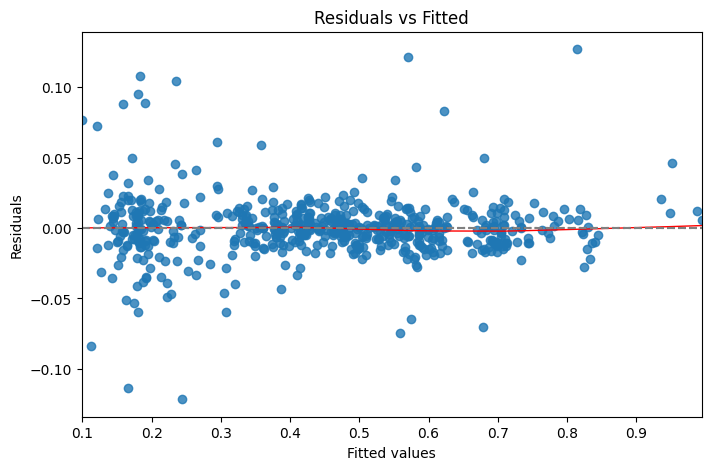

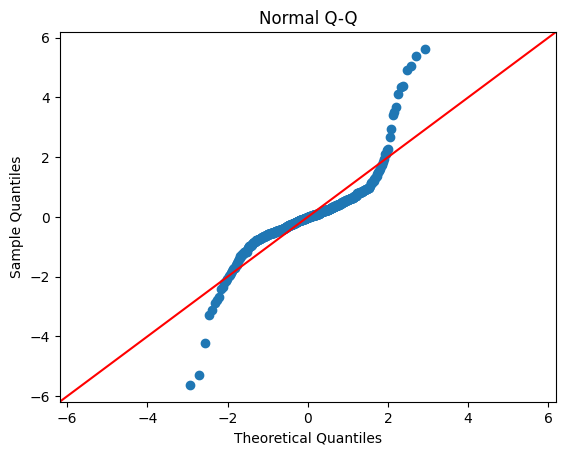

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Get predicted values and residuals
fitted_vals = model.fittedvalues
residuals = model.resid
standardized_residuals = model.get_influence().resid_studentized_internal

# Residuals vs Fitted
plt.figure(figsize=(8,5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True,
              line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='gray', linestyle='--')
plt.show()

# Normal Q-Q plot
sm.qqplot(standardized_residuals, line='45', fit=True)
plt.title('Normal Q-Q')
plt.show()

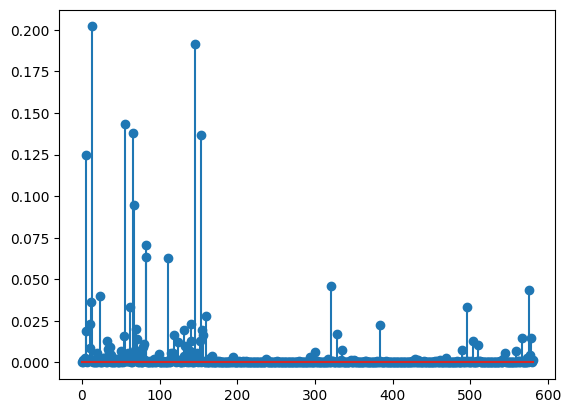

In [ ]:
import statsmodels.api as sm
influence = model.get_influence()
(c, p) = influence.cooks_distance

plt.stem(c)  # plot Cook's distance
plt.show()


## OLS with no scaling

In [ ]:
# Define the path to the .csv file in Google Drive
file_path = dir + 'median_household_income_and_median_house_value.csv'
file_path2 = dir + 'race_populations_percentages.csv'
file_path3 = dir + 'educational_attainment_percentages.csv'

# Load the data
data = pd.read_csv(file_path)
data2 = pd.read_csv(file_path2)
data3 = pd.read_csv(file_path3)

race_types = ['White_Population','Black_Population','Native_Population','Asian_Population','Hawaiian_Population','Other_Population','Two_Population']
edu_types = ['NoEdu_Population', 'NurseryEdu_Population', 'KindergartenEdu_Population', '1stEdu_Population', '2ndEdu_Population',
             '3rdEdu_Population', '4thEdu_Population', '5thEdu_Population', '6thEdu_Population', '7thEdu_Population', '8thEdu_Population', '9thEdu_Population',
             '10thEdu_Population', '11thEdu_Population', '12thEdu_Population', 'HighSchoolEdu_Population', 'GEDEdu_Population', 'College1Edu_Population',
             'College2Edu_Population', 'AssociateEdu_Population', 'BachelorEdu_Population', 'MasterEdu_Population', 'ProfessionalEdu_Population', 'DoctorateEdu_Population']

In [ ]:
# Reshape datasets from wide to long format
house_value_data_long = reshape_wide_to_long(data, 'Median_House_Value', range(2012, 2023))
hh_income_data_long = reshape_wide_to_long(data, 'Median_Household_Income', range(2012, 2023))
race_pop_data_long = reshape_wide_to_long_multiple_fields(data2, race_types, range(2012, 2023))
edu_data_long = reshape_wide_to_long_multiple_fields(data3, edu_types, range(2012, 2023))

# Fill in NA values with averages or previous/forward values
house_value_data_long = fill_missing_values(house_value_data_long, 'Median_House_Value')
hh_income_data_long = fill_missing_values(hh_income_data_long, 'Median_Household_Income')
race_pop_data_long = fill_missing_values_multiple_fields(race_pop_data_long, race_types)
edu_data_long = fill_missing_values_multiple_fields(edu_data_long, edu_types)

# Merge the DataFrames based on 'Census_Tract' and 'Year'
merged_data = pd.merge(house_value_data_long, hh_income_data_long, on=['Census_Tract', 'Year'])
merged_data = pd.merge(merged_data, race_pop_data_long, on=['Census_Tract', 'Year'])
merged_data = pd.merge(merged_data, edu_data_long, on=['Census_Tract', 'Year'])
merged_data.head()

Census_Tract  Year  Median_House_Value  Median_Household_Income  \
0           100  2012             89800.0                  31667.0   
1           100  2013             89400.0                  32943.0   
2           100  2014             84200.0                  32368.0   
3           100  2015             88500.0                  31042.0   
4           100  2016             90500.0                  32266.0   

   White_Population  Black_Population  Native_Population  Asian_Population  \
0          0.563521          0.212071                0.0          0.000000   
1          0.574278          0.175350                0.0          0.041381   
2          0.587051          0.183086                0.0          0.049566   
3          0.587258          0.153278                0.0          0.063096   
4          0.629767          0.191318                0.0          0.062636   

   Hawaiian_Population  Other_Population  ...  12thEdu_Population  \
0                  0.0          0.224408  ...            0.016173   
1                  0.0          0.208991  ...            0.017699   
2                  0.0          0.178129  ...            0.026540   
3                  0.0          0.194521  ...            0.048649   
4                  0.0          0.107287  ...            0.033586   

   HighSchoolEdu_Population  GEDEdu_Population  College1Edu_Population  \
0                  0.387062           0.023181                0.034501   
1                  0.342338           0.023754                0.016302   
2                  0.314472           0.026039                0.018528   
3                  0.290909           0.021130                0.037838   
4                  0.263009           0.028855                0.060549   

   College2Edu_Population  AssociateEdu_Population  BachelorEdu_Population  \
0                0.147709                 0.039892                0.054447   
1                0.101071                 0.019096                0.113647   
2                0.113170                 0.026540                0.130195   
3                0.101229                 0.031941                0.143980   
4                0.127247                 0.019395                0.118732   

   MasterEdu_Population  ProfessionalEdu_Population  DoctorateEdu_Population  
0              0.009164                    0.000000                      0.0  
1              0.014439                    0.000000                      0.0  
2              0.014522                    0.000000                      0.0  
3              0.020147                    0.004914                      0.0  
4              0.022233                    0.003784                      0.0  

[5 rows x 35 columns]

In [ ]:
# Create lag features
lag_years = [1, 2]
for lag in lag_years:
    merged_data[f'Lag{lag}_House_Value'] = merged_data.groupby('Census_Tract')['Median_House_Value'].shift(lag)

# Drop rows where any lag feature is NaN
merged_data.dropna(subset=[f'Lag{lag}_House_Value' for lag in lag_years], inplace=True)

merged_data.head()

Census_Tract  Year  Median_House_Value  Median_Household_Income  \
2           100  2014             84200.0                  32368.0   
3           100  2015             88500.0                  31042.0   
4           100  2016             90500.0                  32266.0   
5           100  2017             95000.0                  32462.0   
6           100  2018             94600.0                  31367.0   

   White_Population  Black_Population  Native_Population  Asian_Population  \
2          0.587051          0.183086           0.000000          0.049566   
3          0.587258          0.153278           0.000000          0.063096   
4          0.629767          0.191318           0.000000          0.062636   
5          0.645900          0.219962           0.000000          0.055308   
6          0.591893          0.235599           0.036574          0.007315   

   Hawaiian_Population  Other_Population  ...  GEDEdu_Population  \
2                  0.0          0.178129  ...           0.026039   
3                  0.0          0.194521  ...           0.021130   
4                  0.0          0.107287  ...           0.028855   
5                  0.0          0.070248  ...           0.026553   
6                  0.0          0.119171  ...           0.036697   

   College1Edu_Population  College2Edu_Population  AssociateEdu_Population  \
2                0.018528                0.113170                 0.026540   
3                0.037838                0.101229                 0.031941   
4                0.060549                0.127247                 0.019395   
5                0.085823                0.129445                 0.026079   
6                0.090826                0.154128                 0.050917   

   BachelorEdu_Population  MasterEdu_Population  ProfessionalEdu_Population  \
2                0.130195              0.014522                    0.000000   
3                0.143980              0.020147                    0.004914   
4                0.118732              0.022233                    0.003784   
5                0.128971              0.022285                    0.003793   
6                0.084862              0.023853                    0.005505   

   DoctorateEdu_Population  Lag1_House_Value  Lag2_House_Value  
2                      0.0           89400.0           89800.0  
3                      0.0           84200.0           89400.0  
4                      0.0           88500.0           84200.0  
5                      0.0           90500.0           88500.0  
6                      0.0           95000.0           90500.0  

[5 rows x 37 columns]

In [ ]:
# Log-transform target and income
merged_data = log_transform_column(merged_data, 'Median_House_Value', 'Log_House_Value')
merged_data = log_transform_column(merged_data, 'Median_Household_Income', 'Log_Household_Income')

for lag in lag_years:
    merged_data = log_transform_column(merged_data, f'Lag{lag}_House_Value', f'Log_Lag{lag}_House_Value')


In [ ]:
# Getting predictors, dropping one column set from race_population_percentages and educational_attainment_percentages because they are perfectly collinear (add up to 1)
exclude = ['White_Population','HighSchoolEdu_Population']
predictors = ['Log_Household_Income'] + [c for c in race_types + edu_types if c not in exclude]

# Add scaled lag features
predictors += [f'Log_Lag{lag}_House_Value' for lag in lag_years]

X = merged_data[predictors]
y = merged_data['Log_House_Value']

In [ ]:
train_years = list(range(2012 + max(lag_years), 2021))  # 2014–2020
test_years = [2021, 2022]

X_train = X[merged_data['Year'].isin(train_years)]
y_train = y[merged_data['Year'].isin(train_years)]

X_test = X[merged_data['Year'].isin(test_years)]
y_test = y[merged_data['Year'].isin(test_years)]

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.anova import anova_lm

# Add constant term for intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
X_test_const = X_test_const[X_train_const.columns]

# 2. Fit linear regression model
model = sm.OLS(y_train, X_train_const).fit()

# 3. Summary output
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Log_House_Value   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1293.
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:51:47   Log-Likelihood:                 617.33
No. Observations:                 581   AIC:                            -1169.
Df Residuals:                     548   BIC:                            -1025.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

MAE: 24642.57
RMSE: 36289.24
R²: 0.986


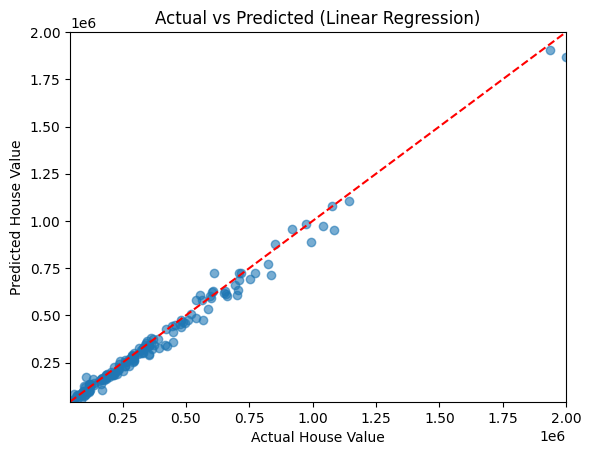

In [ ]:
# Predict on test set (scaled target)
y_pred_scaled = model.predict(X_test_const)

# Undo log-transform (assumes natural log was used)
y_pred_original = np.expm1(y_pred_scaled)

# Undo log-transform for actual values
y_test_original = np.expm1(y_test)

# Calculate metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# Plot with equal limits
lims = [min(min(y_test_original), min(y_pred_original)), max(max(y_test_original), max(y_pred_original))]

plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (Linear Regression)")
plt.show()

In [ ]:
# model.pvalues


const                         2.751026e-02
Log_Household_Income          3.053449e-02
Black_Population              5.632225e-01
Native_Population             1.741574e-01
Asian_Population              2.934039e-01
Hawaiian_Population           7.515295e-01
Other_Population              3.777118e-01
Two_Population                8.247037e-01
NoEdu_Population              1.768461e-01
NurseryEdu_Population         5.918692e-01
KindergartenEdu_Population    6.263692e-02
1stEdu_Population             1.340806e-01
2ndEdu_Population             4.005704e-01
3rdEdu_Population             1.427763e-01
4thEdu_Population             5.257013e-01
5thEdu_Population             9.693117e-01
6thEdu_Population             7.299758e-01
7thEdu_Population             6.484672e-01
8thEdu_Population             5.782351e-01
9thEdu_Population             6.150168e-01
10thEdu_Population            2.238811e-01
11thEdu_Population            7.721112e-02
12thEdu_Population            9.089364e-02
GEDEdu_Population             4.677145e-01
College1Edu_Population        1.696010e-01
College2Edu_Population        4.934576e-01
AssociateEdu_Population       1.549909e-02
BachelorEdu_Population        1.649198e-01
MasterEdu_Population          5.157925e-01
ProfessionalEdu_Population    1.107062e-02
DoctorateEdu_Population       1.389048e-02
Log_Lag1_House_Value          1.994744e-54
Log_Lag2_House_Value          2.948138e-01
dtype: float64

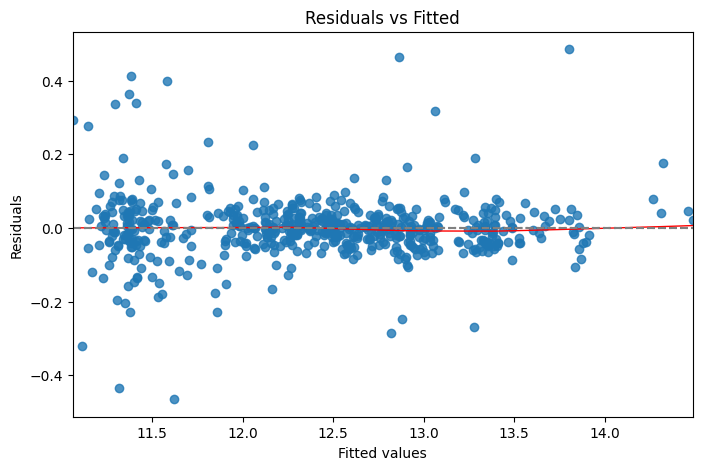

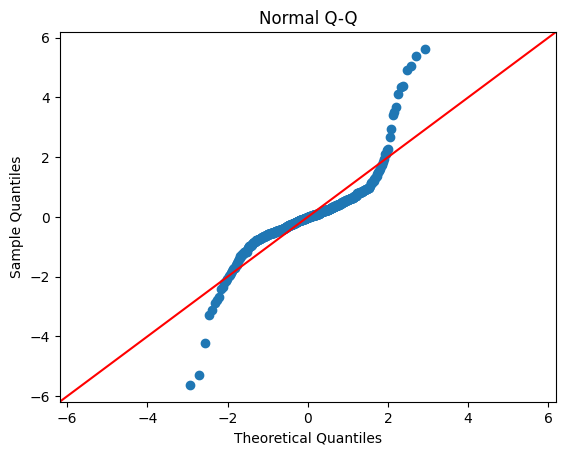

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Get predicted values and residuals
fitted_vals = model.fittedvalues
residuals = model.resid
standardized_residuals = model.get_influence().resid_studentized_internal

# Residuals vs Fitted
plt.figure(figsize=(8,5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True,
              line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='gray', linestyle='--')
plt.show()

# Normal Q-Q plot
sm.qqplot(standardized_residuals, line='45', fit=True)
plt.title('Normal Q-Q')
plt.show()

# LASSO Model

In [ ]:
"""
Model 1: LassoCV Pipeline (Direct Fit)

This model uses LassoCV inside a Pipeline that performs feature scaling followed by Lasso regression with built-in 10-fold cross-validation.
It automatically selects the best alpha (lambda.min) during fitting and directly outputs coefficients for that alpha.
The coefficients shown include only non-zero values, sorted by importance. This approach is straightforward and convenient for quick model fitting and feature importance extraction.
"""
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Create pipeline: scale → LASSO with CV
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=10, random_state=42))
])

# Fit model
lasso_pipeline.fit(X_train, y_train)

# Extract best alpha
best_alpha = lasso_pipeline.named_steps['lasso'].alpha_
print(f"Best alpha from CV: {best_alpha:.5f}")

# Evaluate on train and test sets
y_train_pred = lasso_pipeline.predict(X_train)
y_test_pred = lasso_pipeline.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Test R²:", r2_score(y_test, y_test_pred))

# Feature importance (non-zero coefficients)
coef = lasso_pipeline.named_steps['lasso'].coef_
feature_importance = pd.Series(coef, index=X_train.columns)
print("\nNon-zero LASSO coefficients:")
print(feature_importance[feature_importance != 0].sort_values(ascending=False))

# # Print all coefficients (including zeros) in the original order
# print("\nAll LASSO coefficients (including zeros):")
# # Ensuring the order is the same as the columns and showing zero coefficients
# for feature, coef_value in feature_importance.items():
#     if np.isclose(coef_value, 0):
#         print(f"{feature}                       .")  # Zero coefficients are printed as dots.
#     else:
#         print(f"{feature}   {coef_value:.10f}")  # Non-zero coefficients are printed with values.


Best alpha from CV: 0.00190
Train RMSE: 0.022641687255744745
Test RMSE: 0.031194606145923953
Test R²: 0.9767381359177624

Non-zero LASSO coefficients:
Scaled_Lag1_House_Value       0.174477
Scaled_Household_Income       0.004018
ProfessionalEdu_Population    0.003518
BachelorEdu_Population        0.002517
DoctorateEdu_Population       0.002062
MasterEdu_Population          0.000902
9thEdu_Population            -0.000159
College2Edu_Population       -0.000205
10thEdu_Population           -0.000356
College1Edu_Population       -0.000588
GEDEdu_Population            -0.000748
12thEdu_Population           -0.001251
Other_Population             -0.001830
dtype: float64


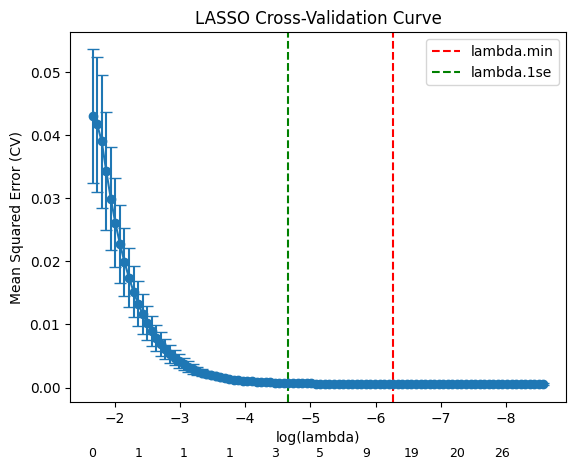

Intercept: 0.4477667679

Scaled_Household_Income        0.0040180904
Black_Population               .
Native_Population              .
Asian_Population               .
Hawaiian_Population            .
Other_Population               -0.0018295185
Two_Population                 .
NoEdu_Population               .
NurseryEdu_Population          .
KindergartenEdu_Population     .
1stEdu_Population              .
2ndEdu_Population              .
3rdEdu_Population              .
4thEdu_Population              .
5thEdu_Population              .
6thEdu_Population              .
7thEdu_Population              .
8thEdu_Population              .
9thEdu_Population              -0.0001586946
10thEdu_Population             -0.0003560311
11thEdu_Population             .
12thEdu_Population             -0.0012505945
GEDEdu_Population              -0.0007476676
College1Edu_Population         -0.0005884532
College2Edu_Population         -0.0002054999
AssociateEdu_Population        .
BachelorEdu_Population

In [ ]:
"""
Model 2: Explicit Alpha Selection and Detailed Output

This model also uses a Pipeline with scaling and LassoCV but explicitly extracts the full alpha path and refits a separate Lasso model at the chosen lambda.min alpha value.
It provides detailed diagnostics such as cross-validation MSE plots, the number of variables selected at different alphas, and prints all coefficients (including zeros, shown as dots).
This method offers more control and interpretability of the Lasso path and helps visualize model sparsity across alphas.

...the models are like identical so it don't really matter bruh
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1. Create pipeline with scaling + LassoCV (10-fold CV)
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=10, random_state=42, n_jobs=-1))
])

# 2. Fit on training data
lasso_pipeline.fit(X_train, y_train)

# 3. Extract LassoCV object for details
lasso = lasso_pipeline.named_steps['lasso']

alphas = lasso.alphas_
mse_mean = np.mean(lasso.mse_path_, axis=1)
mse_std = np.std(lasso.mse_path_, axis=1) / np.sqrt(lasso.mse_path_.shape[1])

# lambda.min and lambda.1se
lambda_min = lasso.alpha_
min_idx = np.argmin(mse_mean)
mse_1se_thresh = mse_mean[min_idx] + mse_std[min_idx]
lambda_1se = max(alphas[mse_mean <= mse_1se_thresh])

# Number of nonzero coeffs for each alpha
n_nonzero_coefs = []
for a in alphas:
    l = Lasso(alpha=a, max_iter=10000)
    X_scaled = lasso_pipeline.named_steps['scaler'].transform(X_train)
    l.fit(X_scaled, y_train)
    n_nonzero_coefs.append(np.sum(l.coef_ != 0))
n_nonzero_coefs = np.array(n_nonzero_coefs)

# 4. Plot CV MSE curve with variable count annotations
plt.errorbar(np.log(alphas), mse_mean, yerr=mse_std, fmt='-o', capsize=4)
plt.axvline(np.log(lambda_min), color='red', linestyle='--', label='lambda.min')
plt.axvline(np.log(lambda_1se), color='green', linestyle='--', label='lambda.1se')
plt.gca().invert_xaxis()

for i, (x, nvars) in enumerate(zip(np.log(alphas), n_nonzero_coefs)):
    if i % max(1, len(alphas)//10) == 0:  # label ~10 points
        plt.text(x, mse_mean.min() - 0.01, str(nvars), ha='center', va='top', fontsize=9)

plt.xlabel('log(lambda)')
plt.ylabel('Mean Squared Error (CV)')
plt.legend()
plt.title('LASSO Cross-Validation Curve')
plt.show()

# 5. Fit final Lasso at lambda.min and get coefficients
final_lasso = Lasso(alpha=lambda_min, max_iter=10000)
X_scaled = lasso_pipeline.named_steps['scaler'].transform(X_train)
final_lasso.fit(X_scaled, y_train)

coef_series = pd.Series(final_lasso.coef_, index=X_train.columns)

print(f"Intercept: {final_lasso.intercept_:.10f}\n")

# 6. Print all coefficients, zero coefficients as '.'
def fmt_coef(x):
    return '.' if np.isclose(x, 0) else f'{x:.10f}'

for feature, val in coef_series.items():
    print(f"{feature:30} {fmt_coef(val)}")

MAE: 23566.60
RMSE: 35495.35
R²: 0.986


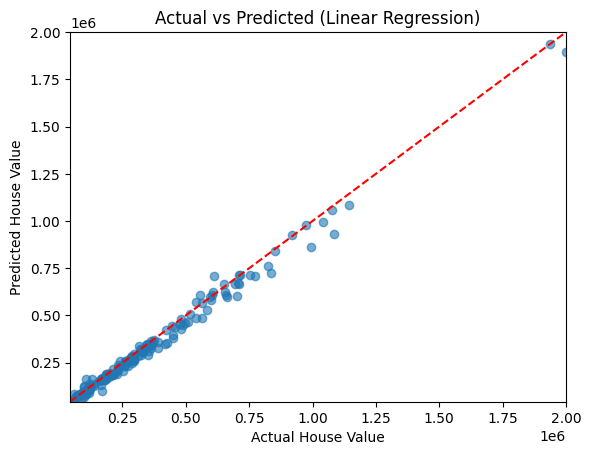

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Predict on test set using your Lasso pipeline
y_pred_scaled = lasso_pipeline.predict(X_test)  # predicted scaled log-values

# Inverse transform predicted scaled values (undo MinMax scaling)
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Undo log-transform (assuming natural log +1 was used)
y_pred_original = np.expm1(y_pred_inv_scaled)

# Inverse transform actual scaled test values
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Undo log-transform for actual values
y_test_original = np.expm1(y_test_inv_scaled)

# Calculate metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# Plot with equal limits
lims = [min(min(y_test_original), min(y_pred_original)), max(max(y_test_original), max(y_pred_original))]

plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (Linear Regression)")
plt.show()

In [ ]:
# Scale X_test using the scaler used for training
X_test_scaled = house_value_scaler.transform(X_test)

# Predict scaled target using the separately fitted Lasso model
y_pred_scaled = final_lasso.predict(X_test)

# Inverse transform predicted scaled house value
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Undo log-transform (assuming natural log with np.expm1)
y_pred_original = np.expm1(y_pred_inv_scaled)

# Inverse transform actual scaled house value (same as above)
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
y_test_original = np.expm1(y_test_inv_scaled)

# Calculate metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = mean_squared_error(y_test_original, y_pred_original) ** 0.5

print("\nModel 2 (Separate Lasso) Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



Model 2 (Separate Lasso) Metrics:
MAE: 171317.53
RMSE: 259816.76


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


# LSTM

## Model v1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.1738 - val_loss: 0.2025
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0578 - val_loss: 0.0316
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0173 - val_loss: 0.0070
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0040 - val_loss: 0.0071
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0023 - val_loss: 0.0064
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0017 - val_loss: 0.0084
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0019 - val_loss: 0.0068
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - val_loss: 0.0070
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - val_loss: 0.0060
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0

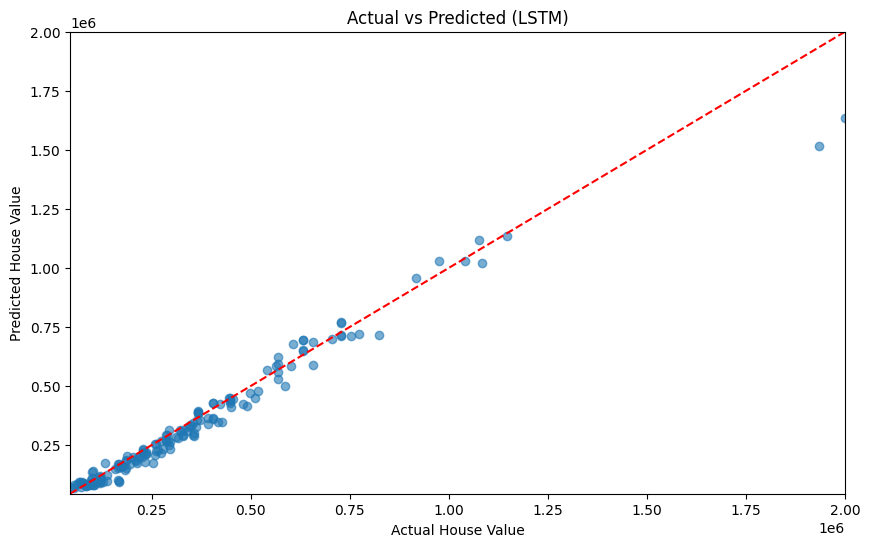

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sequence_length = 2  # match your lag features
static_features = ['Scaled_Household_Income'] + \
                  [c for c in race_types + edu_types if c not in ['White_Population','HighSchoolEdu_Population']]

# --- STEP 1: Build sequences ---
X_seq, y_seq, y_seq_years = [], [], []

for _, group in merged_data.groupby('Census_Tract'):
    group = group.sort_values('Year')  # ensure time order
    lag_vals = group[[f'Scaled_Lag{lag}_House_Value' for lag in lag_years]].values
    static_vals = group[static_features].values
    years = group['Year'].values

    for i in range(sequence_length, len(group)):
        # Sequence of lagged house values
        lag_sequence = lag_vals[i-sequence_length:i]
        # Repeat static features across sequence_length
        repeated_static = np.repeat(static_vals[i].reshape(1, -1), sequence_length, axis=0)
        # Combine lag sequence + static features
        features_seq = np.hstack([lag_sequence, repeated_static])
        X_seq.append(features_seq)
        y_seq.append(group['Scaled_House_Value'].values[i])
        y_seq_years.append(years[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
y_seq_years = np.array(y_seq_years)

# --- STEP 2: Train/test split ---
X_train_lstm = X_seq[np.isin(y_seq_years, train_years)]
y_train_lstm = y_seq[np.isin(y_seq_years, train_years)]

X_test_lstm = X_seq[np.isin(y_seq_years, test_years)]
y_test_lstm = y_seq[np.isin(y_seq_years, test_years)]

# --- STEP 3: Build LSTM model ---
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train_lstm.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# --- STEP 4: Train ---
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# --- STEP 5: Predict ---
y_pred_scaled = model.predict(X_test_lstm).flatten()

# --- STEP 6: Reverse transformations to dollars ---
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_pred_original = np.expm1(y_pred_inv_scaled)

y_test_inv_scaled = house_value_scaler.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()
y_test_original = np.expm1(y_test_inv_scaled)

# --- STEP 7: Metrics ---
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# --- STEP 8: Plot actual vs predicted ---
lims = [min(min(y_test_original), min(y_pred_original)),
        max(max(y_test_original), max(y_pred_original))]

plt.figure(figsize=(10,6))
plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (LSTM)")
plt.show()


## Model v2 (no tuning)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - loss: 0.1987 - val_loss: 0.1192
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0829 - val_loss: 0.0206
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0126 - val_loss: 0.0201
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0190 - val_loss: 0.0067
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0057 - val_loss: 0.0086
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 13/50

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
MAE: 42923.76
RMSE: 61802.78
R²: 0.958


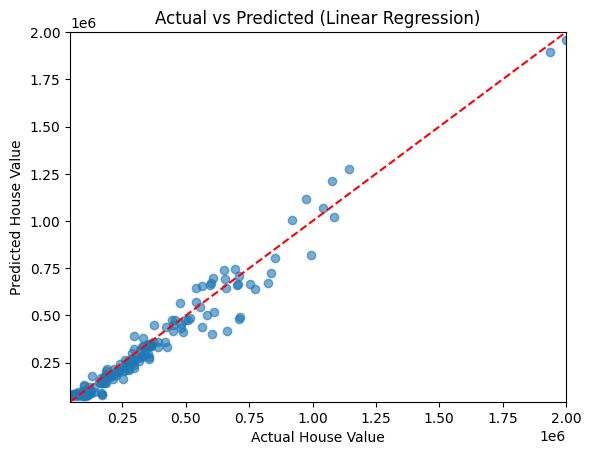

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Lock TensorFlow for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters
sequence_length = 3  # How many past years each sequence looks back
features = predictors  # Features to include (from merged_data) ----- ['Scaled_Household_Income'] + [c for c in race_types + edu_types if c not in ['White_Population','HighSchoolEdu_Population']] + ['Scaled_House_Value']
train_years = list(range(2012, 2020))  # Train: 2012-2019
val_years = [2020]                       # Validation: 2020
test_years = [2021, 2022]               # Test: 2021-2022

# Generate sequences for LSTM
X_seq, y_seq = [], []
tracts = merged_data['Census_Tract'].unique()

for tract in tracts:
    tract_data = merged_data[merged_data['Census_Tract'] == tract].sort_values('Year')
    tract_features = tract_data[features].values
    tract_target = tract_data['Scaled_House_Value'].values

    if len(tract_target) > sequence_length:
        for i in range(sequence_length, len(tract_target)):
            X_seq.append(tract_features[i-sequence_length:i])
            y_seq.append(tract_target[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)
years_seq = []
for tract in tracts:
    tract_data = merged_data[merged_data['Census_Tract'] == tract].sort_values('Year')
    years = tract_data['Year'].values[sequence_length:]  # aligned with sequences
    years_seq.extend(years)
years_seq = np.array(years_seq)

# Split train / validation / test
train_mask = np.isin(years_seq, train_years)
val_mask = np.isin(years_seq, val_years)
test_mask = np.isin(years_seq, test_years)

X_train, y_train = X_seq[train_mask], y_seq[train_mask]
X_val, y_val = X_seq[val_mask], y_seq[val_mask]
X_test, y_test = X_seq[test_mask], y_seq[test_mask]

# Build and train model
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(sequence_length, len(features))))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Metrics
y_pred_scaled = model.predict(X_test)
# Inverse scale
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled).flatten()
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
# Undo log transform
y_pred_original = np.expm1(y_pred_inv_scaled)
y_test_original = np.expm1(y_test_inv_scaled)

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# Plot with equal limits
lims = [min(min(y_test_original), min(y_pred_original)), max(max(y_test_original), max(y_pred_original))]

plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (LSTM)")
plt.show()

## Model v3 (early stopping callback)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

# Lock TensorFlow for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- PARAMETERS ---
sequence_length = 3
features = predictors  # list of predictor column names
train_years = list(range(2012, 2020))
val_years = [2020]
test_years = [2021, 2022]
lstm_units = [64, 32]       # units for each LSTM layer
epochs = 100
batch_size = 32
patience = 10               # EarlyStopping patience

# --- GENERATE SEQUENCES ---
X_seq, y_seq = [], []
tracts = merged_data['Census_Tract'].unique()

for tract in tracts:
    tract_data = merged_data[merged_data['Census_Tract'] == tract].sort_values('Year')
    tract_features = tract_data[features].values
    tract_target = tract_data['Scaled_House_Value'].values

    if len(tract_target) > sequence_length:
        for i in range(sequence_length, len(tract_target)):
            X_seq.append(tract_features[i-sequence_length:i])
            y_seq.append(tract_target[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# --- ALIGN YEARS ---
years_seq = []
for tract in tracts:
    tract_data = merged_data[merged_data['Census_Tract'] == tract].sort_values('Year')
    years = tract_data['Year'].values[sequence_length:]
    years_seq.extend(years)
years_seq = np.array(years_seq)

# --- SPLIT ---
train_mask = np.isin(years_seq, train_years)
val_mask = np.isin(years_seq, val_years)
test_mask = np.isin(years_seq, test_years)

X_train, y_train = X_seq[train_mask], y_seq[train_mask]
X_val, y_val = X_seq[val_mask], y_seq[val_mask]
X_test, y_test = X_seq[test_mask], y_seq[test_mask]

# --- BUILD MODEL ---
model = Sequential()
for i, units in enumerate(lstm_units):
    if i < len(lstm_units) - 1:
        model.add(LSTM(units, return_sequences=True, input_shape=(sequence_length, len(features)) if i==0 else None))
    else:
        model.add(LSTM(units))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# --- EARLY STOPPING CALLBACK ---
early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# --- TRAIN ---
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.1897 - val_loss: 0.0626
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0371 - val_loss: 0.0242
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0169 - val_loss: 0.0105
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0055 - val_loss: 0.0072
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0062
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0060
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 0.0058
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0036 - val_loss: 0.0056
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

## Model v4 (v2 but with kerastuner)

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/chec

In [2]:
"""
Tuning parameters:
- First LSTM units: 16–256
- Dropout rate after first LSTM: 0–0.3
- Whether to add a second LSTM layer (use_second_lstm)
- Second LSTM units: 16–128 (if used)
- Dropout rate after second LSTM: 0–0.2
- Whether to add a third LSTM layer (use_third_lstm)
- Third LSTM units: 16–128 (if used)
- Dropout rate after second LSTM: 0–0.2
- Learning rate: 1e-4 to 1e-2
- Batch size: 16, 32, 64, 128
"""
#!pip install keras-tuner
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras_tuner as kt  # <-- install with pip install keras-tuner

# Lock reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters
sequence_length = 3  # How many past years each sequence looks back
features = predictors  # Features to include (from merged_data) ----- ['Scaled_Household_Income'] + [c for c in race_types + edu_types if c not in ['White_Population','HighSchoolEdu_Population']] + ['Scaled_House_Value']
train_years = list(range(2012, 2020))  # Train: 2012-2019
val_years = [2020]                       # Validation: 2020
test_years = [2021, 2022]               # Test: 2021-2022

# Generate sequences for LSTM
X_seq, y_seq = [], []
tracts = merged_data['Census_Tract'].unique()

for tract in tracts:
    tract_data = merged_data[merged_data['Census_Tract'] == tract].sort_values('Year')
    tract_features = tract_data[features].values
    tract_target = tract_data['Scaled_House_Value'].values

    if len(tract_target) > sequence_length:
        for i in range(sequence_length, len(tract_target)):
            X_seq.append(tract_features[i-sequence_length:i])
            y_seq.append(tract_target[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)
years_seq = []
for tract in tracts:
    tract_data = merged_data[merged_data['Census_Tract'] == tract].sort_values('Year')
    years = tract_data['Year'].values[sequence_length:]  # aligned with sequences
    years_seq.extend(years)
years_seq = np.array(years_seq)

# Split train / validation / test
train_mask = np.isin(years_seq, train_years)
val_mask = np.isin(years_seq, val_years)
test_mask = np.isin(years_seq, test_years)

X_train, y_train = X_seq[train_mask], y_seq[train_mask]
X_val, y_val = X_seq[val_mask], y_seq[val_mask]
X_test, y_test = X_seq[test_mask], y_seq[test_mask]





# Hypermodel function
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(
        units=hp.Int('lstm_1_units', min_value=16, max_value=256, step=16),
        return_sequences=True,
        input_shape=(sequence_length, len(features))
    ))
    model.add(Dropout(hp.Float('dropout_1', 0.0, 0.3, step=0.1)))

    # Optional second LSTM
    use_second = hp.Boolean('use_second_lstm')
    use_third = hp.Boolean('use_third_lstm')

    if use_second:
        model.add(LSTM(
            units=hp.Int('lstm_2_units', min_value=16, max_value=128, step=16),
            return_sequences=use_third  # True if a third LSTM will follow
        ))
        model.add(Dropout(hp.Float('dropout_2', 0.0, 0.2, step=0.1)))
    else:
        # Ensure first LSTM is not returning sequences if it's the last LSTM
        model.layers[-1].return_sequences = False

    # Optional third LSTM
    if use_third:
        model.add(LSTM(
            units=hp.Int('lstm_3_units', min_value=16, max_value=128, step=16),
            return_sequences=False  # last LSTM before Dense
        ))
        model.add(Dropout(hp.Float('dropout_3', 0.0, 0.2, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='mean_squared_error'
    )
    return model

# Create tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # number of hyperparameter combinations
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='lstm_tuning',
    overwrite=True
)

# Define a tunable batch size
def tuner_search_with_batch():
    for batch_size in [16, 32, 64, 128]:
        tuner.search(
            X_train, y_train,
            epochs=20,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=batch_size
        )

# Run the search
tuner_search_with_batch()

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate
y_pred_scaled = best_model.predict(X_test)
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled).flatten()
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

y_pred_original = np.expm1(y_pred_inv_scaled)
y_test_original = np.expm1(y_test_inv_scaled)

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
for param_name, value in best_hps.values.items():
    print(f"{param_name}: {value}")


ModuleNotFoundError: No module named 'keras_tuner'

## Model v5 (Hyperparameter Tuning with KerasTuner, EarlyStopping, and Tunable Sequence Length)

In [ ]:
"""
- Tunable sequence length
- Proper train/validation/test splitting (validation is always 2020)
- Early stopping
- No double-counting lag features
- Correct callback handling for KerasTuner
"""

#!pip install keras-tuner
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras_tuner as kt

# Lock reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- Parameters ---
features = predictors  # list of feature column names
train_years = list(range(2012, 2020))
val_years = [2020]
test_years = [2021, 2022]

# --- Function to generate sequences given a sequence length ---
def generate_sequences(data, seq_len, features, target_col='Scaled_House_Value'):
    X_seq, y_seq, years_seq = [], [], []
    tracts = data['Census_Tract'].unique()

    for tract in tracts:
        tract_data = data[data['Census_Tract'] == tract].sort_values('Year')
        tract_features = tract_data[features].values
        tract_target = tract_data[target_col].values
        years = tract_data['Year'].values

        for i in range(seq_len, len(tract_target)):
            X_seq.append(tract_features[i-seq_len:i])
            y_seq.append(tract_target[i])
            years_seq.append(years[i])

    return np.array(X_seq), np.array(y_seq), np.array(years_seq)

# --- Hypermodel class ---
class LSTMHyperModel(kt.HyperModel):
    def __init__(self, data, features, train_years, val_years):
        self.data = data
        self.features = features
        self.train_years = train_years
        self.val_years = val_years

    def build(self, hp):
        seq_len = hp.Int('sequence_length', min_value=1, max_value=5, step=1)
        X_seq, y_seq, years_seq = generate_sequences(self.data, seq_len, self.features)

        # Train/validation split
        train_mask = np.isin(years_seq, self.train_years)
        val_mask = np.isin(years_seq, self.val_years)

        self.X_train, self.y_train = X_seq[train_mask], y_seq[train_mask]
        self.X_val, self.y_val = X_seq[val_mask], y_seq[val_mask]

        model = Sequential()
        model.add(Input(shape=(seq_len, len(self.features))))

        # First LSTM
        model.add(LSTM(
            units=hp.Int('lstm_1_units', 16, 256, step=16),
            return_sequences=True
        ))
        model.add(Dropout(hp.Float('dropout_1', 0.0, 0.3, step=0.1)))

        use_second = hp.Boolean('use_second_lstm')
        use_third = hp.Boolean('use_third_lstm')

        # Optional second LSTM
        if use_second:
            model.add(LSTM(
                units=hp.Int('lstm_2_units', 16, 128, step=16),
                return_sequences=use_third
            ))
            model.add(Dropout(hp.Float('dropout_2', 0.0, 0.2, step=0.1)))

        # Optional third LSTM
        if use_third:
            model.add(LSTM(
                units=hp.Int('lstm_3_units', 16, 128, step=16),
                return_sequences=False
            ))
            model.add(Dropout(hp.Float('dropout_3', 0.0, 0.2, step=0.1)))
        else:
            # Make sure last LSTM is not returning sequences
            if use_second:
                model.layers[-1].return_sequences = False

        model.add(Dense(1))
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
            ),
            loss='mean_squared_error'
        )
        return model

    # Custom fit to handle early stopping and avoid callback conflicts
    def fit(self, hp, model, *args, **kwargs):
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        tuner_callbacks = kwargs.pop('callbacks', [])
        all_callbacks = tuner_callbacks + [early_stop]

        return model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_val, self.y_val),
            epochs=50,
            verbose=1,
            callbacks=all_callbacks,
            **kwargs
        )

# --- Create tuner ---
hypermodel = LSTMHyperModel(merged_data, features, train_years, val_years)

tuner = kt.RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='lstm_tuning',
    overwrite=True
)

# --- Search ---
tuner.search(batch_size=32)

# --- Get best model ---
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# --- Evaluate on test set ---
X_test, y_test, years_test = generate_sequences(merged_data, best_hps.get('sequence_length'), features)
test_mask = np.isin(years_test, test_years)
X_test, y_test = X_test[test_mask], y_test[test_mask]

y_pred_scaled = best_model.predict(X_test)
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled).flatten()
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

y_pred_original = np.expm1(y_pred_inv_scaled)
y_test_original = np.expm1(y_test_inv_scaled)

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

print("\nBest Hyperparameters:")
for param_name, value in best_hps.values.items():
    print(f"{param_name}: {value}")


Trial 20 Complete [00h 00m 13s]
val_loss: 0.0023721468169242144

Best val_loss So Far: 0.0023721468169242144
Total elapsed time: 00h 04m 39s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
MAE: 44174.86
RMSE: 70423.10
R²: 0.946

Best Hyperparameters:
sequence_length: 2
lstm_1_units: 16
dropout_1: 0.2
use_second_lstm: False
use_third_lstm: True
learning_rate: 0.001020044518434461
lstm_2_units: 112
dropout_2: 0.2
lstm_3_units: 112
dropout_3: 0.0


In [ ]:
# Metrics
y_pred_scaled = model.predict(X_test)
# Inverse scale
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled).flatten()
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
# Undo log transform
y_pred_original = np.expm1(y_pred_inv_scaled)
y_test_original = np.expm1(y_test_inv_scaled)

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# Plot results
lims = [min(min(y_test_original), min(y_pred_original)), max(max(y_test_original), max(y_pred_original))]

plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (LSTM)")
plt.show()

## Final Model

In [ ]:
# Lock reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- PARAMETERS ---
sequence_length = 2  # how many past years each sequence looks back
features = predictors  # your features list
train_years = list(range(2012, 2020))
test_years = [2021, 2022]

# --- GENERATE SEQUENCES ---
X_seq, y_seq = [], []
years_seq = []

tracts = merged_data['Census_Tract'].unique()
for tract in tracts:
    tract_data = merged_data[merged_data['Census_Tract'] == tract].sort_values('Year')
    tract_features = tract_data[features].values
    tract_target = tract_data['Scaled_House_Value'].values

    if len(tract_target) > sequence_length:
        for i in range(sequence_length, len(tract_target)):
            X_seq.append(tract_features[i-sequence_length:i])
            y_seq.append(tract_target[i])
            years_seq.append(tract_data['Year'].values[i])

X_seq, y_seq, years_seq = np.array(X_seq), np.array(y_seq), np.array(years_seq)

# Split into train/test
train_mask = np.isin(years_seq, train_years)
test_mask = np.isin(years_seq, test_years)

X_train, y_train = X_seq[train_mask], y_seq[train_mask]
X_test, y_test = X_seq[test_mask], y_seq[test_mask]


# --- BUILD LSTM MODEL USING BEST HYPERPARAMS ---
model = Sequential()

# First LSTM
model.add(LSTM(
    units=48,
    return_sequences=True,  # True because a third LSTM exists
    input_shape=(sequence_length, len(features))
))
model.add(Dropout(0.1))

# Second LSTM
model.add(LSTM(
    units=128,
    return_sequences=True
))
model.add(Dropout(0))

# Third LSTM
model.add(LSTM(
    units=48,
    return_sequences=False
))
model.add(Dropout(0))

# Output
model.add(Dense(1))

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005009008490200304),
    loss='mean_squared_error'
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    verbose=1
)

# --- EVALUATE ---
y_pred_scaled = model.predict(X_test)
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled).flatten()
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

y_pred_original = np.expm1(y_pred_inv_scaled)
y_test_original = np.expm1(y_test_inv_scaled)

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.1348
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0223
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0052
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0038
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0011
Epoc

In [ ]:
#@title ignore ts

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- PARAMETERS ---
sequence_length = 3
features_list = predictors  # same as before
train_years = list(range(2012, 2020))
test_years = [2021, 2022]
n_runs = 5  # number of repeats

# --- GENERATE SEQUENCES ---
X_seq, y_seq, years_seq = [], [], []
tracts = merged_data['Census_Tract'].unique()
for tract in tracts:
    tract_data = merged_data[merged_data['Census_Tract'] == tract].sort_values('Year')
    tract_features = tract_data[features_list].values
    tract_target = tract_data['Scaled_House_Value'].values

    if len(tract_target) > sequence_length:
        for i in range(sequence_length, len(tract_target)):
            X_seq.append(tract_features[i-sequence_length:i])
            y_seq.append(tract_target[i])
            years_seq.append(tract_data['Year'].values[i])

X_seq, y_seq, years_seq = np.array(X_seq), np.array(y_seq), np.array(years_seq)

# Split train/test
train_mask = np.isin(years_seq, train_years)
test_mask = np.isin(years_seq, test_years)

X_train, y_train = X_seq[train_mask], y_seq[train_mask]
X_test, y_test = X_seq[test_mask], y_seq[test_mask]

n_runs = 5  # or 10
rmse_list, r2_list = [], []
best_rmse = float('inf')
best_model = None

for run in range(n_runs):
    np.random.seed(42 + run)
    tf.random.set_seed(42 + run)

    model = Sequential()
    model.add(LSTM(240, return_sequences=True, input_shape=(sequence_length, len(predictors))))
    model.add(Dropout(0.0))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001687), loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled).flatten()
    y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

    y_pred_original = np.expm1(y_pred_inv_scaled)
    y_test_original = np.expm1(y_test_inv_scaled)

    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)

    rmse_list.append(rmse)
    r2_list.append(r2)

    # Keep the best model by RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model

print(f"Average RMSE over {n_runs} runs: {np.mean(rmse_list):.2f}")
print(f"Average R² over {n_runs} runs: {np.mean(r2_list):.3f}")

# Best model metrics
print(f"Best model RMSE: {best_rmse:.2f}")


# Plot with equal limits
lims = [min(min(y_test_original), min(y_pred_original)), max(max(y_test_original), max(y_pred_original))]

plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (LSTM)")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 


--- Running Trial 1 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


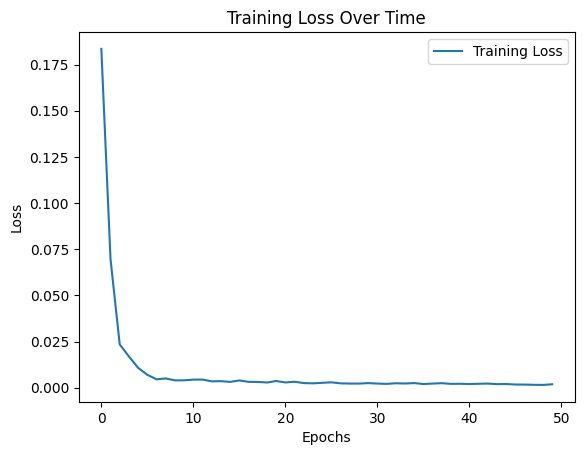

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


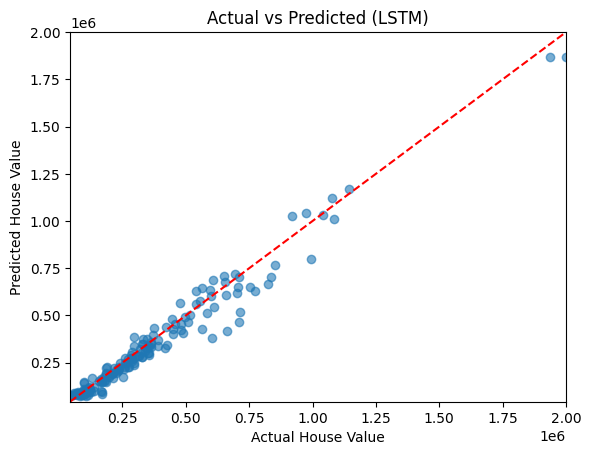


--- Running Trial 2 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


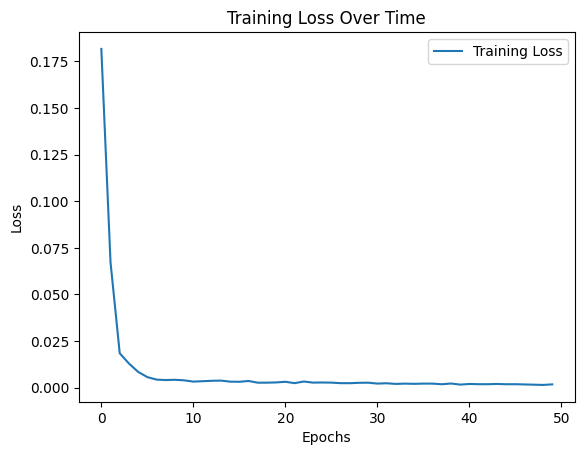

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step


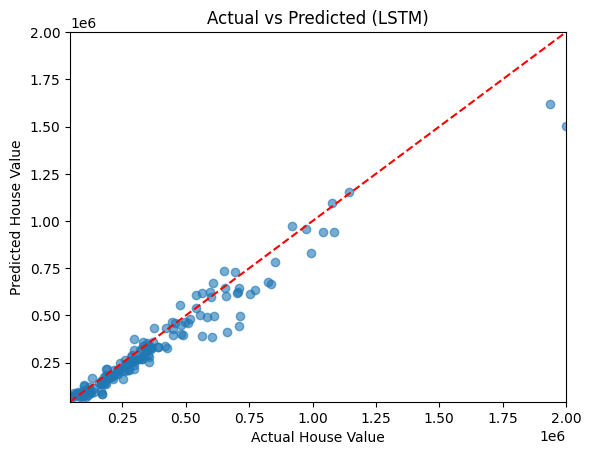


--- Running Trial 3 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


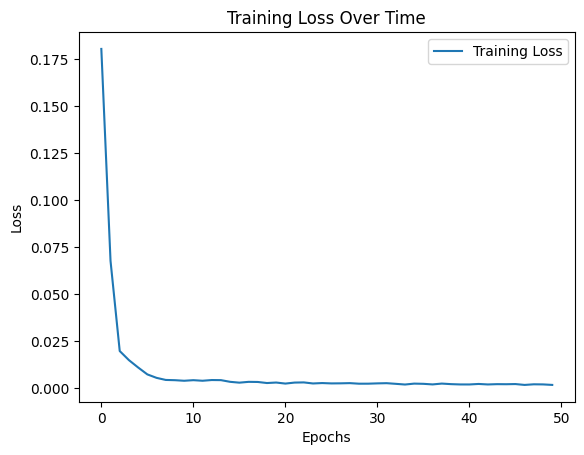

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


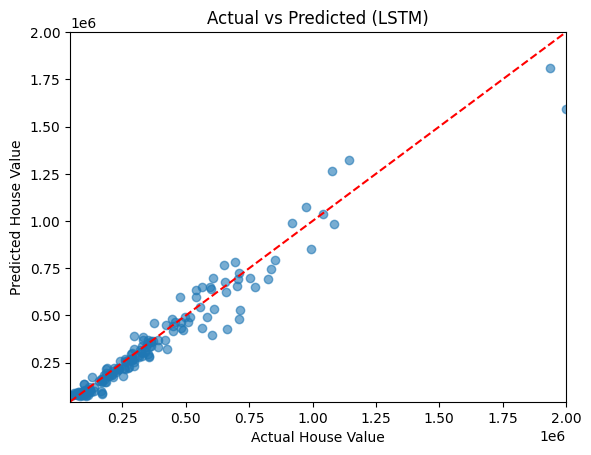


--- Running Trial 4 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


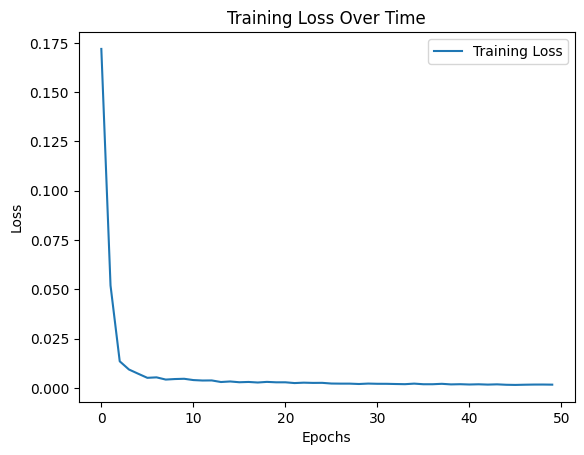

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


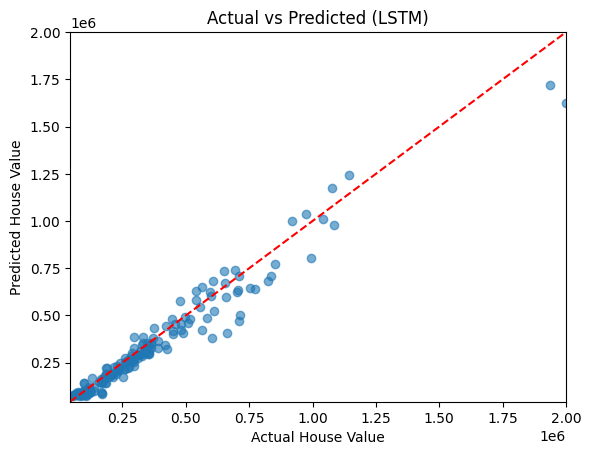


--- Running Trial 5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


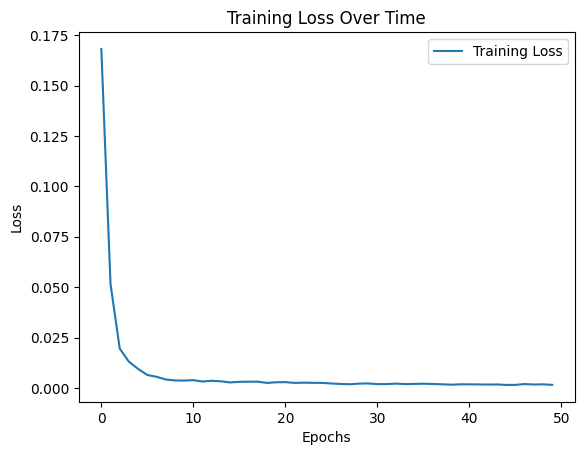

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


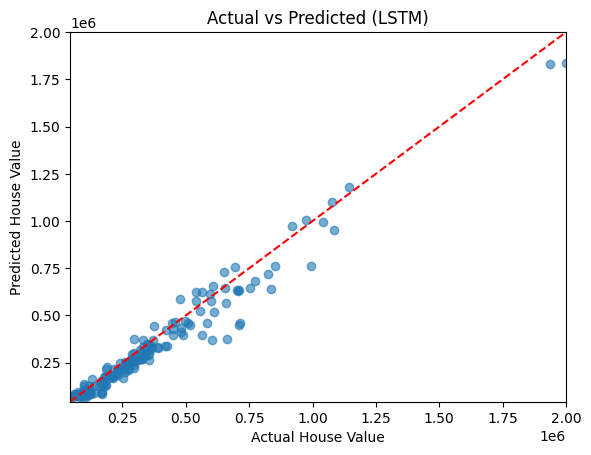


--- Running Trial 6 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


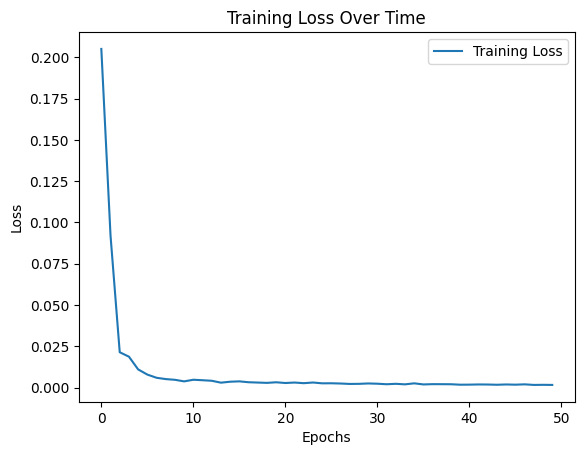

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


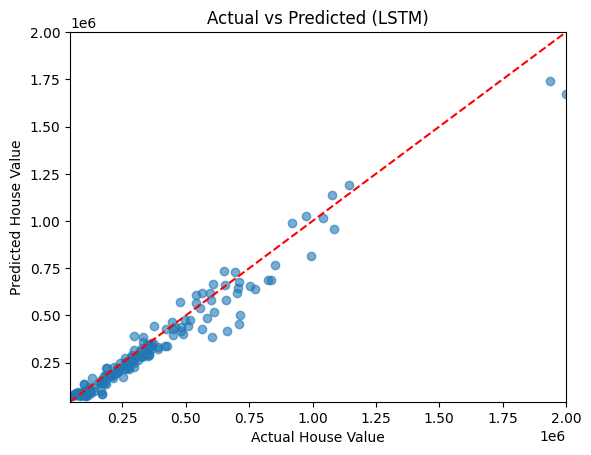


--- Running Trial 7 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


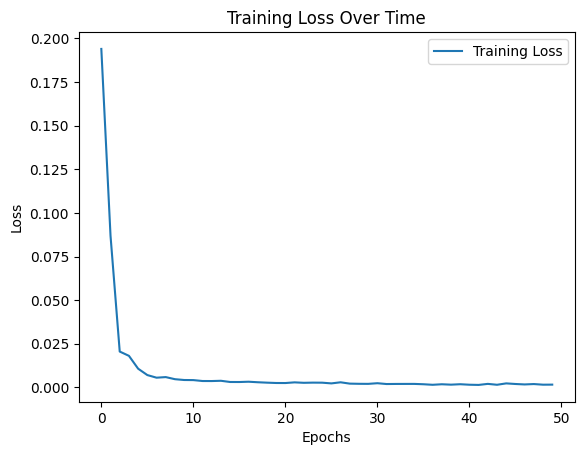

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


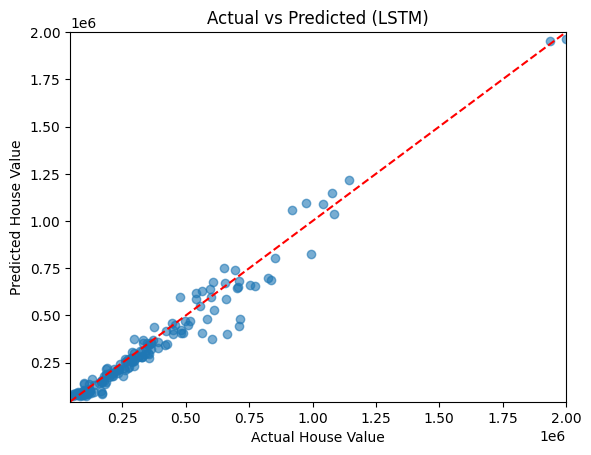


--- Running Trial 8 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


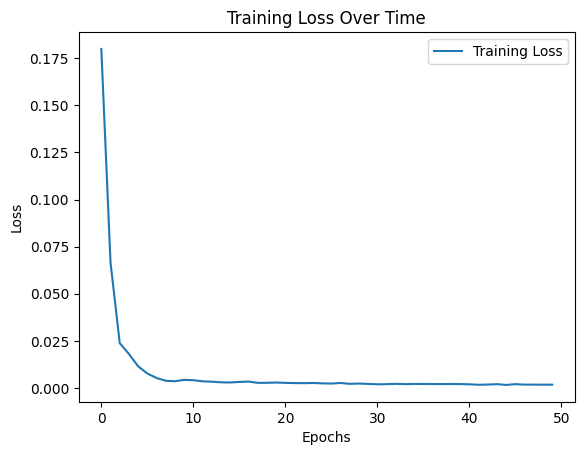

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


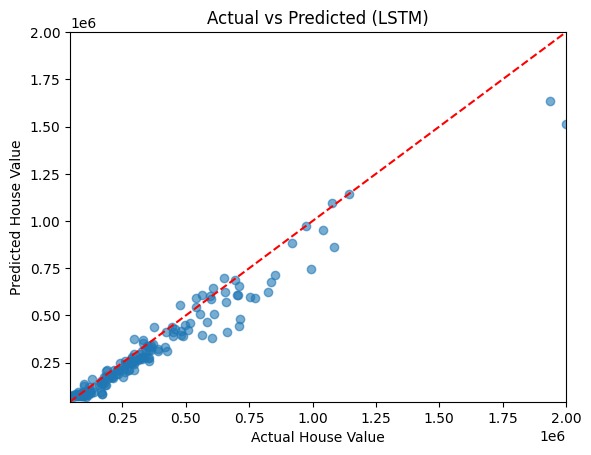


--- Running Trial 9 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


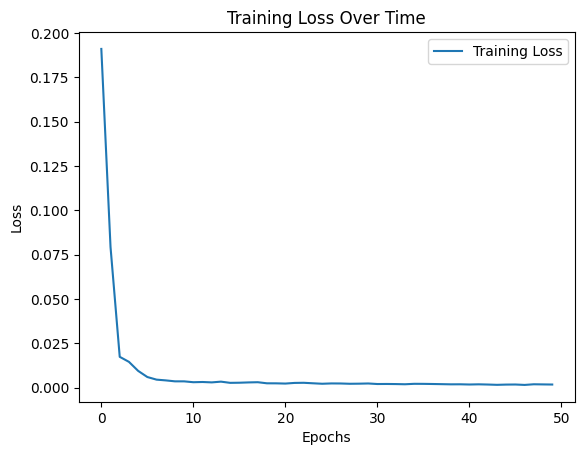

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step


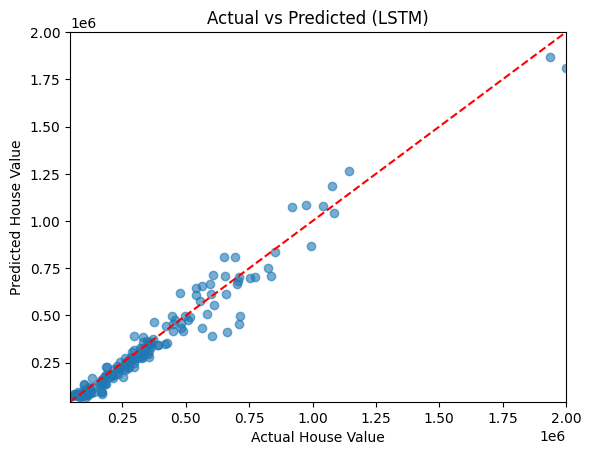


--- Running Trial 10 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


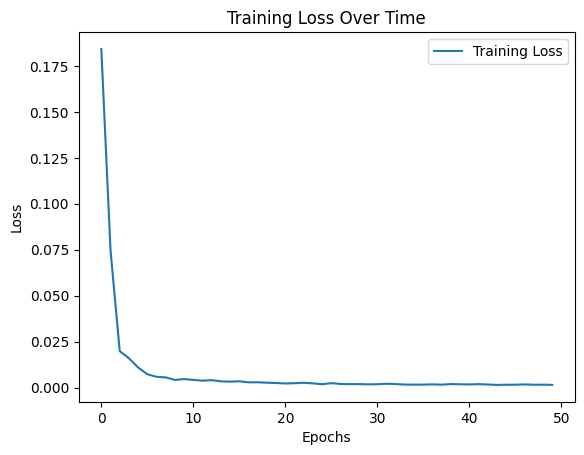

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


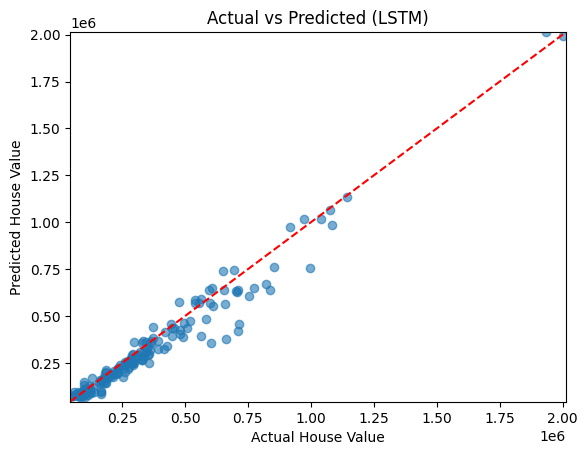


--- Running Trial 11 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


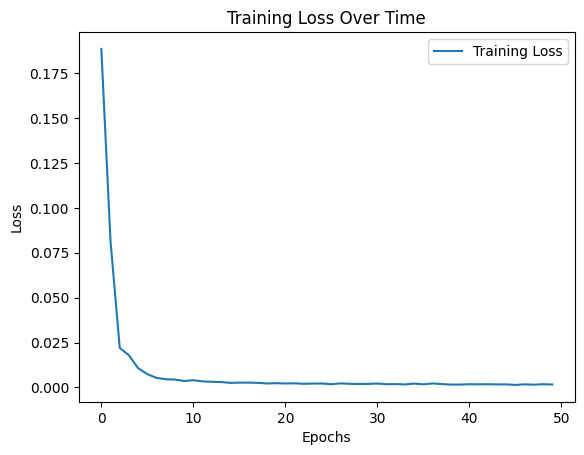

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


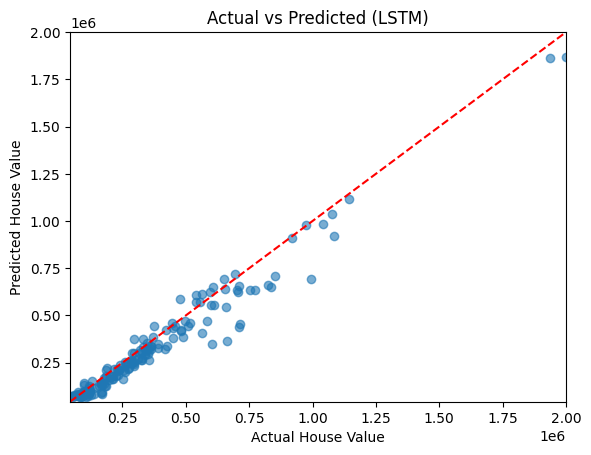


--- Running Trial 12 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


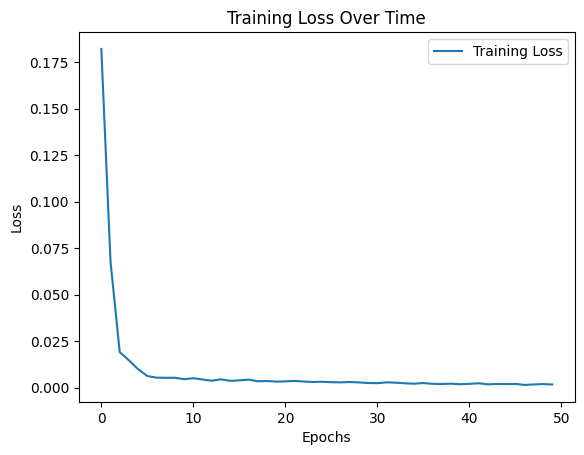

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


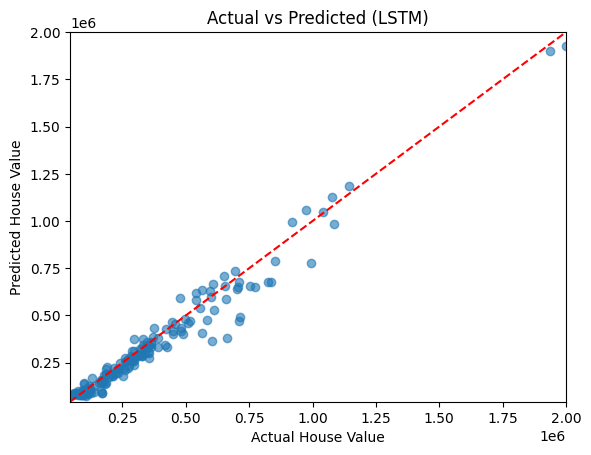


--- Running Trial 13 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


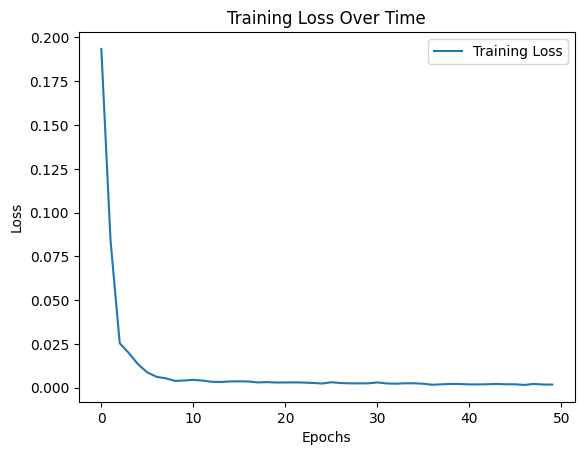

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


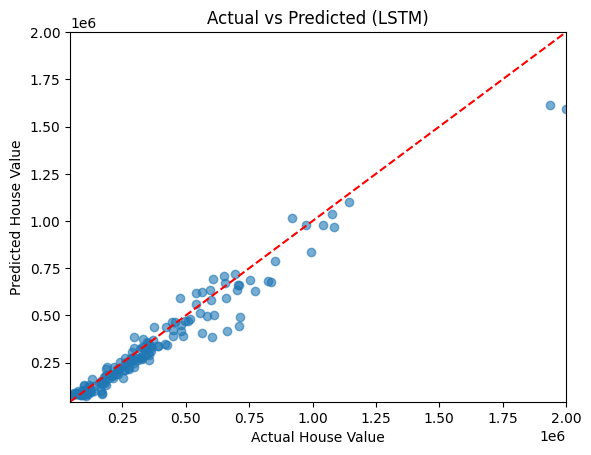


--- Running Trial 14 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


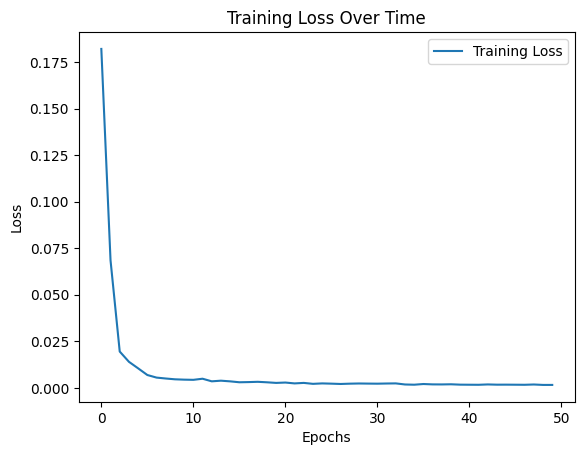

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


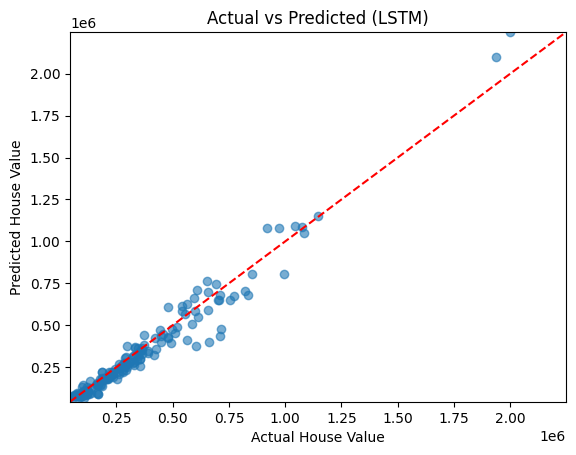


--- Running Trial 15 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


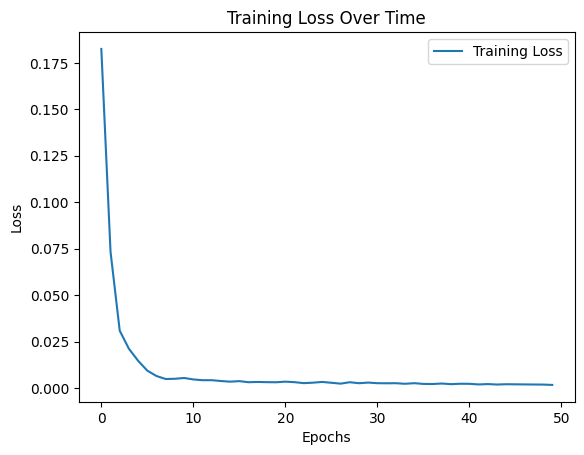

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


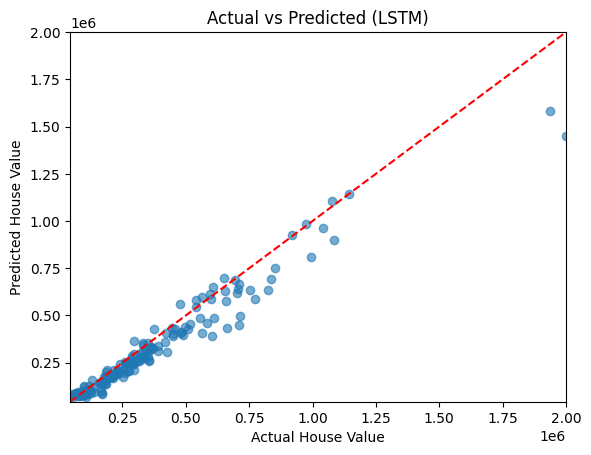


--- Running Trial 16 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


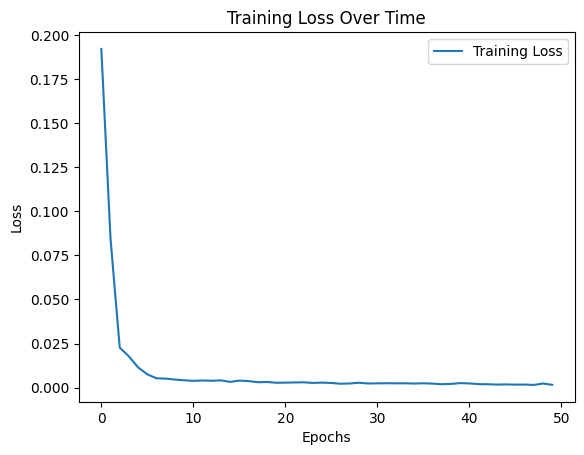

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


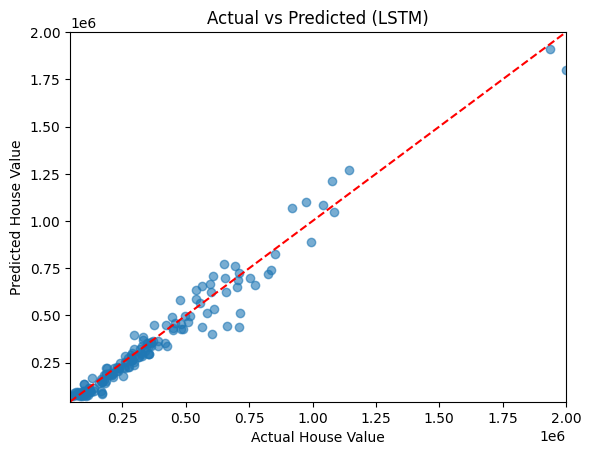


--- Running Trial 17 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


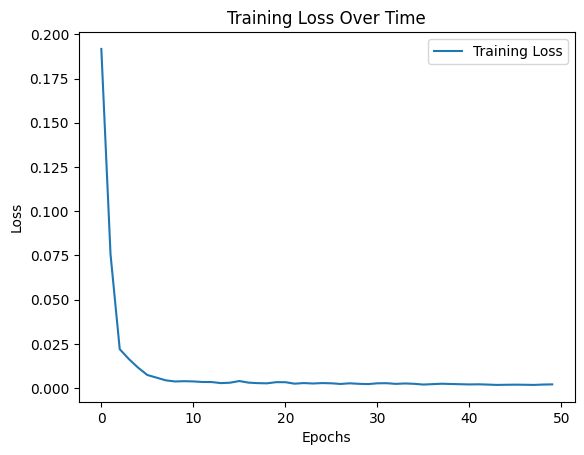

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


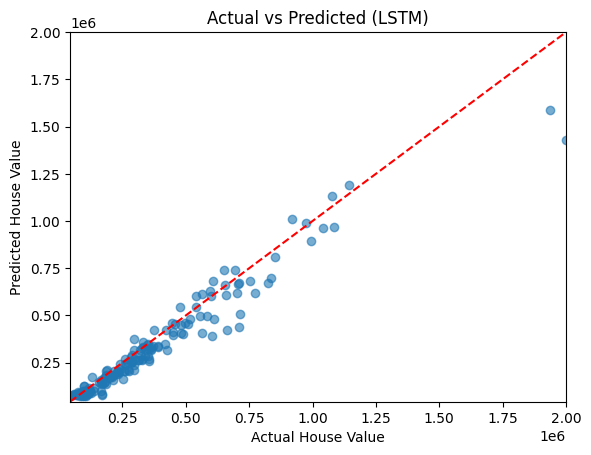


--- Running Trial 18 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


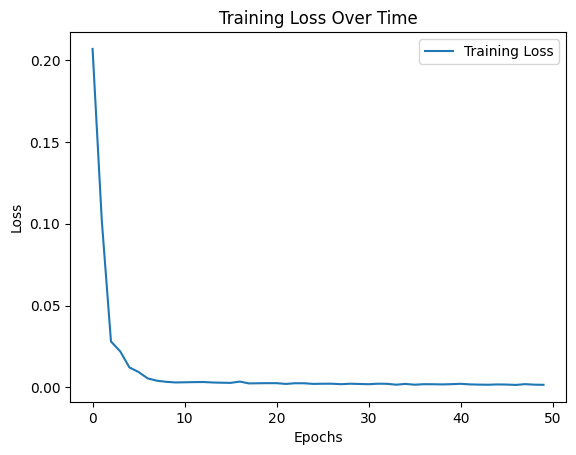

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


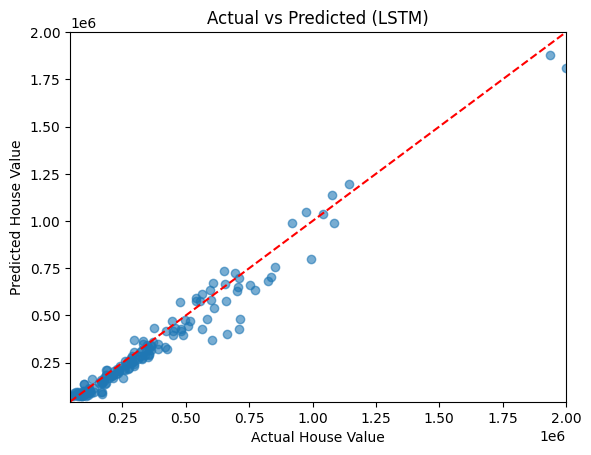


--- Running Trial 19 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


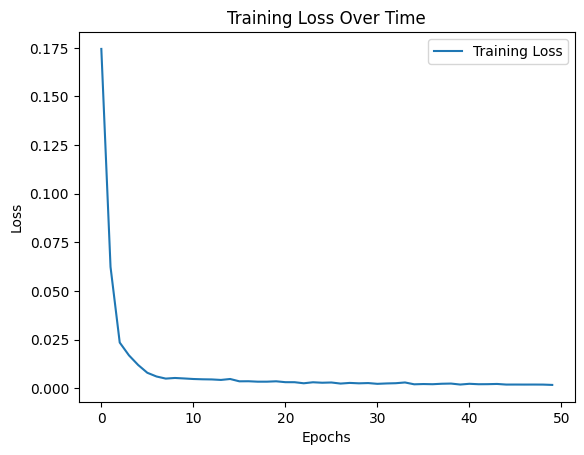

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step


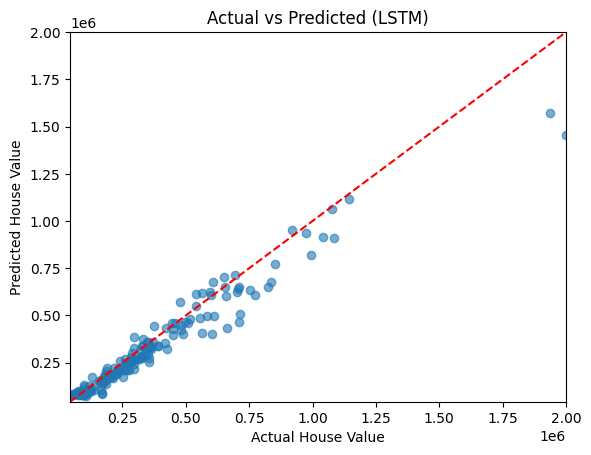


--- Running Trial 20 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


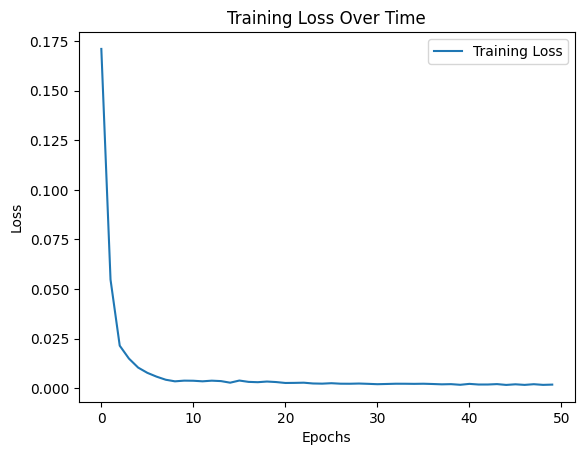

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


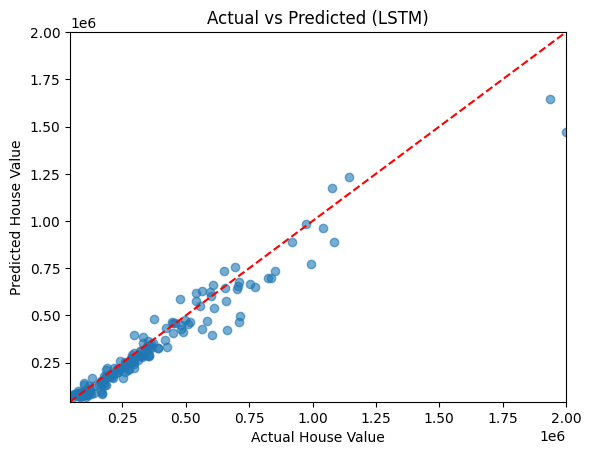


--- Running Trial 21 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


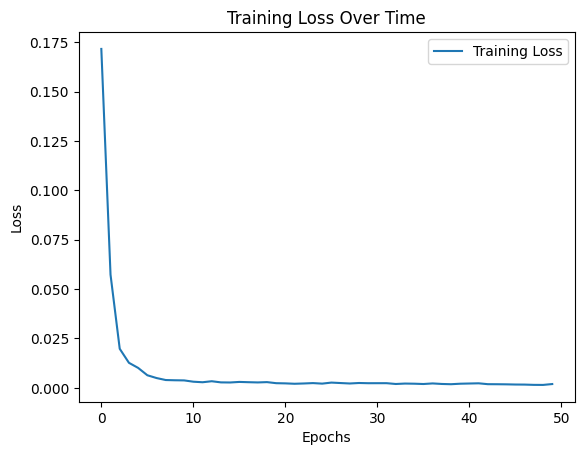

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


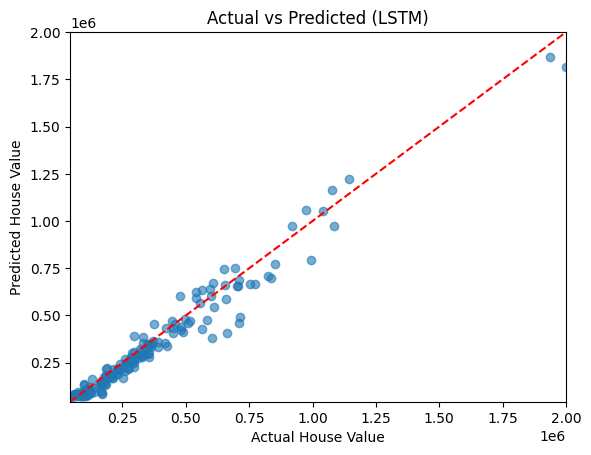


--- Running Trial 22 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


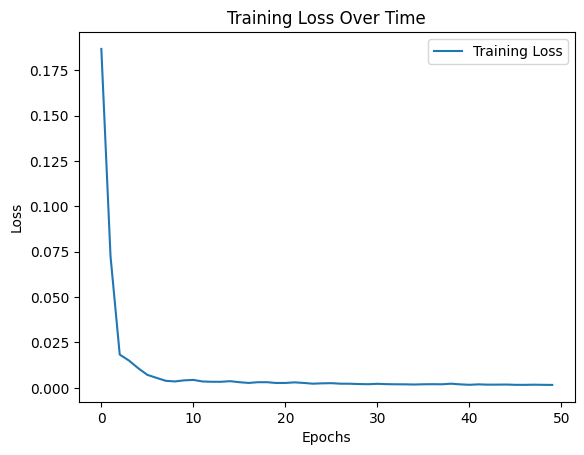

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


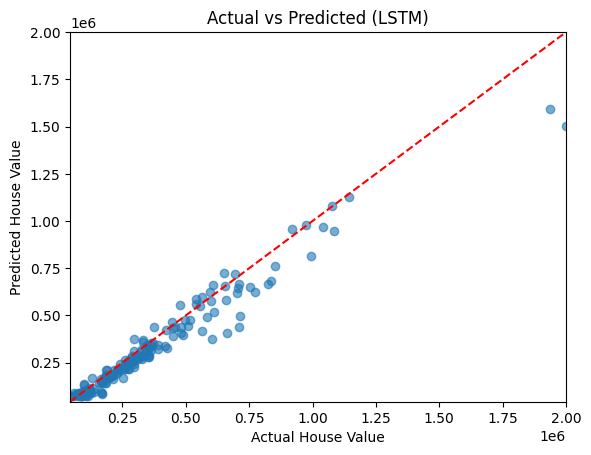


--- Running Trial 23 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


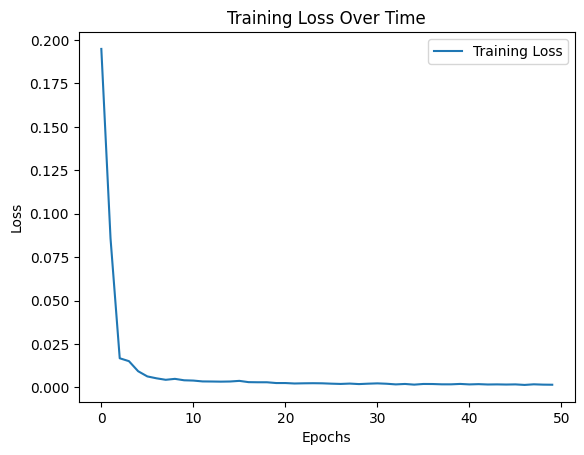

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


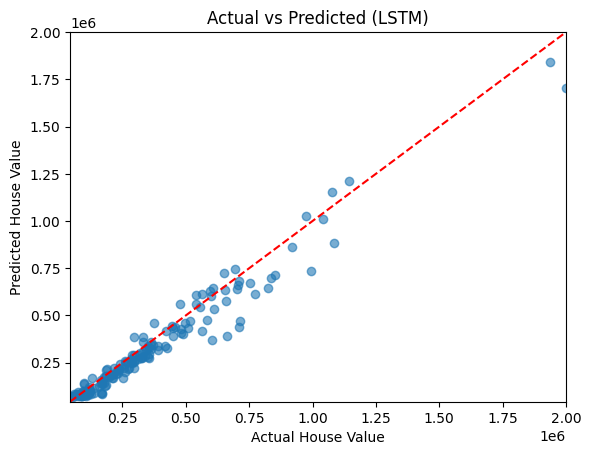


--- Running Trial 24 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


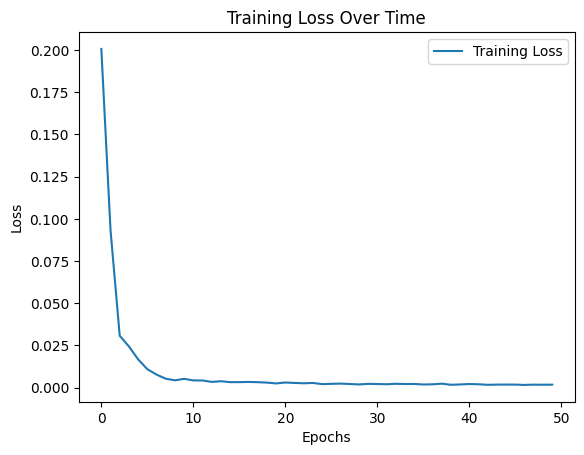

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


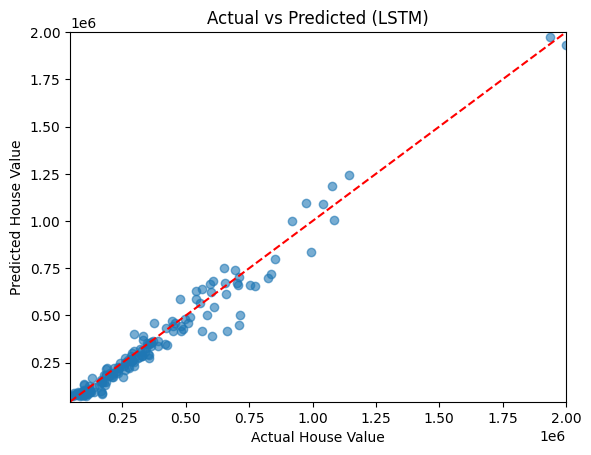


--- Running Trial 25 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


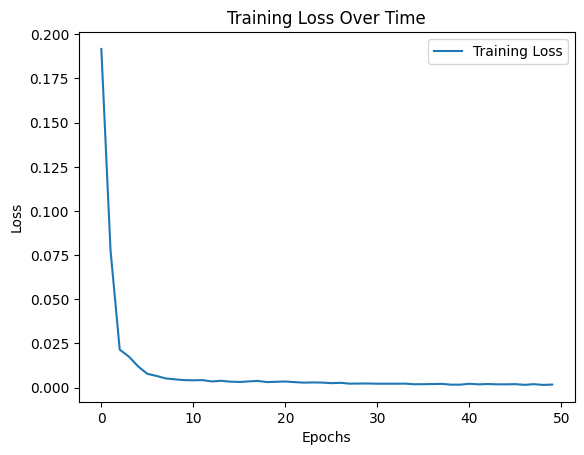

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


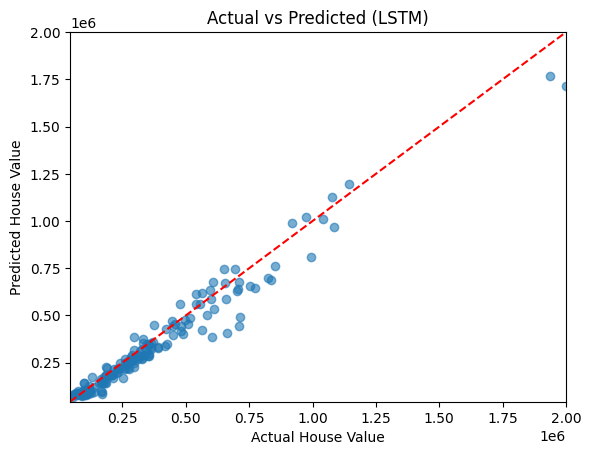


--- Running Trial 26 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


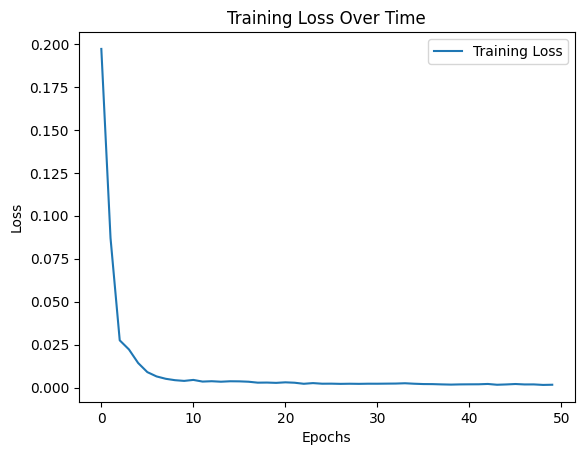

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


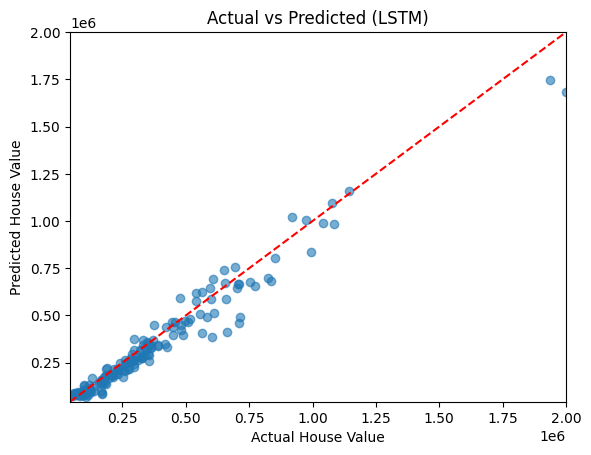


--- Running Trial 27 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


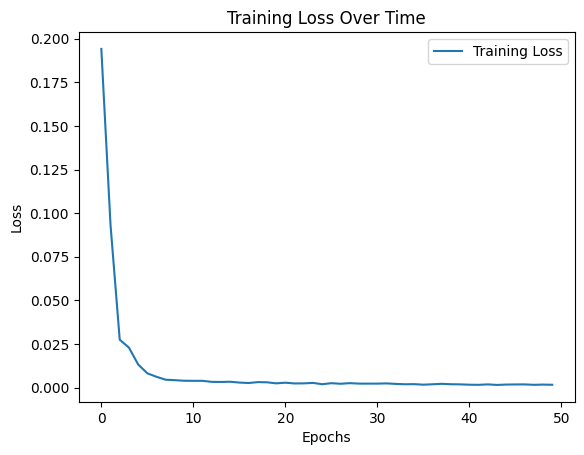

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


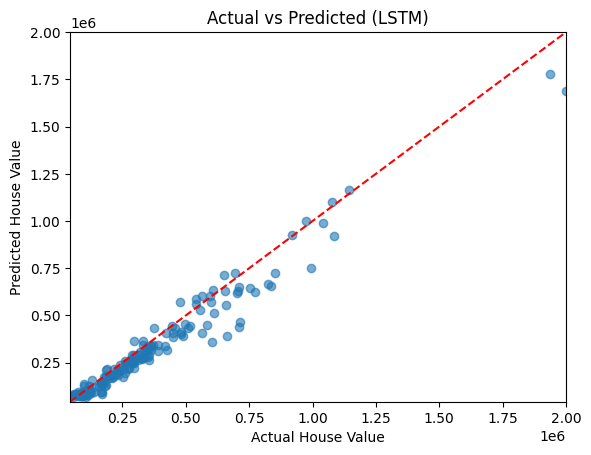


--- Running Trial 28 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


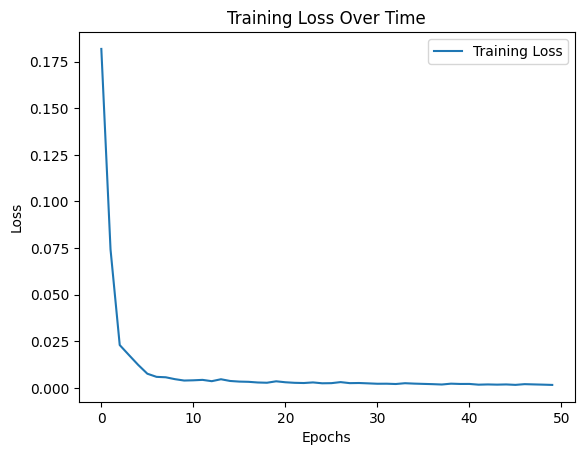

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


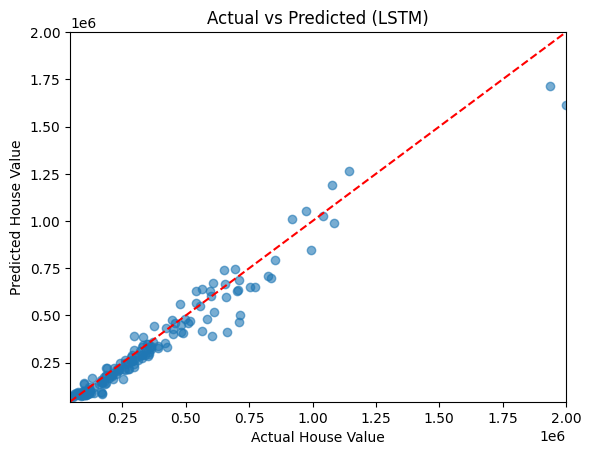


--- Running Trial 29 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


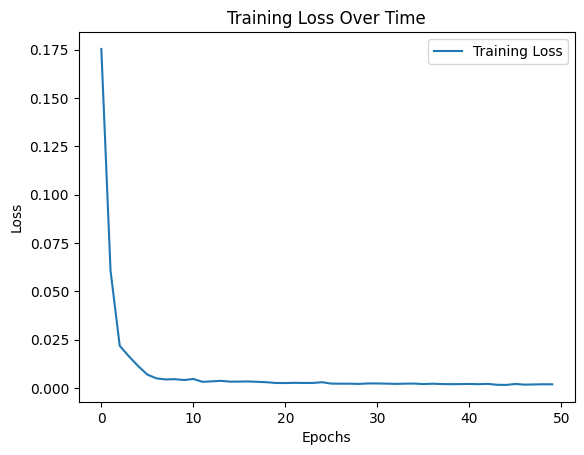

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


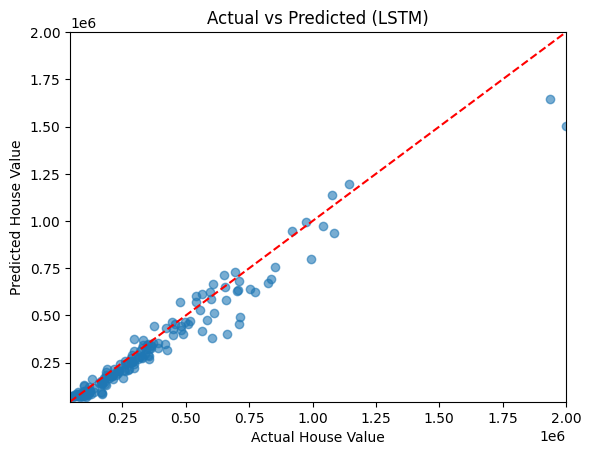


--- Running Trial 30 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


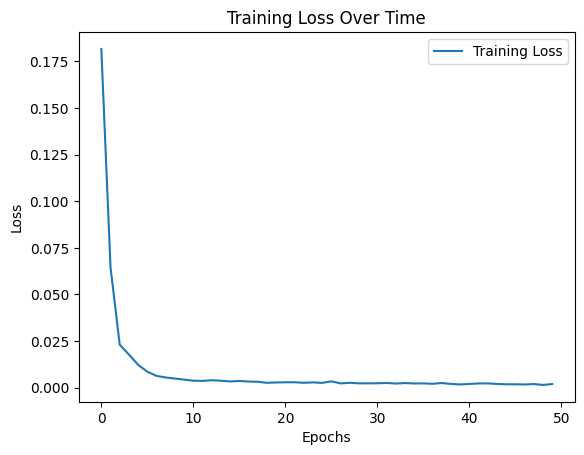

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


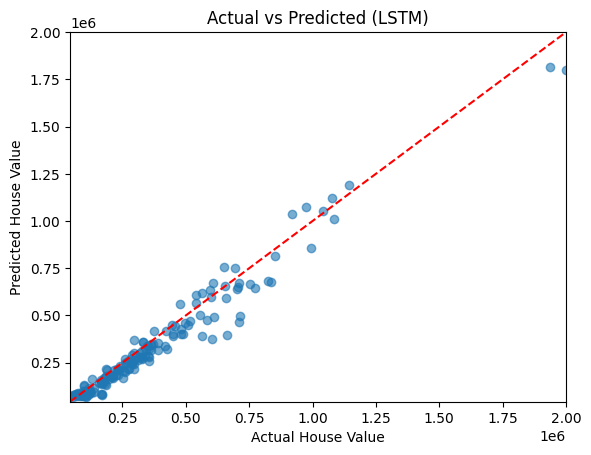


--- Average Metrics Across Trials ---
Average MAE: 45415.17
Average RMSE: 70038.51
Average R²: 0.946

--- Standard Deviation Across Trials ---
MAE SD: 3103.16
RMSE SD: 7021.05
R² SD: 0.011


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- LOCK RANDOMNESS FOR REPRODUCIBILITY ---
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# --- PARAMETERS ---
sequence_length = 2
features = predictors
train_years = list(range(2012, 2020))
test_years = [2021, 2022]

# --- FUNCTION TO GENERATE SEQUENCES ---
def create_sequences(df, sequence_length, features):
    X_seq, y_seq, years_seq = [], [], []
    tracts = df['Census_Tract'].unique()

    for tract in tracts:
        tract_data = df[df['Census_Tract'] == tract].sort_values('Year')
        tract_features = tract_data[features].values
        tract_target = tract_data['Scaled_House_Value'].values

        if len(tract_target) > sequence_length:
            for i in range(sequence_length, len(tract_target)):
                X_seq.append(tract_features[i-sequence_length:i])
                y_seq.append(tract_target[i])
                years_seq.append(tract_data['Year'].values[i])

    return np.array(X_seq), np.array(y_seq), np.array(years_seq)

X_seq, y_seq, years_seq = create_sequences(merged_data, sequence_length, features)

# --- SPLIT INTO TRAIN AND TEST ---
train_mask = np.isin(years_seq, train_years)
test_mask = np.isin(years_seq, test_years)

X_train, y_train = X_seq[train_mask], y_seq[train_mask]
X_test, y_test = X_seq[test_mask], y_seq[test_mask]

# --- FUNCTION TO TRAIN AND EVALUATE LSTM ---
def train_and_evaluate_lstm(X_train, y_train, X_test, y_test, house_value_scaler):
    model = Sequential()

    # First LSTM
    model.add(LSTM(16, return_sequences=True, input_shape=(sequence_length, len(features))))
    model.add(Dropout(0.2))

    # Second LSTM
    # model.add(LSTM(128, return_sequences=True))
    # model.add(Dropout(0.0))

    # Third LSTM
    model.add(LSTM(112, return_sequences=False))
    model.add(Dropout(0.0))

    # Output
    model.add(Dense(1))

    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001020044518434461),
                  loss='mean_squared_error')

    # Train
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Optional: Plot loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

    # Predict and inverse transform
    y_pred_scaled = model.predict(X_test)
    y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled).flatten()
    y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    y_pred_original = np.expm1(y_pred_inv_scaled)
    y_test_original = np.expm1(y_test_inv_scaled)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    # Scatter plot
    lims = [min(min(y_test_original), min(y_pred_original)), max(max(y_test_original), max(y_pred_original))]
    plt.scatter(y_test_original, y_pred_original, alpha=0.6)
    plt.plot(lims, lims, color='red', linestyle='--')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel("Actual House Value")
    plt.ylabel("Predicted House Value")
    plt.title("Actual vs Predicted (LSTM)")
    plt.show()

    return rmse, mae, r2

# --- MULTIPLE TRIALS ---
n_trials = 30
all_rmse, all_mae, all_r2 = [], [], []

for trial in range(n_trials):
    print(f"\n--- Running Trial {trial + 1} ---")
    rmse, mae, r2 = train_and_evaluate_lstm(X_train, y_train, X_test, y_test, house_value_scaler)
    all_rmse.append(rmse)
    all_mae.append(mae)
    all_r2.append(r2)

# --- SUMMARY ---
avg_rmse = np.mean(all_rmse)
avg_mae = np.mean(all_mae)
avg_r2 = np.mean(all_r2)

std_rmse = np.std(all_rmse)
std_mae = np.std(all_mae)
std_r2 = np.std(all_r2)

print("\n--- Average Metrics Across Trials ---")
print(f"Average MAE: {avg_mae:.2f}")
print(f"Average RMSE: {avg_rmse:.2f}")
print(f"Average R²: {avg_r2:.3f}")

print("\n--- Standard Deviation Across Trials ---")
print(f"MAE SD: {std_mae:.2f}")
print(f"RMSE SD: {std_rmse:.2f}")
print(f"R² SD: {std_r2:.3f}")


# XGBoost

In [ ]:
import itertools
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb

# Assume X_train and y_train currently contain 2014–2020
# Split out 2020 as validation set
val_year = 2020

X_val = X_train[merged_data['Year'] == val_year]
y_val = y_train[merged_data['Year'] == val_year]

X_train_sub = X_train[merged_data['Year'] < val_year]
y_train_sub = y_train[merged_data['Year'] < val_year]

/tmp/ipython-input-3203282783.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val = X_train[merged_data['Year'] == val_year]
/tmp/ipython-input-3203282783.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_sub = X_train[merged_data['Year'] < val_year]


## Model v1

In [ ]:
# Define the path to the .csv file in Google Drive
file_path = dir + 'median_household_income_and_median_house_value.csv'
file_path2 = dir + 'race_populations_percentages.csv'
file_path3 = dir + 'educational_attainment_percentages.csv'

# Load the data
data = pd.read_csv(file_path)
data2 = pd.read_csv(file_path2)
data3 = pd.read_csv(file_path3)

race_types = ['White_Population','Black_Population','Native_Population','Asian_Population','Hawaiian_Population','Other_Population','Two_Population']
edu_types = ['NoEdu_Population', 'NurseryEdu_Population', 'KindergartenEdu_Population', '1stEdu_Population', '2ndEdu_Population',
             '3rdEdu_Population', '4thEdu_Population', '5thEdu_Population', '6thEdu_Population', '7thEdu_Population', '8thEdu_Population', '9thEdu_Population',
             '10thEdu_Population', '11thEdu_Population', '12thEdu_Population', 'HighSchoolEdu_Population', 'GEDEdu_Population', 'College1Edu_Population',
             'College2Edu_Population', 'AssociateEdu_Population', 'BachelorEdu_Population', 'MasterEdu_Population', 'ProfessionalEdu_Population', 'DoctorateEdu_Population']

In [ ]:
# Reshape datasets from wide to long format
house_value_data_long = reshape_wide_to_long(data, 'Median_House_Value', range(2012, 2023))
hh_income_data_long = reshape_wide_to_long(data, 'Median_Household_Income', range(2012, 2023))
race_pop_data_long = reshape_wide_to_long_multiple_fields(data2, race_types, range(2012, 2023))
edu_data_long = reshape_wide_to_long_multiple_fields(data3, edu_types, range(2012, 2023))

# Fill in NA values with averages or previous/forward values
house_value_data_long = fill_missing_values(house_value_data_long, 'Median_House_Value')
hh_income_data_long = fill_missing_values(hh_income_data_long, 'Median_Household_Income')
race_pop_data_long = fill_missing_values_multiple_fields(race_pop_data_long, race_types)
edu_data_long = fill_missing_values_multiple_fields(edu_data_long, edu_types)

# Merge the DataFrames based on 'Census_Tract' and 'Year'
merged_data = pd.merge(house_value_data_long, hh_income_data_long, on=['Census_Tract', 'Year'])
merged_data = pd.merge(merged_data, race_pop_data_long, on=['Census_Tract', 'Year'])
merged_data = pd.merge(merged_data, edu_data_long, on=['Census_Tract', 'Year'])

# Sort data by Census_Tract and Year
merged_data = merged_data.sort_values(['Census_Tract', 'Year'])

# Create a lag feature for Median_House_Value by Census_Tract
merged_data['Median_House_Value_lag1'] = merged_data.groupby('Census_Tract')['Median_House_Value'].shift(1)

# Drop rows with NaN lag (these are first years per Census_Tract)
merged_data = merged_data.dropna(subset=['Median_House_Value_lag1']).reset_index(drop=True)

print(merged_data.head())

   Census_Tract  Year  Median_House_Value  Median_Household_Income  \
0           100  2013             89400.0                  32943.0   
1           100  2014             84200.0                  32368.0   
2           100  2015             88500.0                  31042.0   
3           100  2016             90500.0                  32266.0   
4           100  2017             95000.0                  32462.0   

   White_Population  Black_Population  Native_Population  Asian_Population  \
0          0.574278          0.175350                0.0          0.041381   
1          0.587051          0.183086                0.0          0.049566   
2          0.587258          0.153278                0.0          0.063096   
3          0.629767          0.191318                0.0          0.062636   
4          0.645900          0.219962                0.0          0.055308   

   Hawaiian_Population  Other_Population  ...  HighSchoolEdu_Population  \
0                  0.0          0.2

In [ ]:
# Prepare data
exclude = ['White_Population', 'HighSchoolEdu_Population']
features = ["Median_Household_Income", "Median_House_Value_lag1"] + \
           [col for col in race_types if col not in exclude] + \
           [col for col in edu_types if col not in exclude]

X = merged_data[features]
y = merged_data["Median_House_Value"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.preprocessing import MinMaxScaler

# Log transform target (adding 1 to avoid log(0))
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

house_value_scaler = MinMaxScaler()

y_train_scaled = house_value_scaler.fit_transform(y_train_log.values.reshape(-1, 1)).flatten()
y_test_scaled = house_value_scaler.transform(y_test_log.values.reshape(-1, 1)).flatten()


from sklearn.preprocessing import StandardScaler

# Continuous features to scale
continuous_features = ["Median_Household_Income", "Median_House_Value_lag1"]

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale continuous features
X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.85, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2.0]
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train_scaled)

print("Best parameters found:", random_search.best_params_)

best_model = random_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.85, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on test set (scaled log values)
y_pred_scaled = best_model.predict(X_test_scaled)

# Inverse MinMax scaling
y_pred_log = house_value_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

# Undo log transform (exp(x) - 1)
y_pred = np.expm1(y_pred_log)

# Inverse transform actual target
y_test_log_inv = house_value_scaler.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()
y_true = np.expm1(y_test_log_inv)

# Metrics on original scale
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


MAE: 20370.96
RMSE: 60140.89
R²: 0.964


## Model v2 (hyperparameter tuning)

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import xgboost as xgb
# import matplotlib.pyplot as plt

# # Assuming you have your data already loaded in merged_data

# # 3. Scale numerical features (only Median_Household_Income here)
# scaler = StandardScaler()
# X_train_scaled = X_train.copy()
# X_test_scaled = X_test.copy()

# X_train_scaled["Scaled_Household_Income"] = scaler.fit_transform(X_train[["Scaled_Household_Income"]])
# X_test_scaled["Scaled_Household_Income"] = scaler.transform(X_test[["Scaled_Household_Income"]])

# 4. XGBoost regressor with hyperparameter tuning

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.85, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2.0]
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters found:", random_search.best_params_)

best_model = random_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.85, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


## Model v3 (early stopping with val set)

In [ ]:
# Assume X_train and y_train currently contain 2014–2020
# Split out 2020 as validation set
val_year = 2020

X_val = X_train[merged_data['Year'] == val_year]
y_val = y_train[merged_data['Year'] == val_year]

X_train_sub = X_train[merged_data['Year'] < val_year]
y_train_sub = y_train[merged_data['Year'] < val_year]

# Set up XGBoost with early stopping
import xgboost as xgb

# Create DMatrices
dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval = xgb.DMatrix(X_val, label=y_val)

# Parameters
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 5,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "reg_alpha": 0.1,
    "reg_lambda": 1.5,
    "seed": 42
}

# Train with early stopping
evals = [(dtrain, "train"), (dval, "validation")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

print("Best iteration (number of trees):", bst.best_iteration)




[0]	train-rmse:0.18073	validation-rmse:0.18931
[1]	train-rmse:0.17227	validation-rmse:0.18073
[2]	train-rmse:0.16429	validation-rmse:0.17271
[3]	train-rmse:0.15674	validation-rmse:0.16514
[4]	train-rmse:0.14952	validation-rmse:0.15800
[5]	train-rmse:0.14266	validation-rmse:0.15145
[6]	train-rmse:0.13606	validation-rmse:0.14491


/tmp/ipython-input-1928649074.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val = X_train[merged_data['Year'] == val_year]
/tmp/ipython-input-1928649074.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_sub = X_train[merged_data['Year'] < val_year]


[7]	train-rmse:0.12978	validation-rmse:0.13866
[8]	train-rmse:0.12388	validation-rmse:0.13343
[9]	train-rmse:0.11832	validation-rmse:0.12829
[10]	train-rmse:0.11305	validation-rmse:0.12333
[11]	train-rmse:0.10793	validation-rmse:0.11888
[12]	train-rmse:0.10304	validation-rmse:0.11419
[13]	train-rmse:0.09849	validation-rmse:0.11020
[14]	train-rmse:0.09421	validation-rmse:0.10608
[15]	train-rmse:0.08999	validation-rmse:0.10231
[16]	train-rmse:0.08604	validation-rmse:0.09885
[17]	train-rmse:0.08225	validation-rmse:0.09547
[18]	train-rmse:0.07867	validation-rmse:0.09235
[19]	train-rmse:0.07530	validation-rmse:0.08951
[20]	train-rmse:0.07214	validation-rmse:0.08681
[21]	train-rmse:0.06906	validation-rmse:0.08424
[22]	train-rmse:0.06615	validation-rmse:0.08201
[23]	train-rmse:0.06339	validation-rmse:0.07951
[24]	train-rmse:0.06078	validation-rmse:0.07736
[25]	train-rmse:0.05832	validation-rmse:0.07521
[26]	train-rmse:0.05592	validation-rmse:0.07303
[27]	train-rmse:0.05365	validation-rmse:0.0

## Model v4 (hyperparameter tuning with best number of trees)

In [ ]:
import itertools
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb

# Assume X_train and y_train currently contain 2014–2020
# Split out 2020 as validation set
val_year = 2020

X_val = X_train[merged_data['Year'] == val_year]
y_val = y_train[merged_data['Year'] == val_year]

X_train_sub = X_train[merged_data['Year'] < val_year]
y_train_sub = y_train[merged_data['Year'] < val_year]

# Define candidate values for tuning
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2.0]
}

# Generate all combinations
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_rmse = float("inf")
best_params = None
best_bst = None

for i, params_candidate in enumerate(param_combinations):
    # Add static parameters
    params_candidate["objective"] = "reg:squarederror"
    params_candidate["seed"] = 42

    # Train
    bst_candidate = xgb.train(
        params=params_candidate,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Predict on validation set
    y_val_pred = bst_candidate.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params_candidate
        best_bst = bst_candidate

    print(f"Trial {i+1}/{len(param_combinations)}: RMSE={rmse:.2f}")

print("Best RMSE:", best_rmse)
print("Best hyperparameters:", best_params)
print("Best iteration (number of trees):", best_bst.best_iteration)

"""
Best RMSE: 0.03529012209550282
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0, 'reg_lambda': 1.5, 'objective': 'reg:squarederror', 'seed': 42}
Best iteration (number of trees): 77
"""


/tmp/ipython-input-900107245.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val = X_train[merged_data['Year'] == val_year]
/tmp/ipython-input-900107245.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_sub = X_train[merged_data['Year'] < val_year]


Trial 1/729: RMSE=0.04
Trial 2/729: RMSE=0.04
Trial 3/729: RMSE=0.04
Trial 4/729: RMSE=0.04
Trial 5/729: RMSE=0.04
Trial 6/729: RMSE=0.04
Trial 7/729: RMSE=0.04
Trial 8/729: RMSE=0.04
Trial 9/729: RMSE=0.04
Trial 10/729: RMSE=0.04
Trial 11/729: RMSE=0.04
Trial 12/729: RMSE=0.04
Trial 13/729: RMSE=0.04
Trial 14/729: RMSE=0.04
Trial 15/729: RMSE=0.04
Trial 16/729: RMSE=0.04
Trial 17/729: RMSE=0.04
Trial 18/729: RMSE=0.04
Trial 19/729: RMSE=0.04
Trial 20/729: RMSE=0.04
Trial 21/729: RMSE=0.04
Trial 22/729: RMSE=0.04
Trial 23/729: RMSE=0.04
Trial 24/729: RMSE=0.04
Trial 25/729: RMSE=0.04
Trial 26/729: RMSE=0.04
Trial 27/729: RMSE=0.04
Trial 28/729: RMSE=0.04
Trial 29/729: RMSE=0.04
Trial 30/729: RMSE=0.04
Trial 31/729: RMSE=0.04
Trial 32/729: RMSE=0.04
Trial 33/729: RMSE=0.04
Trial 34/729: RMSE=0.04
Trial 35/729: RMSE=0.04
Trial 36/729: RMSE=0.04
Trial 37/729: RMSE=0.04
Trial 38/729: RMSE=0.04
Trial 39/729: RMSE=0.04
Trial 40/729: RMSE=0.04
Trial 41/729: RMSE=0.04
Trial 42/729: RMSE=0.04
T

In [ ]:
# Assume X_train and y_train currently contain 2014–2020
# Split out 2020 as validation set
val_year = 2020

X_val = X_train[merged_data['Year'] == val_year]
y_val = y_train[merged_data['Year'] == val_year]

X_train_sub = X_train[merged_data['Year'] < val_year]
y_train_sub = y_train[merged_data['Year'] < val_year]

# Set up XGBoost with early stopping
import xgboost as xgb

# Create DMatrices
dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval = xgb.DMatrix(X_val, label=y_val)

# Best parameters from tuning
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 3,
    "subsample": 0.7,
    "colsample_bytree": 1.0,
    "reg_alpha": 0,
    "reg_lambda": 1.5,
    "seed": 42
}

# Train with early stopping
evals = [(dtrain, "train"), (dval, "validation")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=77,   # from best iteration
    evals=evals,
    verbose_eval=True
)

print("Model trained with tuned parameters.")





/tmp/ipython-input-1904349490.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val = X_train[merged_data['Year'] == val_year]
/tmp/ipython-input-1904349490.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_sub = X_train[merged_data['Year'] < val_year]


[0]	train-rmse:0.17206	validation-rmse:0.18081
[1]	train-rmse:0.15609	validation-rmse:0.16498
[2]	train-rmse:0.14166	validation-rmse:0.15041
[3]	train-rmse:0.12874	validation-rmse:0.13729
[4]	train-rmse:0.11695	validation-rmse:0.12552
[5]	train-rmse:0.10643	validation-rmse:0.11518
[6]	train-rmse:0.09677	validation-rmse:0.10546
[7]	train-rmse:0.08818	validation-rmse:0.09703
[8]	train-rmse:0.08031	validation-rmse:0.08981
[9]	train-rmse:0.07341	validation-rmse:0.08319
[10]	train-rmse:0.06728	validation-rmse:0.07729
[11]	train-rmse:0.06143	validation-rmse:0.07196
[12]	train-rmse:0.05626	validation-rmse:0.06763
[13]	train-rmse:0.05163	validation-rmse:0.06346
[14]	train-rmse:0.04755	validation-rmse:0.06022
[15]	train-rmse:0.04381	validation-rmse:0.05727
[16]	train-rmse:0.04035	validation-rmse:0.05481
[17]	train-rmse:0.03718	validation-rmse:0.05228
[18]	train-rmse:0.03442	validation-rmse:0.05025
[19]	train-rmse:0.03198	validation-rmse:0.04852
[20]	train-rmse:0.02976	validation-rmse:0.04677
[2

## Model v5 (training on all data with tuned parameters, no validation)

In [ ]:
import xgboost as xgb

# Create full DMatrix
dtrain_full = xgb.DMatrix(X_train, label=y_train)

# Tuned parameters
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 3,
    "subsample": 0.7,
    "colsample_bytree": 1.0,
    "reg_alpha": 0,
    "reg_lambda": 1.5,
    "seed": 42
}

# Retrain on all data with best num_boost_round
final_model = xgb.train(
    params=params,
    dtrain=dtrain_full,
    num_boost_round=77,
    verbose_eval=False
)

print("✅ Final model trained on all data.")


✅ Final model trained on all data.


## Model v6 (more hyperparameter tuning!)

- Deeper trees (higher max_depth)
- Smaller learning_rate steps
- squarederror and absolute error loss function to be more robust to outliers

In [ ]:
import itertools
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Validation split (keep 2020 for validation)
val_year = 2020
X_val = X_train[merged_data['Year'] == val_year]
y_val = y_train[merged_data['Year'] == val_year]
X_train_sub = X_train[merged_data['Year'] < val_year]
y_train_sub = y_train[merged_data['Year'] < val_year]

# Create DMatrices
dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval = xgb.DMatrix(X_val, label=y_val)

# Parameter grid
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 1.5, 2],
    "objective": ["reg:squarederror", "reg:absoluteerror"],
    "seed": [42]
}

best_rmse = float("inf")
best_params = None
best_num_boost_round = None

# Loop through all combinations
for combo in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), combo))

    evals = [(dtrain, "train"), (dval, "validation")]
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params
        best_num_boost_round = model.best_iteration

print("Best RMSE:", best_rmse)
print("Best parameters:", best_params)
print("Best num_boost_round:", best_num_boost_round)


/tmp/ipython-input-2518518082.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val = X_train[merged_data['Year'] == val_year]
/tmp/ipython-input-2518518082.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_sub = X_train[merged_data['Year'] < val_year]


Best RMSE: 0.03503372879807145
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0, 'reg_lambda': 1, 'objective': 'reg:squarederror', 'seed': 42}
Best num_boost_round: 84


In [ ]:
# Train on all data
dtrain_full = xgb.DMatrix(X_train, label=y_train)
final_model = xgb.train(
    params=best_params,
    dtrain=dtrain_full,
    num_boost_round=best_num_boost_round
)

## Model v7 (training on all data with tuned parameters #2)

In [ ]:
import xgboost as xgb

# Combine all training years now that validation is done
dtrain_full = xgb.DMatrix(X_train, label=y_train)

# Best parameters from tuning
best_params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "seed": 42
}

# Retrain with best boosting rounds
bst_final = xgb.train(
    params=best_params,
    dtrain=dtrain_full,
    num_boost_round=84,  # from tuning
    verbose_eval=True
)

# # Predict on your test set (replace X_test/y_test with your actual test data)
# dtest = xgb.DMatrix(X_test)
# y_pred_xgb = bst_final.predict(dtest)

# # Evaluate
# from sklearn.metrics import mean_squared_error
# import numpy as np

# rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
# print("Final XGBoost RMSE:", rmse)


## Model v8 (training on all data with tuned parameters #3)

- using unscaled log target
- tuned parameters from v6 and v7
- deeper tree
- robust loss (pseudohubererror)

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- STEP 1: Use unscaled log target ---
# y_train_log = merged_data.loc[merged_data['Year'] < 2021, 'Log_House_Value']  # example year filter
# y_test_log = merged_data.loc[merged_data['Year'] == 2021, 'Log_House_Value']  # adjust as needed

# X_train, X_test should match these y sets
# Make sure they are aligned before proceeding

# --- STEP 2: Create DMatrices ---
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# --- STEP 3: Tuned baseline params ---
base_params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "seed": 42
}

# --- STEP 4: Try baseline and two tweaks ---
param_sets = {
    "baseline": base_params,
    "deeper": {**base_params, "max_depth": 5},
    "robust_loss": {**base_params, "objective": "reg:pseudohubererror"}
}

results = []

for label, params in param_sets.items():
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=200,
        evals=[(dtrain, "train"), (dtest, "test")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Predict in log space
    y_pred = model.predict(dtest, iteration_range=(0, model.best_iteration))

    # Clip predictions to avoid overflow in expm1
    y_pred_clipped = np.clip(y_pred, a_min=None, a_max=15)  # 15 ≈ $3.26 million

    # Inverse log transform to get back to dollars
    y_pred_dollars = np.expm1(y_pred_clipped)
    y_test_dollars = np.expm1(y_test)

    # Metrics in dollar space
    mae = mean_absolute_error(y_test_dollars, y_pred_dollars)
    rmse = np.sqrt(mean_squared_error(y_test_dollars, y_pred_dollars))
    r2 = r2_score(y_test_dollars, y_pred_dollars)

    results.append({
        "Model": label,
        "Best Iter": model.best_iteration,
        "MAE ($)": mae,
        "RMSE ($)": rmse,
        "R²": r2
    })

# View results
results_df = pd.DataFrame(results)
print(results_df)


         Model  Best Iter       MAE ($)      RMSE ($)          R²
0     baseline         53  2.496827e+04  6.057846e+04    0.956976
1       deeper         84  2.751489e+04  7.701702e+04    0.930458
2  robust_loss          0  2.923023e+06  2.937577e+06 -100.170522


## Model v9 (Optuna tuning)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 24.1 MB/s eta 0:00:00


[I 2025-08-17 03:36:26,480] A new study created in memory with name: no-name-a58aa2c2-8beb-4c88-bd3b-743386d95133
/tmp/ipython-input-3005440318.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
/tmp/ipython-input-3005440318.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
/tmp/ipython-input-3005440318.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2025-08-17 03:36:26,720] Trial 0 finished with value: 0.17296719551206532 and parameters: {'learning_rate': 0.010713357842289559, 'max_depth': 5, 'min_child_

Best hyperparameters: {'learning_rate': 0.007243219719715213, 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.5896164095197313, 'colsample_bytree': 0.512198655011516, 'gamma': 0.004650828565555491, 'reg_alpha': 0.056390439903480645, 'reg_lambda': 0.04418482287741244}
[0]	train-rmse:0.18984	test-rmse:0.20438
[100]	train-rmse:0.09637	test-rmse:0.11134
[200]	train-rmse:0.05244	test-rmse:0.06911
[300]	train-rmse:0.03250	test-rmse:0.05067
[400]	train-rmse:0.02429	test-rmse:0.04280
[500]	train-rmse:0.02121	test-rmse:0.03949
[600]	train-rmse:0.02014	test-rmse:0.03804
[700]	train-rmse:0.01969	test-rmse:0.03733
[800]	train-rmse:0.01949	test-rmse:0.03697
[900]	train-rmse:0.01933	test-rmse:0.03666
[1000]	train-rmse:0.01926	test-rmse:0.03650
[1100]	train-rmse:0.01922	test-rmse:0.03642
[1200]	train-rmse:0.01917	test-rmse:0.03633
[1300]	train-rmse:0.01911	test-rmse:0.03621
[1351]	train-rmse:0.01909	test-rmse:0.03621
MAE: 37466.28
RMSE: 90349.89
R²: 0.910


<Figure size 1000x600 with 0 Axes>

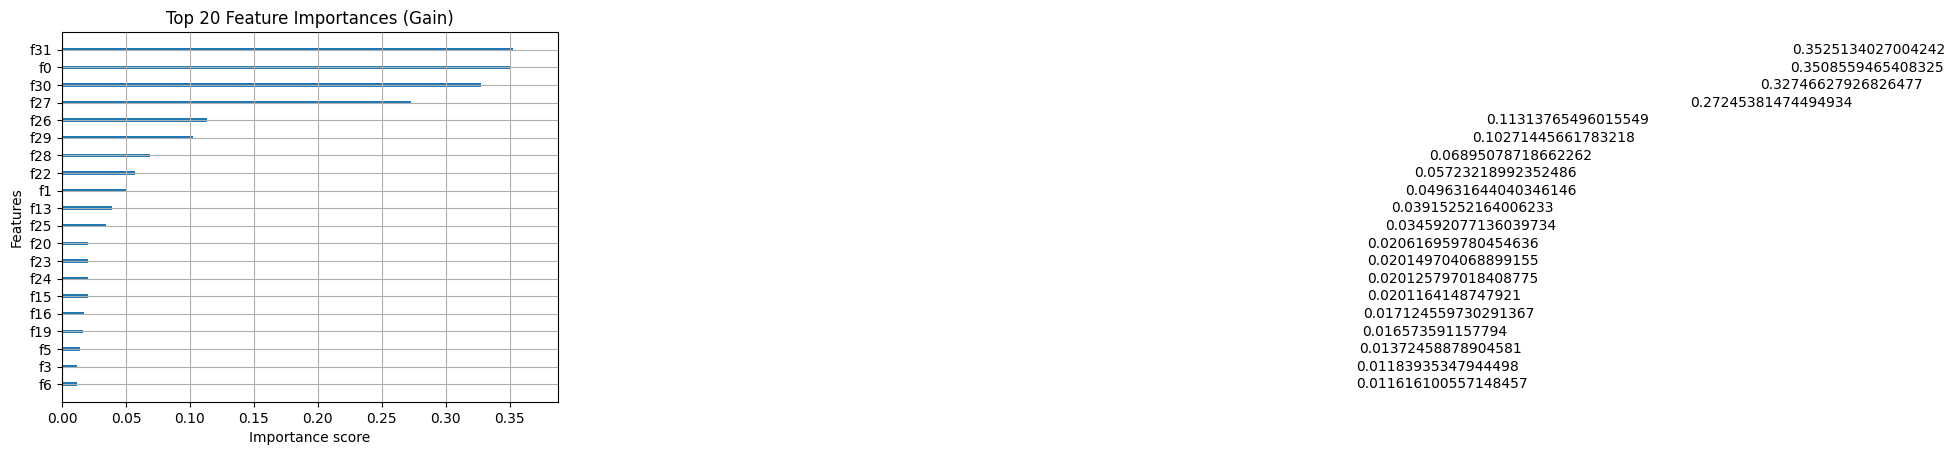

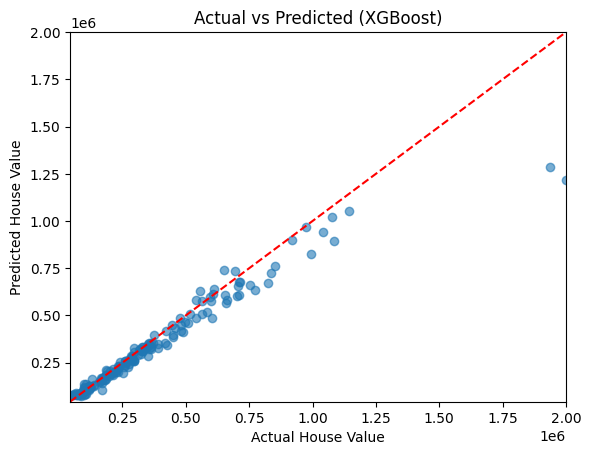

In [ ]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ---------------------------
# Data Setup
# ---------------------------
train_years = list(range(2014, 2020))   # Train: 2014–2019
val_years = [2020]                      # Validation: 2020
test_years = [2021, 2022]               # Final test
features = predictors

train_df = merged_data[merged_data['Year'].isin(train_years)]
val_df = merged_data[merged_data['Year'].isin(val_years)]
test_df = merged_data[merged_data['Year'].isin(test_years)]

X_train = train_df[features].values
y_train = train_df['Scaled_House_Value'].values
X_val = val_df[features].values
y_val = val_df['Scaled_House_Value'].values
X_test = test_df[features].values
y_test = test_df['Scaled_House_Value'].values

# ---------------------------
# Objective Function for Optuna
# ---------------------------
def objective(trial):
    params = {
        "booster": "gbtree",
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "seed": 42
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        evals=[(dtrain, "train"), (dval, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# ---------------------------
# Run Optuna Optimization
# ---------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

best_params = study.best_params
print("Best hyperparameters:", best_params)

# ---------------------------
# Train Final Model on Train+Val (2014–2020)
# ---------------------------
trainval_df = merged_data[merged_data['Year'].isin(train_years + val_years)]
X_trainval = trainval_df[features].values
y_trainval = trainval_df['Scaled_House_Value'].values

dtrainval = xgb.DMatrix(X_trainval, label=y_trainval)
dtest = xgb.DMatrix(X_test, label=y_test)

final_model = xgb.train(
    best_params,
    dtrainval,
    num_boost_round=2000,
    evals=[(dtrainval, "train"), (dtest, "test")],
    early_stopping_rounds=50,
    verbose_eval=100
)

# ---------------------------
# Final Evaluation (Inverse Transform + Log Undo)
# ---------------------------
# Predictions on scaled space
y_pred_scaled = final_model.predict(dtest)

# Inverse transform to original scale
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Undo log-transform
y_pred_original = np.expm1(y_pred_inv_scaled)
y_test_original = np.expm1(y_test_inv_scaled)

# Metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# ---------------------------
# Plots
# ---------------------------
# Feature importance
plt.figure(figsize=(10,6))
xgb.plot_importance(final_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (Gain)")
plt.show()

# Actual vs Predicted
lims = [
    min(min(y_test_original), min(y_pred_original)),
    max(max(y_test_original), max(y_pred_original))
]

plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (XGBoost)")
plt.show()


## Model v10 (Hyperparameter Tuning with Optuna Tuner and Walk-Forward CV)

[I 2025-08-17 04:27:06,541] A new study created in memory with name: no-name-bb2dcf64-3920-4017-b2a9-40a6303d8efb
[I 2025-08-17 04:27:08,257] Trial 0 finished with value: 0.20680444472186763 and parameters: {'learning_rate': 0.013875209528217775, 'max_depth': 11, 'min_child_weight': 9, 'subsample': 0.9095006238435681, 'colsample_bytree': 0.676549376307992, 'gamma': 3.0479032272626445, 'reg_alpha': 1.369635475258039, 'reg_lambda': 2.0456117542060817}. Best is trial 0 with value: 0.20680444472186763.
[I 2025-08-17 04:27:09,479] Trial 1 finished with value: 0.21310486891169975 and parameters: {'learning_rate': 0.1441627725495907, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.674474803740716, 'colsample_bytree': 0.5988114902220252, 'gamma': 4.125623704866682, 'reg_alpha': 0.0031258636316576056, 'reg_lambda': 0.0013150617925172252}. Best is trial 0 with value: 0.20680444472186763.
[I 2025-08-17 04:27:11,519] Trial 2 finished with value: 0.2019984738826504 and parameters: {'learning

Best hyperparameters: {'learning_rate': 0.010809906023806071, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8018838472298855, 'colsample_bytree': 0.7880637245015297, 'gamma': 0.0003688976436750195, 'reg_alpha': 0.07044008359983205, 'reg_lambda': 0.002480810811944202}
[0]	train-rmse:0.18916	test-rmse:0.20371
[100]	train-rmse:0.06900	test-rmse:0.08322
[200]	train-rmse:0.03070	test-rmse:0.04800
[300]	train-rmse:0.01925	test-rmse:0.03880
[400]	train-rmse:0.01532	test-rmse:0.03603
[500]	train-rmse:0.01353	test-rmse:0.03517
[600]	train-rmse:0.01258	test-rmse:0.03473
[700]	train-rmse:0.01215	test-rmse:0.03460
[800]	train-rmse:0.01195	test-rmse:0.03450
[900]	train-rmse:0.01182	test-rmse:0.03443
[1000]	train-rmse:0.01173	test-rmse:0.03442
[1100]	train-rmse:0.01169	test-rmse:0.03440
[1166]	train-rmse:0.01165	test-rmse:0.03439
Test RMSE: 0.13
Test MAE: 0.09
Test R²: 0.972


<Figure size 1000x600 with 0 Axes>

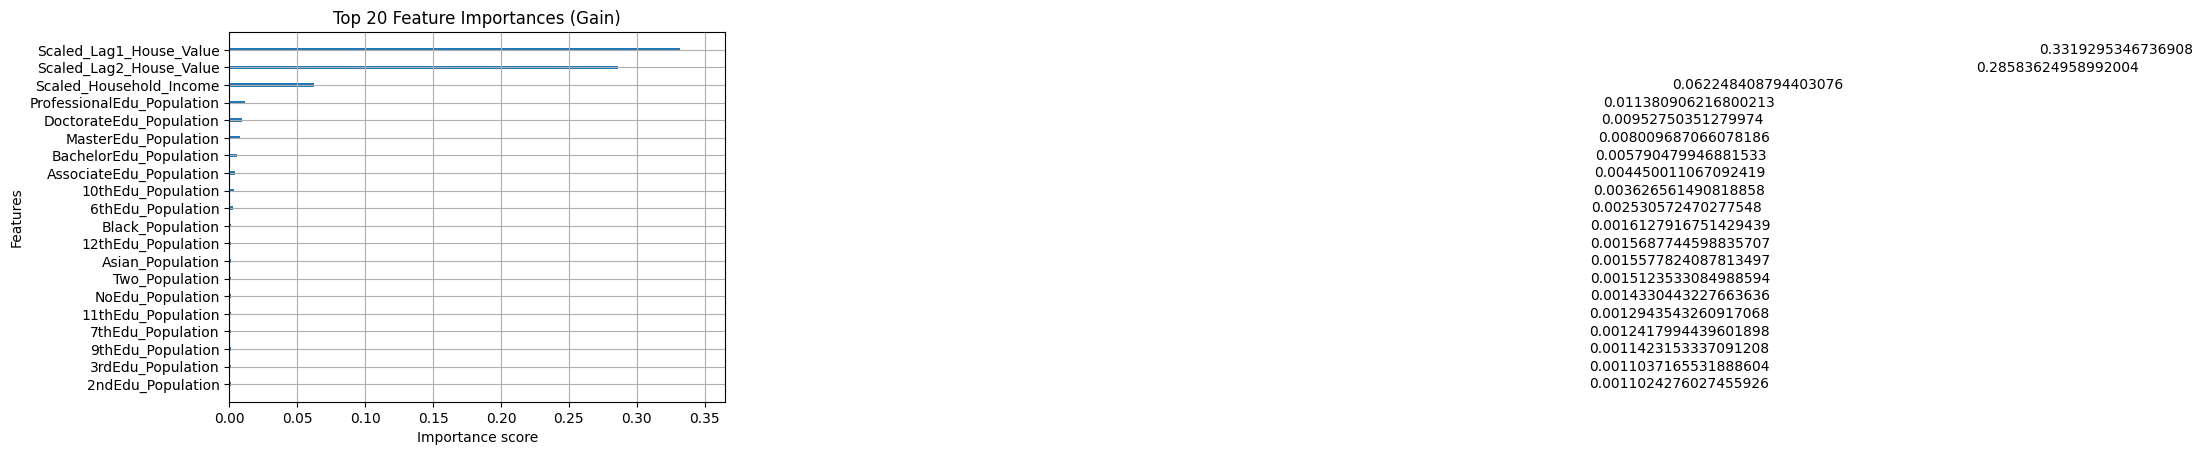

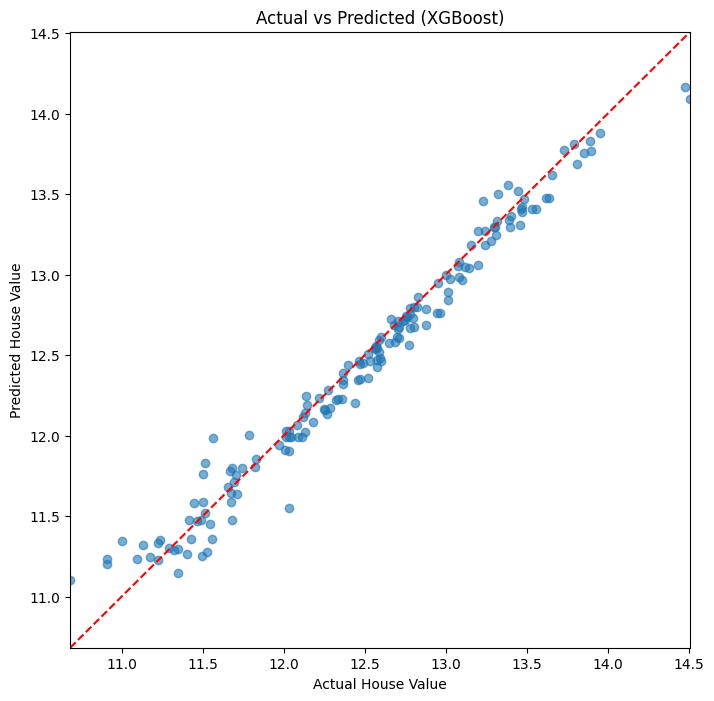

In [ ]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ---------------------------
# Data Setup
# ---------------------------
train_years = list(range(2012, 2020))   # Train+Validation: 2012–2019
val_years = [2020]                      # Validation anchor year
test_years = [2021, 2022]               # Final test
features = predictors

train_df = merged_data[merged_data['Year'].isin(train_years + val_years)]
test_df = merged_data[merged_data['Year'].isin(test_years)]

X_test = test_df[features].values
y_test = test_df['Scaled_House_Value'].values

# ---------------------------
# Custom Year-Based CV Splitter (skips empty val folds)
# ---------------------------
def year_based_cv(train_df, feature_cols, target_col, years):
    years = sorted(years)
    for i in range(1, len(years)):
        train_years = years[:i]
        val_year = years[i]

        train_data = train_df[train_df["Year"].isin(train_years)]
        val_data = train_df[train_df["Year"] == val_year]

        # Skip fold if validation is empty (e.g., due to lags)
        if val_data.shape[0] == 0:
            continue

        X_train_fold = train_data[feature_cols].values
        y_train_fold = train_data[target_col].values
        X_val_fold = val_data[feature_cols].values
        y_val_fold = val_data[target_col].values

        yield X_train_fold, y_train_fold, X_val_fold, y_val_fold

# ---------------------------
# Objective Function for Optuna
# ---------------------------
def objective(trial):
    params = {
        "booster": "gbtree",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "seed": 42
    }

    rmse_scores = []

    # Walk-forward validation across years
    for X_tr, y_tr, X_val, y_val in year_based_cv(train_df, features, "Scaled_House_Value", train_years + val_years):
        dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=features)
        dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=2000,
            evals=[(dtrain, "train"), (dval, "validation")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        preds = model.predict(dval)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))

    return np.mean(rmse_scores)

# ---------------------------
# Run Optuna Optimization
# ---------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

best_params = study.best_params
print("Best hyperparameters:", best_params)

# ---------------------------
# Train Final Model on All Train Data (2012–2020)
# ---------------------------
X_train_full = train_df[features].values
y_train_full = train_df["Scaled_House_Value"].values

dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

final_model = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=2000,
    evals=[(dtrain_full, "train"), (dtest, "test")],
    early_stopping_rounds=50,
    verbose_eval=100
)

# ---------------------------
# Final Evaluation (Inverse Transform)
# ---------------------------
y_pred_scaled = final_model.predict(dtest)

# Inverse transform to original scale
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Undo log-transform
y_pred_original = np.expm1(y_pred_inv_scaled)
y_test_original = np.expm1(y_test_inv_scaled)

# Metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.3f}")

# ---------------------------
# Feature Importance Plot
# ---------------------------
plt.figure(figsize=(10,6))
xgb.plot_importance(final_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (Gain)")
plt.show()

# ---------------------------
# Actual vs Predicted Scatter Plot
# ---------------------------
lims = [min(y_test_orig.min(), preds_orig.min()), max(y_test_orig.max(), preds_orig.max())]

plt.figure(figsize=(8,8))
plt.scatter(y_test_orig, preds_orig, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (XGBoost)")
plt.xlim(lims)
plt.ylim(lims)
plt.show()


## Test Prediction (metrics and plot importance)

MAE: 31366.78
RMSE: 68625.56
R²: 0.948


<Figure size 1000x600 with 0 Axes>

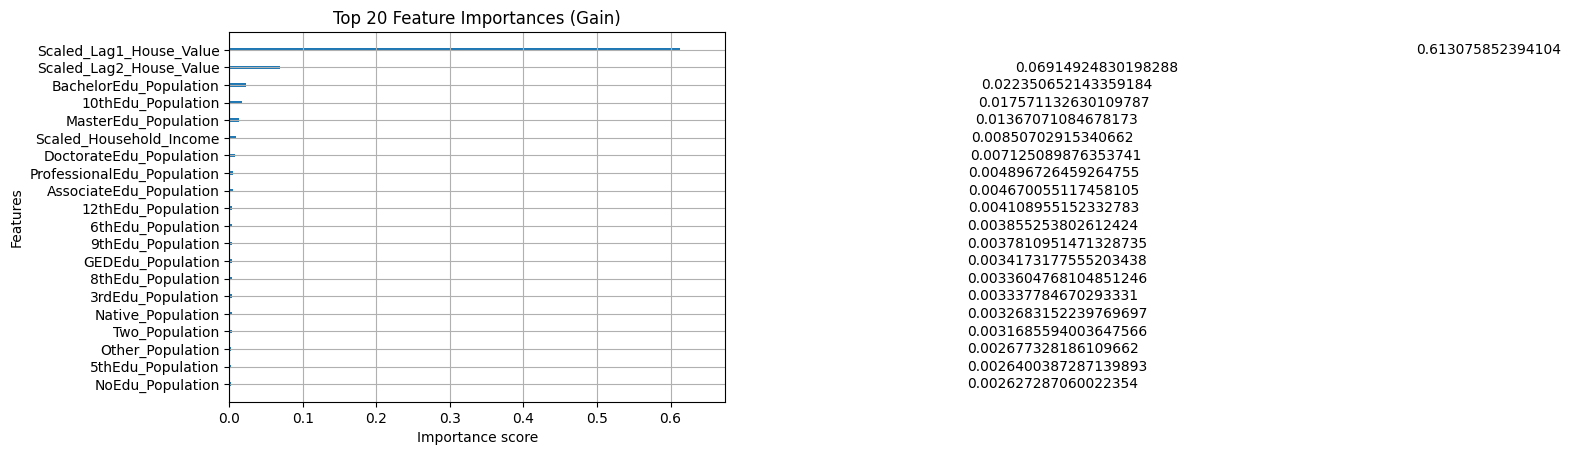

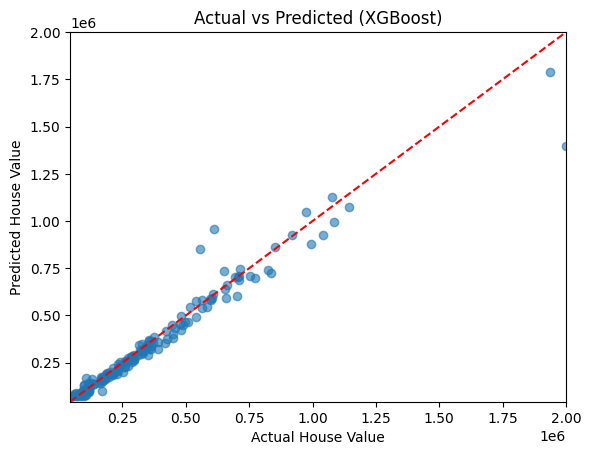

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Convert X_test to DMatrix
dtest = xgb.DMatrix(X_test)

# Predict on test set using your model
y_pred_scaled = bst_final.predict(dtest)  # predicted scaled log-values    ----- change this when you have a new model

# Inverse transform predicted scaled values (undo MinMax scaling)
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Undo log-transform (assuming natural log +1 was used)
y_pred_original = np.expm1(y_pred_inv_scaled)

# Inverse transform actual scaled test values
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Undo log-transform for actual values
y_test_original = np.expm1(y_test_inv_scaled)

# Calculate metrics on original scale
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

plt.figure(figsize=(10,6))
xgb.plot_importance(bst_final, max_num_features=20, importance_type='gain') # change this when you have a new model
plt.title("Top 20 Feature Importances (Gain)")
plt.show()

# Plot with equal limits
lims = [min(min(y_test_original), min(y_pred_original)), max(max(y_test_original), max(y_pred_original))]

plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (XGBoost)")
plt.show()


[0]	train-rmse:0.18916	test-rmse:0.20372
[100]	train-rmse:0.06892	test-rmse:0.08280
[200]	train-rmse:0.03057	test-rmse:0.04786
[300]	train-rmse:0.01915	test-rmse:0.03865
[400]	train-rmse:0.01527	test-rmse:0.03607
[500]	train-rmse:0.01345	test-rmse:0.03520
[600]	train-rmse:0.01246	test-rmse:0.03491
[700]	train-rmse:0.01207	test-rmse:0.03475
[800]	train-rmse:0.01190	test-rmse:0.03469
[900]	train-rmse:0.01180	test-rmse:0.03464
[981]	train-rmse:0.01174	test-rmse:0.03462
MAE: 33746.09
RMSE: 79126.60
R²: 0.931


<Figure size 1000x600 with 0 Axes>

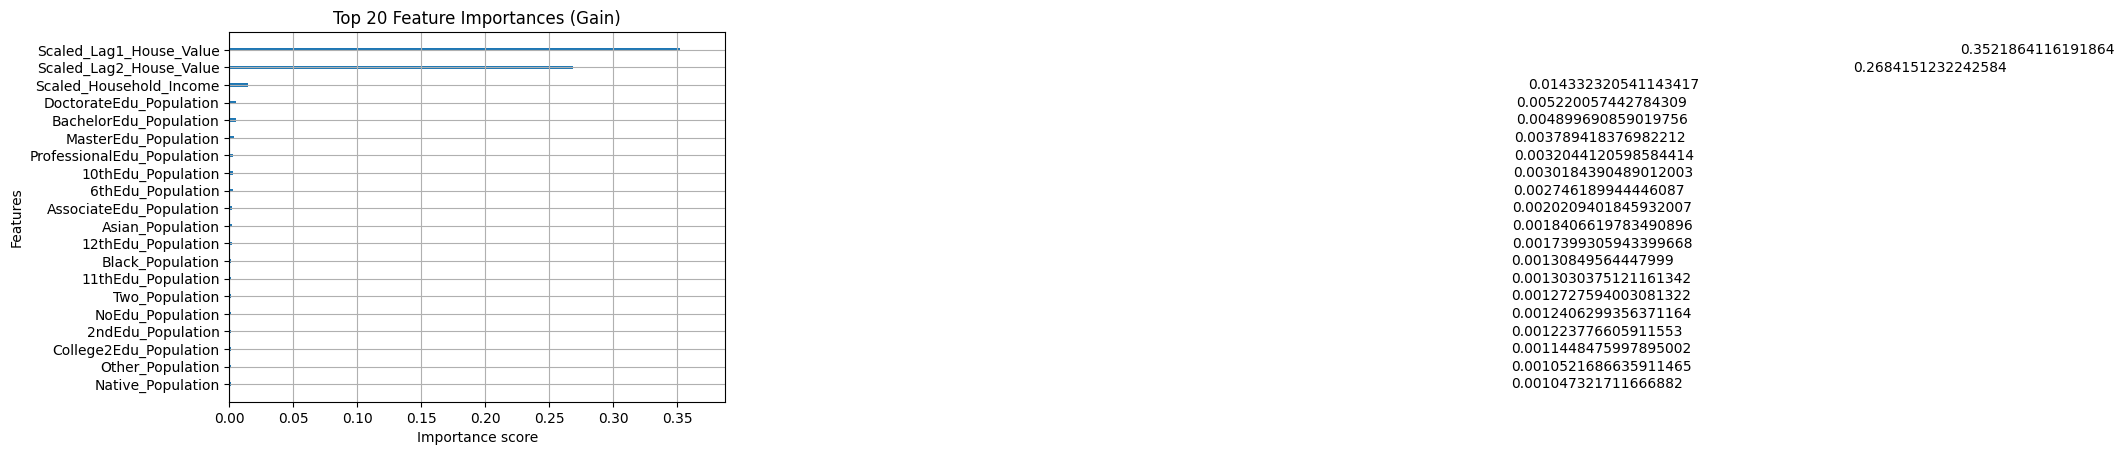

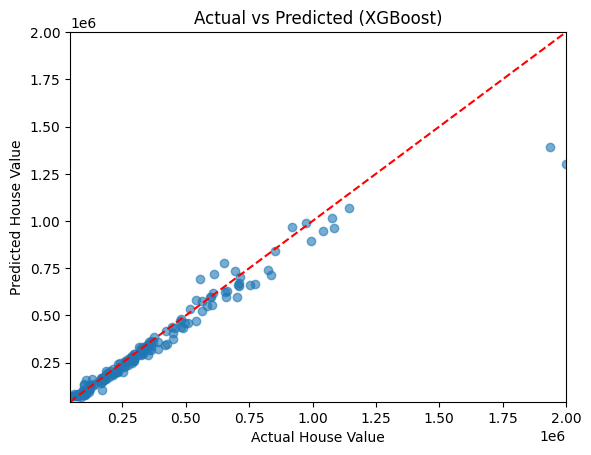

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# ---------------------------
# Final XGBoost model with best params
# ---------------------------
best_params = {
    "booster": "gbtree",
    "learning_rate": 0.010809906023806071,
    "max_depth": 5,
    "min_child_weight": 7,
    "subsample": 0.8018838472298855,
    "colsample_bytree": 0.7880637245015297,
    "gamma": 0.0003688976436750195,
    "reg_alpha": 0.07044008359983205,
    "reg_lambda": 0.002480810811944202,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",  # GPU users can replace with "gpu_hist"
    "seed": 42
}

# ---------------------------
# Data Setup
# ---------------------------
train_years = list(range(2012, 2020))   # Train+Validation: 2012–2019
val_years = [2020]                      # Validation anchor year
test_years = [2021, 2022]               # Final test
features = predictors

train_df = merged_data[merged_data['Year'].isin(train_years + val_years)]
test_df = merged_data[merged_data['Year'].isin(test_years)]

X_train = train_df[features].values
y_train = train_df['Scaled_House_Value'].values
X_test = test_df[features].values
y_test = test_df['Scaled_House_Value'].values

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

# Train the model
bst_final = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=50,
    verbose_eval=100
)

# ---------------------------
# Predictions
# ---------------------------
# Predict on test set using your model
y_pred_scaled = bst_final.predict(dtest)

# Inverse MinMax scaling
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Undo log-transform
y_pred_original = np.expm1(y_pred_inv_scaled)

# Inverse transform actual test values
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_original = np.expm1(y_test_inv_scaled)

# ---------------------------
# Metrics
# ---------------------------
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# ---------------------------
# Feature Importance
# ---------------------------
plt.figure(figsize=(10,6))
xgb.plot_importance(bst_final, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (Gain)")
plt.show()

# ---------------------------
# Actual vs Predicted Plot
# ---------------------------
lims = [min(min(y_test_original), min(y_pred_original)),
        max(max(y_test_original), max(y_pred_original))]

plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (XGBoost)")
plt.show()


In [ ]:
#@title ignore ts too

# import numpy as np
# import matplotlib.pyplot as plt
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # ---------------------------
# # Final XGBoost parameters (seed removed for randomness)
# # ---------------------------
# best_params = {
#     "booster": "gbtree",
#     "learning_rate": 0.010809906023806071,
#     "max_depth": 5,
#     "min_child_weight": 7,
#     "subsample": 0.8018838472298855,
#     "colsample_bytree": 0.7880637245015297,
#     "gamma": 0.0003688976436750195,
#     "reg_alpha": 0.07044008359983205,
#     "reg_lambda": 0.002480810811944202,
#     "objective": "reg:squarederror",
#     "eval_metric": "rmse",
#     "tree_method": "hist"  # GPU users can replace with "gpu_hist"
#     # no seed -> allows randomness each trial
# }

# # ---------------------------
# # Data Setup
# # ---------------------------
# train_years = list(range(2012, 2020))   # Train+Validation: 2012–2019
# val_years = [2020]                      # Validation anchor year
# test_years = [2021, 2022]               # Final test
# features = predictors

# train_df = merged_data[merged_data['Year'].isin(train_years + val_years)]
# test_df = merged_data[merged_data['Year'].isin(test_years)]

# X_train = train_df[features].values
# y_train = train_df['Scaled_House_Value'].values
# X_test = test_df[features].values
# y_test = test_df['Scaled_House_Value'].values

# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

# # ---------------------------
# # Function to train and evaluate one XGBoost model
# # ---------------------------
# def train_and_evaluate_xgb(dtrain, dtest, y_test, house_value_scaler):
#     bst = xgb.train(
#         params=best_params,
#         dtrain=dtrain,
#         num_boost_round=2000,
#         evals=[(dtrain, "train"), (dtest, "test")],
#         early_stopping_rounds=50,
#         verbose_eval=False  # suppress verbose training
#     )

#     # Predictions
#     y_pred_scaled = bst.predict(dtest)

#     # Inverse transform
#     y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
#     y_pred_original = np.expm1(y_pred_inv_scaled)

#     y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
#     y_test_original = np.expm1(y_test_inv_scaled)

#     # Metrics
#     mae = mean_absolute_error(y_test_original, y_pred_original)
#     rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
#     r2 = r2_score(y_test_original, y_pred_original)

#     return rmse, mae, r2

# # ---------------------------
# # Run multiple trials
# # ---------------------------
# n_trials = 30
# all_rmse, all_mae, all_r2 = [], [], []

# for trial in range(n_trials):
#     print(f"--- Running Trial {trial + 1} ---")
#     rmse, mae, r2 = train_and_evaluate_xgb(dtrain, dtest, y_test, house_value_scaler)
#     all_rmse.append(rmse)
#     all_mae.append(mae)
#     all_r2.append(r2)

# # ---------------------------
# # Summary stats
# # ---------------------------
# avg_rmse, std_rmse = np.mean(all_rmse), np.std(all_rmse)
# avg_mae, std_mae = np.mean(all_mae), np.std(all_mae)
# avg_r2, std_r2 = np.mean(all_r2), np.std(all_r2)

# print("\n--- Average Metrics Across Trials ---")
# print(f"Average MAE: {avg_mae:.2f}")
# print(f"Average RMSE: {avg_rmse:.2f}")
# print(f"Average R²: {avg_r2:.3f}")

# print("\n--- Standard Deviation Across Trials ---")
# print(f"MAE SD: {std_mae:.2f}")
# print(f"RMSE SD: {std_rmse:.2f}")
# print(f"R² SD: {std_r2:.3f}")


--- Running Trial 1 ---
--- Running Trial 2 ---
--- Running Trial 3 ---
--- Running Trial 4 ---
--- Running Trial 5 ---
--- Running Trial 6 ---
--- Running Trial 7 ---
--- Running Trial 8 ---
--- Running Trial 9 ---
--- Running Trial 10 ---
--- Running Trial 11 ---
--- Running Trial 12 ---
--- Running Trial 13 ---
--- Running Trial 14 ---
--- Running Trial 15 ---
--- Running Trial 16 ---
--- Running Trial 17 ---
--- Running Trial 18 ---
--- Running Trial 19 ---
--- Running Trial 20 ---
--- Running Trial 21 ---
--- Running Trial 22 ---
--- Running Trial 23 ---
--- Running Trial 24 ---
--- Running Trial 25 ---
--- Running Trial 26 ---
--- Running Trial 27 ---
--- Running Trial 28 ---
--- Running Trial 29 ---
--- Running Trial 30 ---

--- Average Metrics Across Trials ---
Average MAE: 33846.67
Average RMSE: 77729.82
Average R²: 0.934

--- Standard Deviation Across Trials ---
MAE SD: 0.00
RMSE SD: 0.00
R² SD: 0.000


# Neural Network

## NN (no tuning)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # output scaled-value
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, verbose=1)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0601 - val_loss: 0.0066
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - val_loss: 0.0061
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3742e-04 - val_loss: 0.0045
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8193e-04 - val_loss: 0.0036
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0999e-04 - val_loss: 0.0044
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5006e-04 - val_loss: 0.0037
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3498e-04 - val_loss: 0.0034
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9476e-04 - val_loss: 0.0025
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6343e-04 - val_loss: 0.0035
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

## Hyperparameter Tuning with KerasTuner

In [ ]:
!pip install keras-tuner

In [ ]:
#@title v1

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


# Split train / validation / test
train_years = list(range(2012, 2020))  # Train: 2012-2019
val_years = [2020]                       # Validation: 2020
test_years = [2021, 2022]               # Test: 2021-2022
features = predictors

# First filter by years
train_df = merged_data[merged_data['Year'].isin(train_years)]
val_df = merged_data[merged_data['Year'].isin(val_years)]
test_df = merged_data[merged_data['Year'].isin(test_years)]

# Build X and y
X_train = train_df[features].values
y_train = train_df['Scaled_House_Value'].values

X_val = val_df[features].values
y_val = val_df['Scaled_House_Value'].values

X_test = test_df[features].values
y_test = test_df['Scaled_House_Value'].values


def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(Dense(
        units=hp.Int('units_2', min_value=16, max_value=128, step=16),
        activation='relu'
    ))
    model.add(Dense(1))

    # Tune learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse'
    )
    return model

# Tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name='dense_tuning'
)

tuner.search_space_summary()

# Use your fixed year-based validation set
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hps.values)


Trial 10 Complete [00h 00m 11s]
val_loss: 0.0018030685605481267

Best val_loss So Far: 0.0017618222627788782
Total elapsed time: 00h 02m 47s
Best hyperparameters: {'units_1': 224, 'units_2': 48, 'learning_rate': 0.0027365052817158123}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

"""
- Number of layers
- Units
- Dropout rate
- Learning rate
- Early stopping
"""


# Split train / validation / test
train_years = list(range(2012, 2020))  # Train: 2012-2019
val_years = [2020]                       # Validation: 2020
test_years = [2021, 2022]               # Test: 2021-2022
features = predictors

# First filter by years
train_df = merged_data[merged_data['Year'].isin(train_years)]
val_df = merged_data[merged_data['Year'].isin(val_years)]
test_df = merged_data[merged_data['Year'].isin(test_years)]

# Build X and y
X_train = train_df[features].values
y_train = train_df['Scaled_House_Value'].values

X_val = val_df[features].values
y_val = val_df['Scaled_House_Value'].values

X_test = test_df[features].values
y_test = test_df['Scaled_House_Value'].values

# --- Hypermodel function ---
def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Dense(
        units=hp.Int('units_input', min_value=16, max_value=256, step=16),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))

    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=16, max_value=256, step=16),
            activation='relu'
        ))
        model.add(Dropout(
            rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        ))

    # Output layer
    model.add(Dense(1))

    # Compile
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        ),
        loss='mse'
    )
    return model


# --- Tuner setup ---
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='nn_tuning',
    overwrite=True
)

# --- Search ---
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,          # how many epochs with no improvement before stopping
    restore_best_weights=True
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Explicit split — no leakage
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# --- Get best model ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for hp_name, hp_value in best_hps.values.items():
    print(f"{hp_name}: {hp_value}")

best_model2 = tuner.get_best_models(num_models=1)[0]


Trial 100 Complete [00h 00m 09s]
val_loss: 0.005475709214806557

Best val_loss So Far: 0.0016743888845667243
Total elapsed time: 00h 17m 46s
Best hyperparameters:
units_input: 144
num_layers: 2
units_0: 224
dropout_0: 0.1
learning_rate: 0.00011353194581530606
units_1: 192
dropout_1: 0.1
units_2: 32
dropout_2: 0.1
units_3: 80
dropout_3: 0.1


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 28538.75
RMSE: 60324.99
R²: 0.960


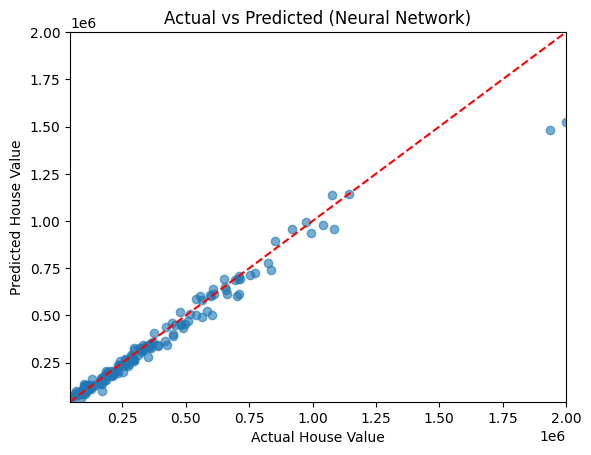

In [ ]:
import matplotlib.pyplot as plt

# Predict on test set (scaled target)
y_pred_scaled = best_model2.predict(X_test).flatten()

# Inverse transform predicted scaled house value
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Undo log-transform
y_pred_original = np.expm1(y_pred_inv_scaled)

# Inverse transform actual scaled house value
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Undo log-transform for actual values
y_test_original = np.expm1(y_test_inv_scaled)

# Calculate metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# Plot with equal limits
lims = [min(min(y_test_original), min(y_pred_original)), max(max(y_test_original), max(y_pred_original))]

plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (Neural Network)")
plt.show()

## Final Model

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - loss: 0.1412
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 16/100
1

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
MAE: 0.1333
RMSE: 0.1642
R²: 0.956
MAE: 47159.87
RMSE: 69921.40
R²: 0.946


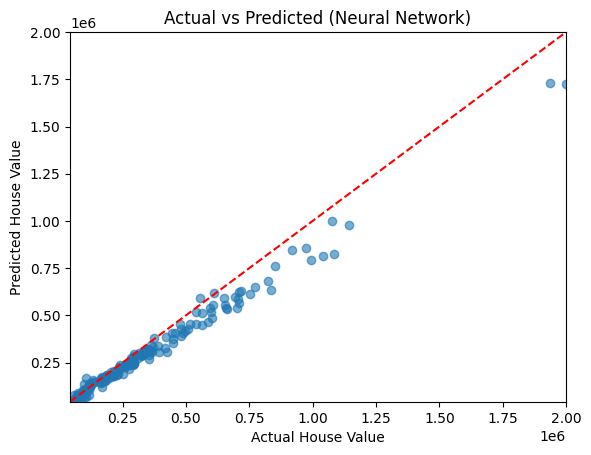

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler  # Make sure to import the scaler if needed
import random
import os


# Train on all data, no validation
train_years = list(range(2012 + max(lag_years), 2021))  # 2014–2020
test_years = [2021, 2022]

X_train = X[merged_data['Year'].isin(train_years)]
y_train = y[merged_data['Year'].isin(train_years)]

X_test = X[merged_data['Year'].isin(test_years)]
y_test = y[merged_data['Year'].isin(test_years)]



# --- Build the neural network ---
model = Sequential()

# Input layer
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

# Hidden layers according to your hyperparameters
model.add(Dense(240, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(224, activation='relu'))
model.add(Dropout(0.1))

# model.add(Dense(48, activation='relu'))
# model.add(Dropout(0.4))

# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.0))

# Output layer
model.add(Dense(1, activation='linear'))

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00032264295936501765),
    loss='mean_squared_error'
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,          # you can adjust
    batch_size=32,       # you can adjust
    verbose=1
)

# Evaluate
y_pred_scaled = model.predict(X_test)
y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled).flatten()
y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_test_inv_scaled, y_pred_inv_scaled))
mae = mean_absolute_error(y_test_inv_scaled, y_pred_inv_scaled)
r2 = r2_score(y_test_inv_scaled, y_pred_inv_scaled)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.3f}")

y_pred_original = np.expm1(y_pred_inv_scaled)
y_test_original = np.expm1(y_test_inv_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


# Plot with equal limits
lims = [min(min(y_test_original), min(y_pred_original)), max(max(y_test_original), max(y_pred_original))]

plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot(lims, lims, color='red', linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title("Actual vs Predicted (Neural Network)")
plt.show()


--- Running Trial 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


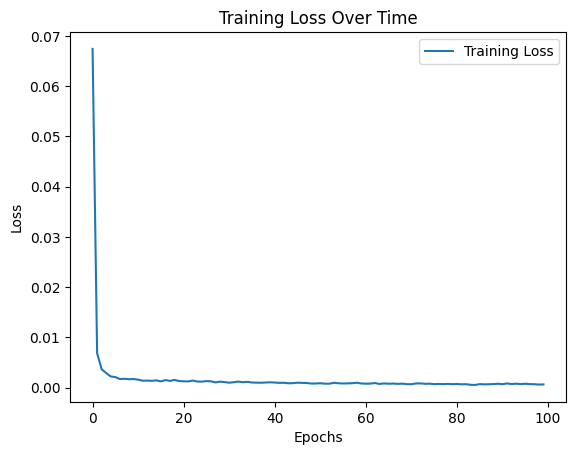

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE: 25276.17
RMSE: 37185.50
R²: 0.985


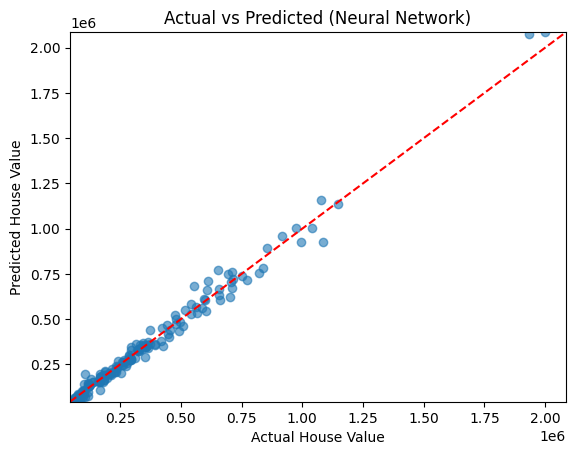


--- Running Trial 2 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


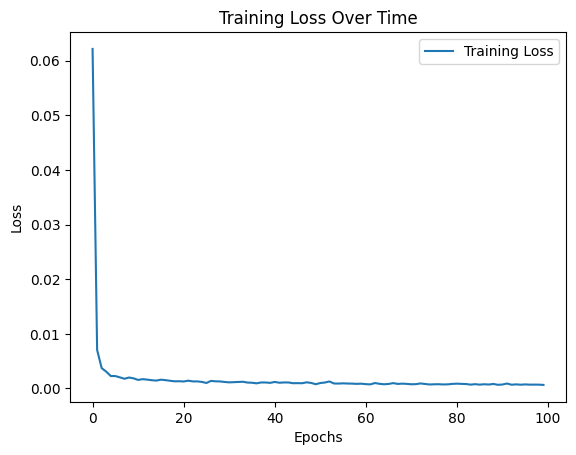

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE: 25371.39
RMSE: 36038.77
R²: 0.986


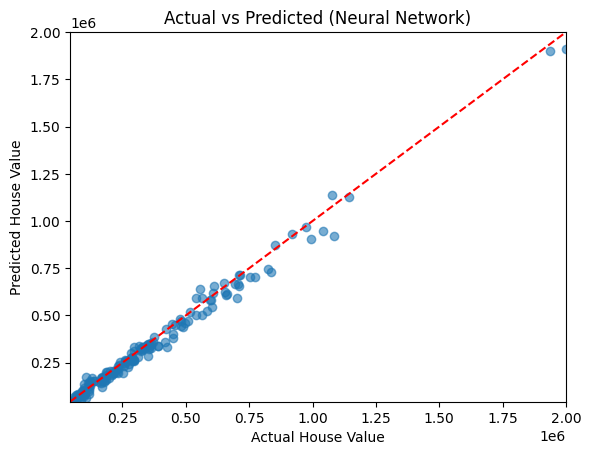


--- Running Trial 3 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


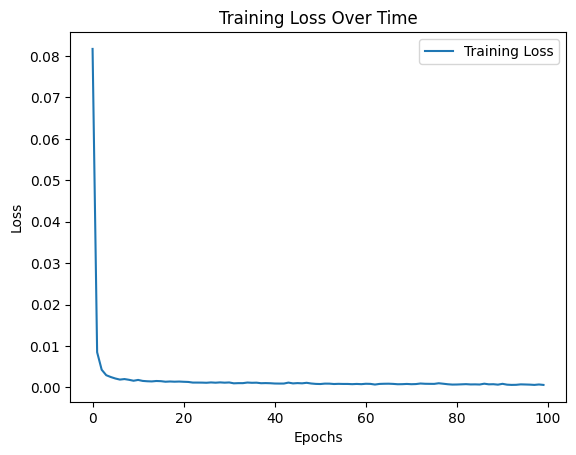

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE: 42564.97
RMSE: 65831.13
R²: 0.952


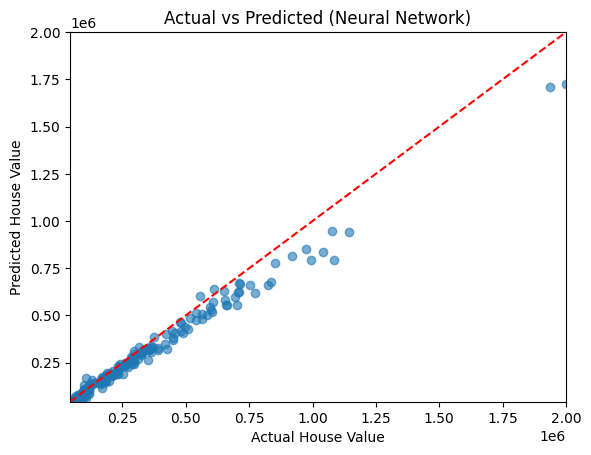


--- Running Trial 4 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


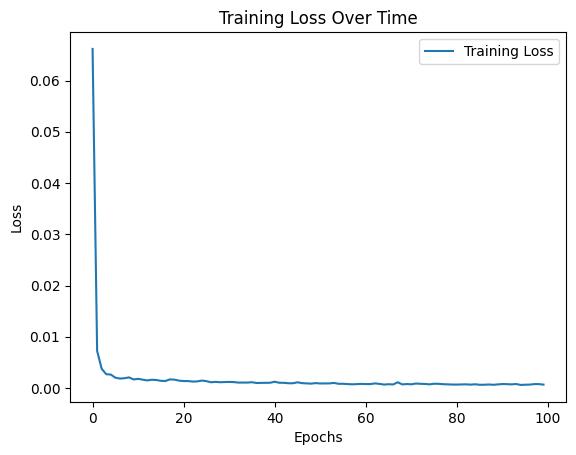

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 29650.76
RMSE: 43897.41
R²: 0.979


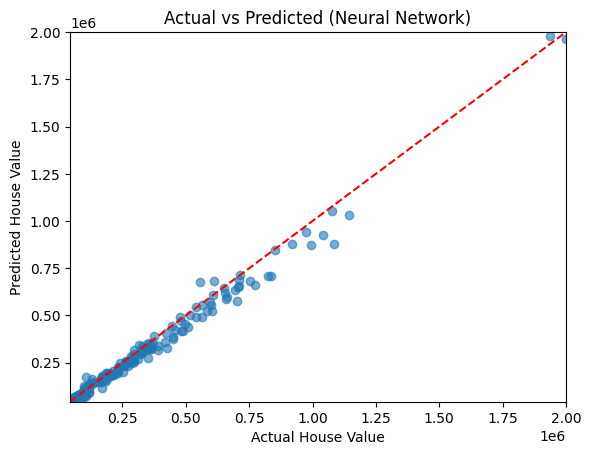


--- Running Trial 5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


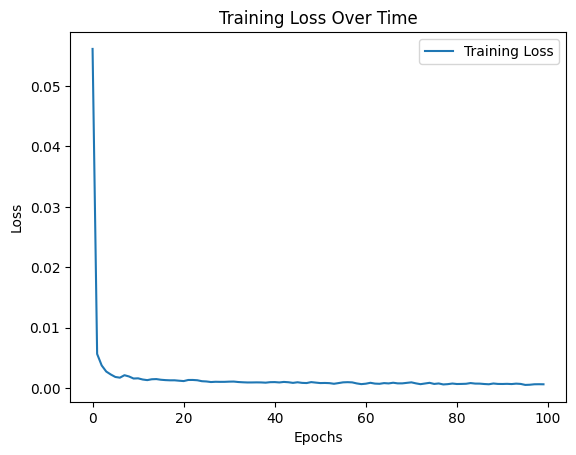

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 22430.06
RMSE: 32926.12
R²: 0.988


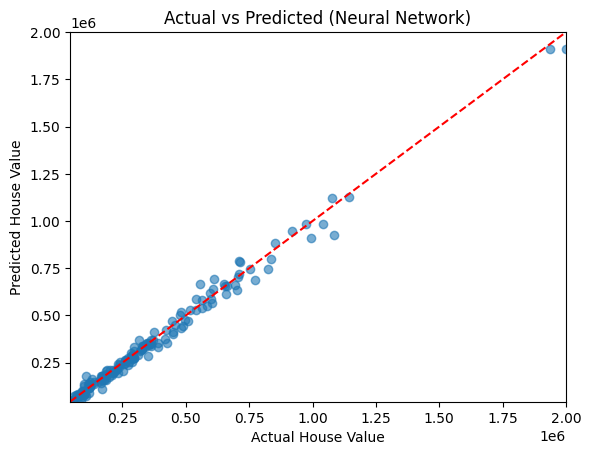


--- Running Trial 6 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


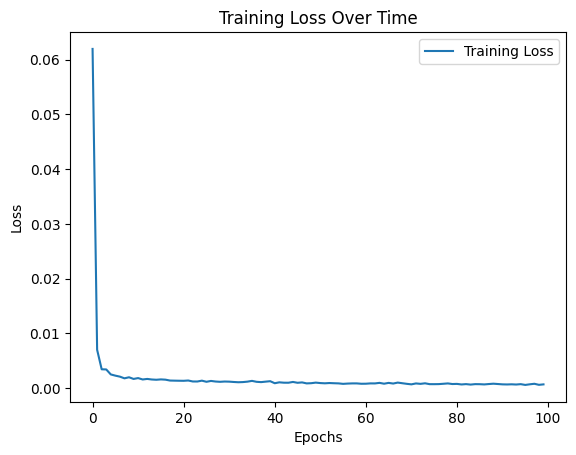

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MAE: 28368.81
RMSE: 42728.62
R²: 0.980


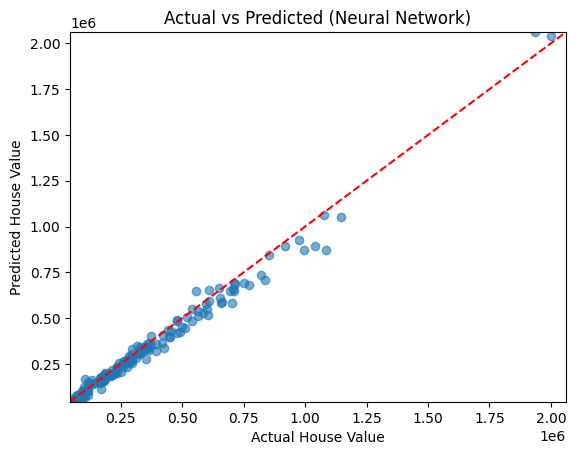


--- Running Trial 7 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


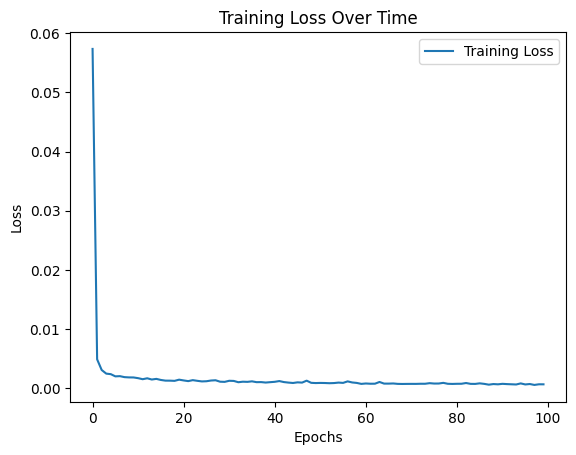

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 32722.56
RMSE: 47803.67
R²: 0.975


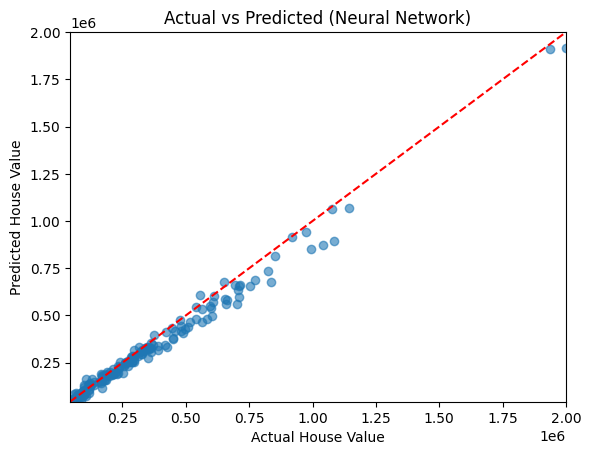


--- Running Trial 8 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


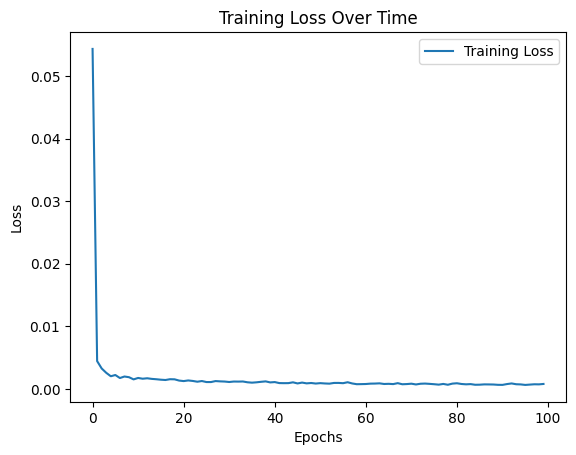

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 36516.83
RMSE: 56094.76
R²: 0.965


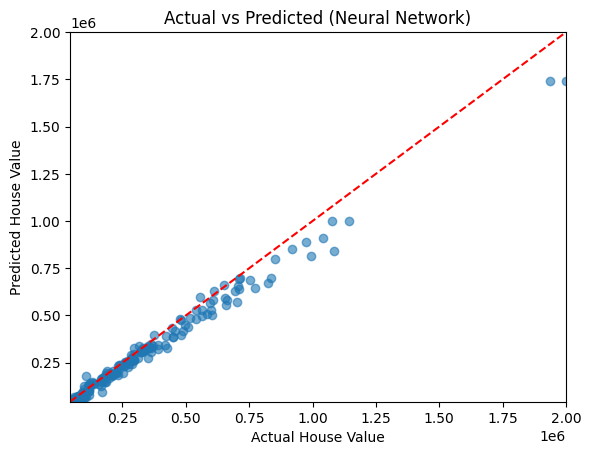


--- Running Trial 9 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


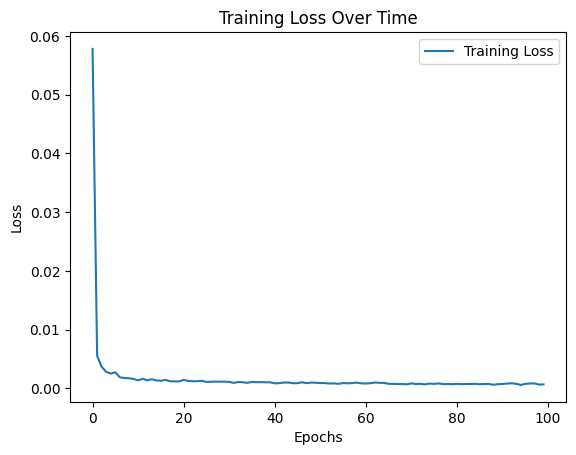

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE: 30473.49
RMSE: 46193.11
R²: 0.977


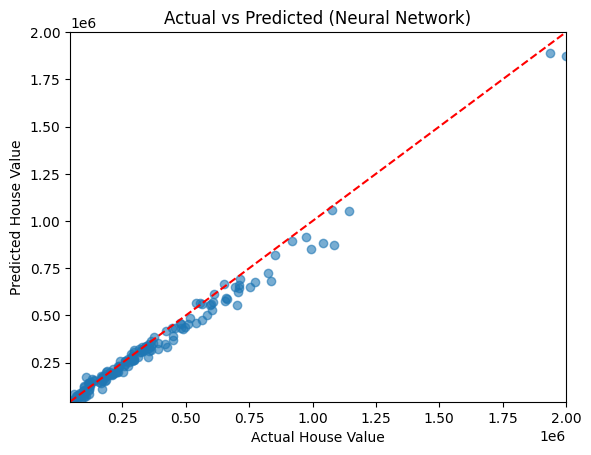


--- Running Trial 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


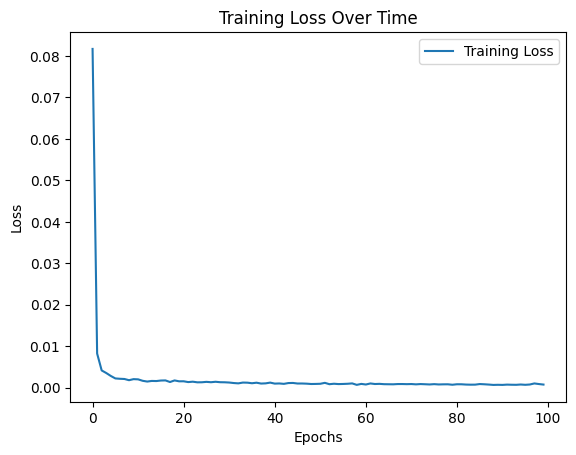

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 21638.92
RMSE: 30730.30
R²: 0.990


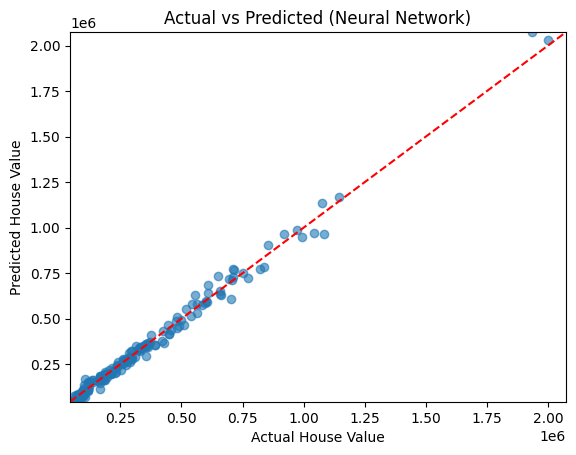


--- Running Trial 11 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


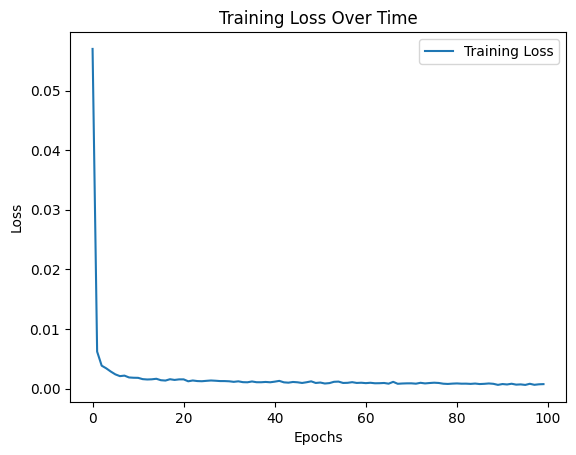

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 28010.49
RMSE: 41074.10
R²: 0.981


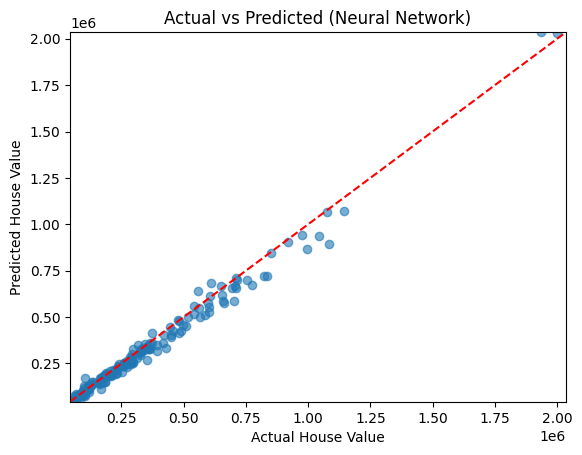


--- Running Trial 12 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


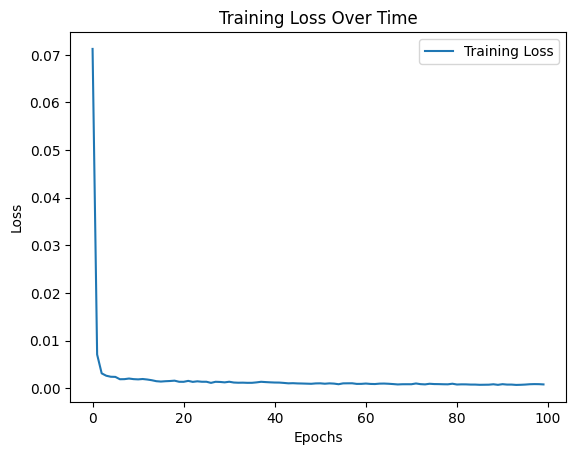

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE: 26818.90
RMSE: 44841.74
R²: 0.978


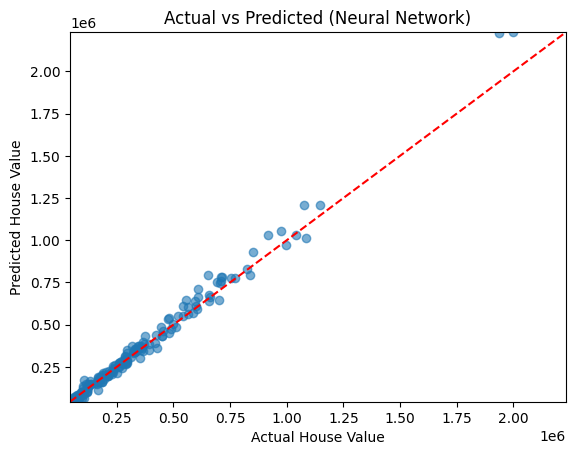


--- Running Trial 13 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


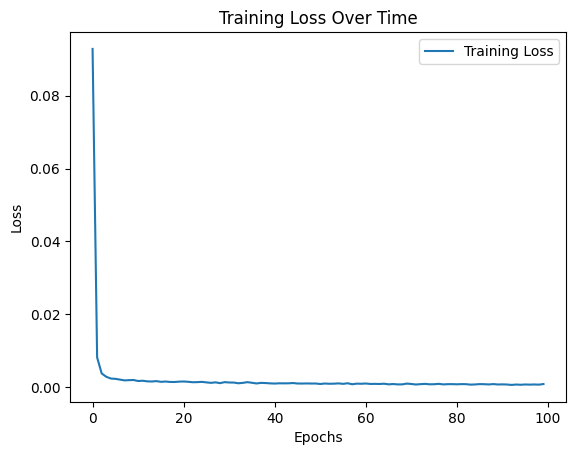

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE: 32294.17
RMSE: 47668.01
R²: 0.975


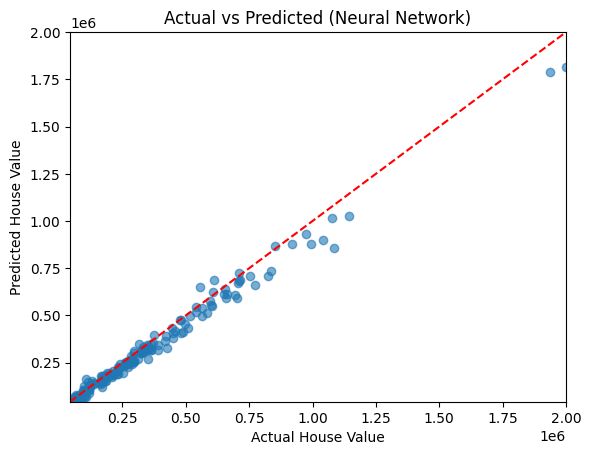


--- Running Trial 14 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


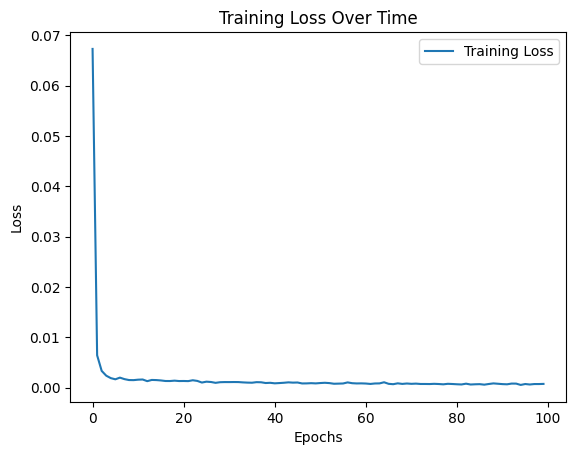

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAE: 51670.09
RMSE: 73497.26
R²: 0.941


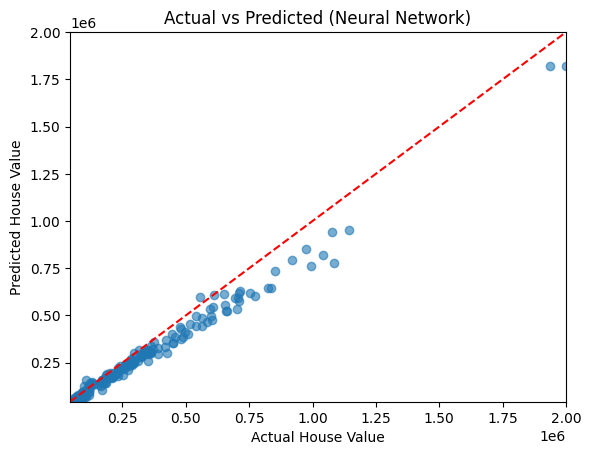


--- Running Trial 15 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


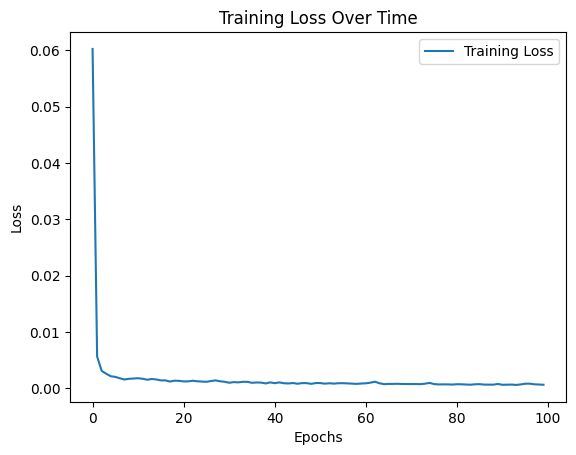

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE: 42434.81
RMSE: 60659.79
R²: 0.960


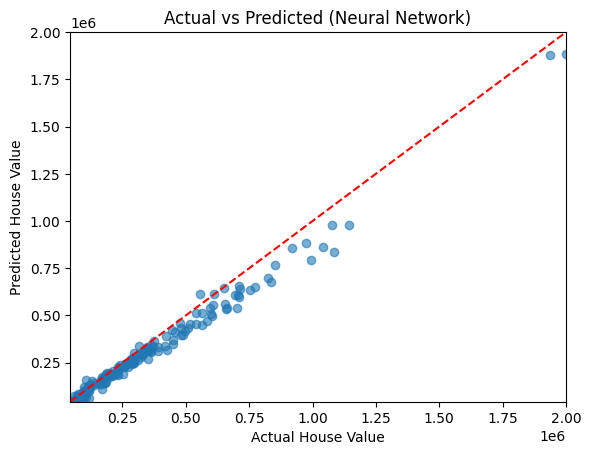


--- Running Trial 16 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


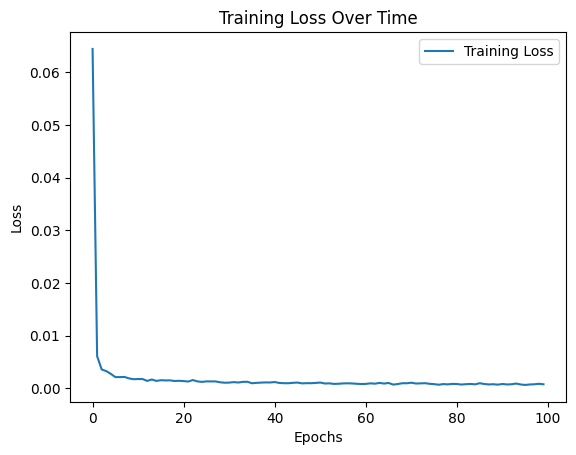

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAE: 38010.88
RMSE: 53975.56
R²: 0.968


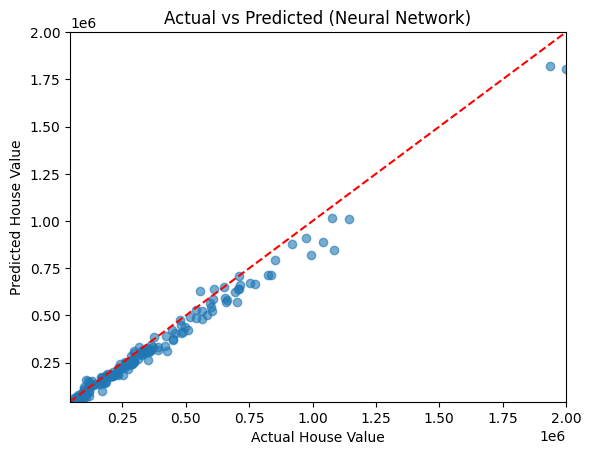


--- Running Trial 17 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


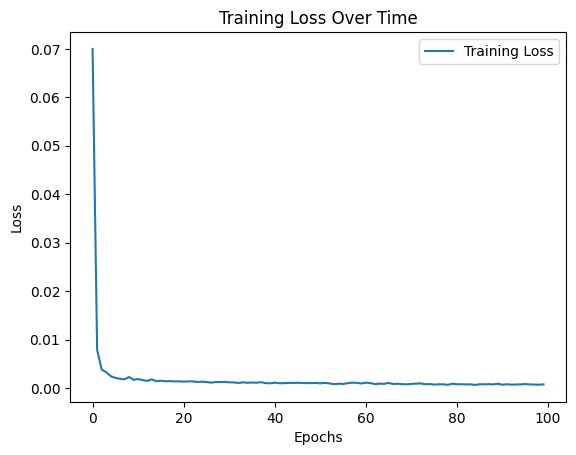

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 35872.86
RMSE: 50774.56
R²: 0.972


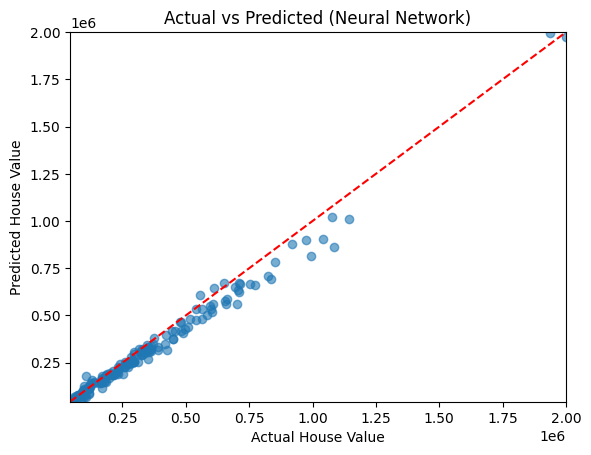


--- Running Trial 18 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


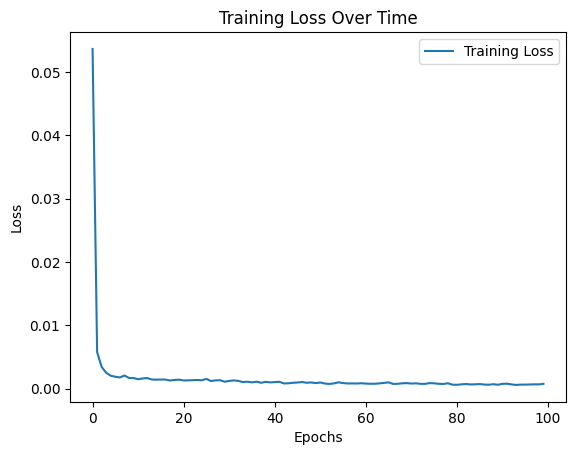

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAE: 23687.58
RMSE: 36226.12
R²: 0.986


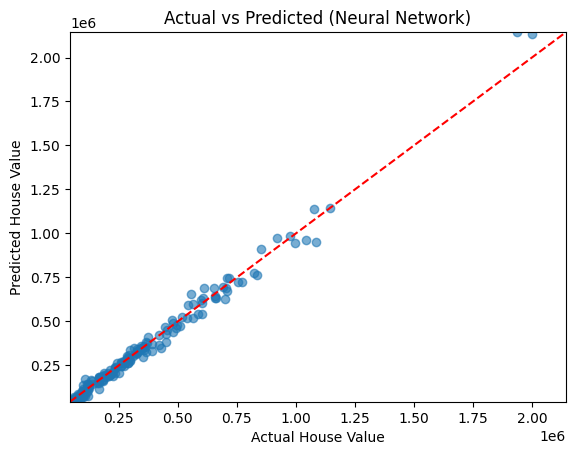


--- Running Trial 19 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


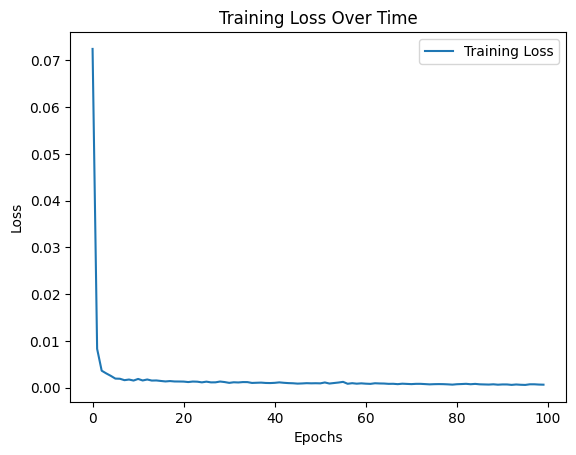

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 33684.94
RMSE: 46329.20
R²: 0.976


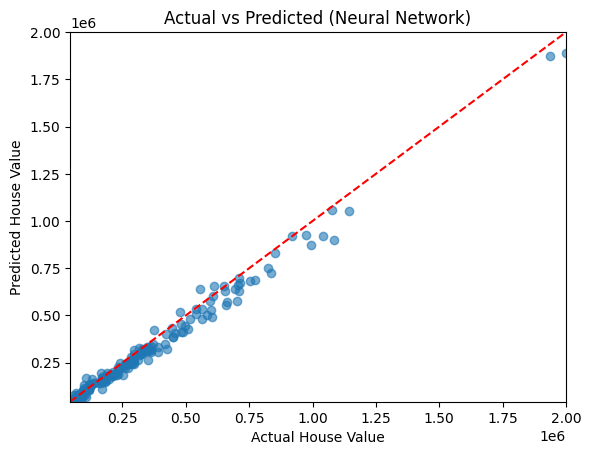


--- Running Trial 20 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


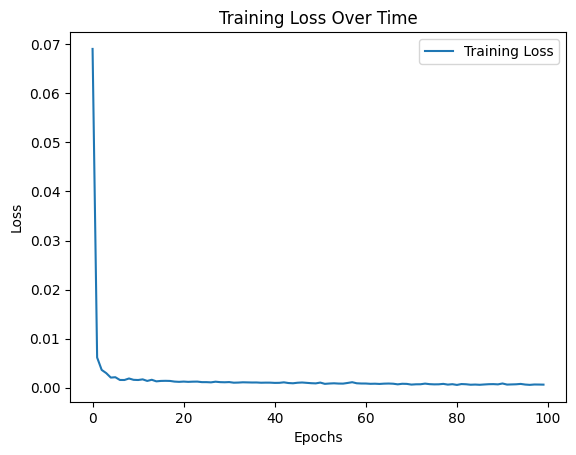

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 27623.36
RMSE: 49562.83
R²: 0.973


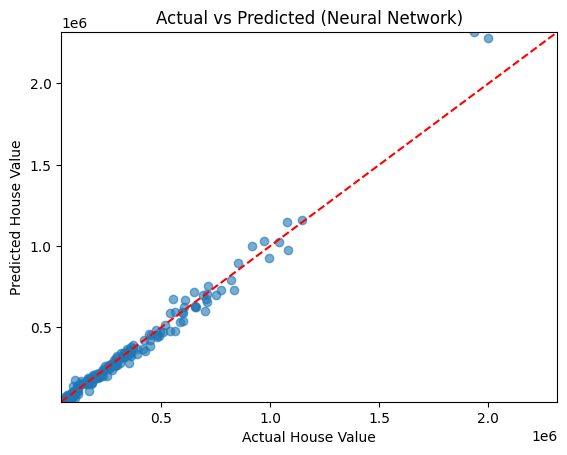


--- Running Trial 21 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


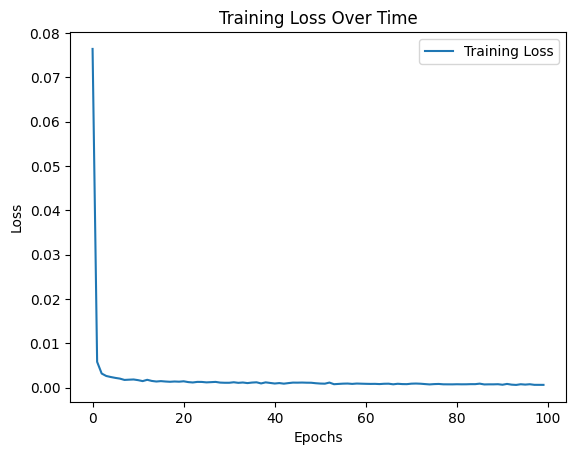

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE: 28189.40
RMSE: 44321.35
R²: 0.978


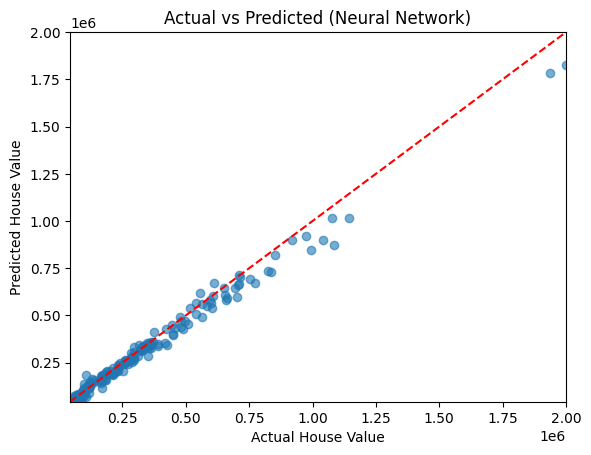


--- Running Trial 22 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


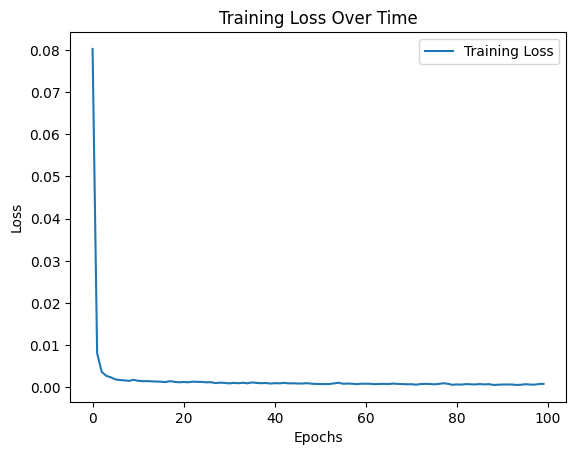

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 41412.02
RMSE: 57991.84
R²: 0.963


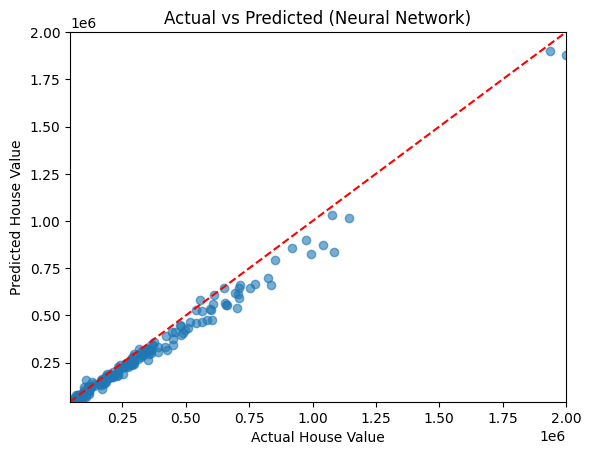


--- Running Trial 23 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


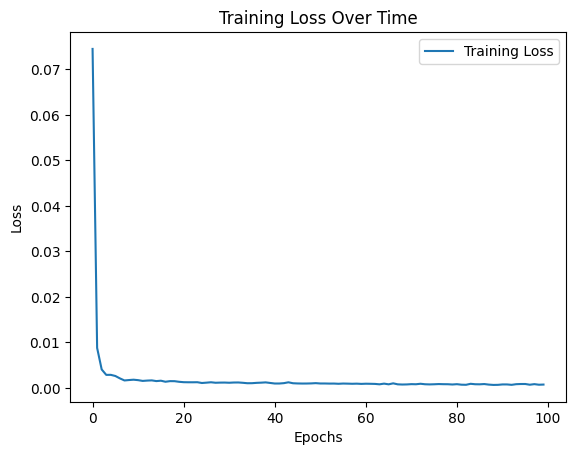

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 24860.04
RMSE: 35239.20
R²: 0.986


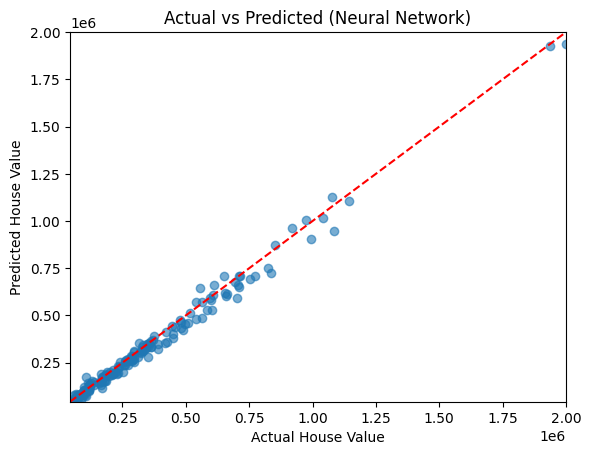


--- Running Trial 24 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


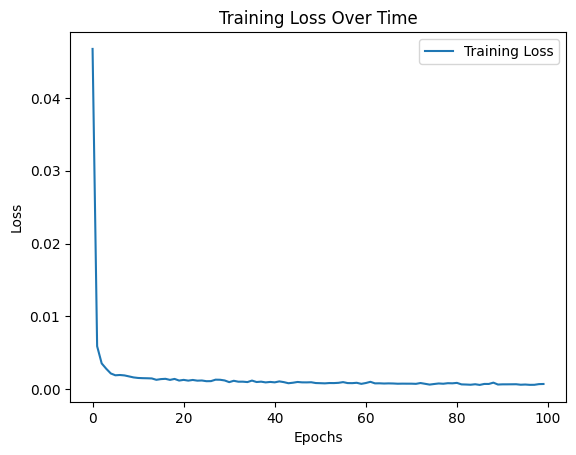

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 29019.79
RMSE: 46719.06
R²: 0.976


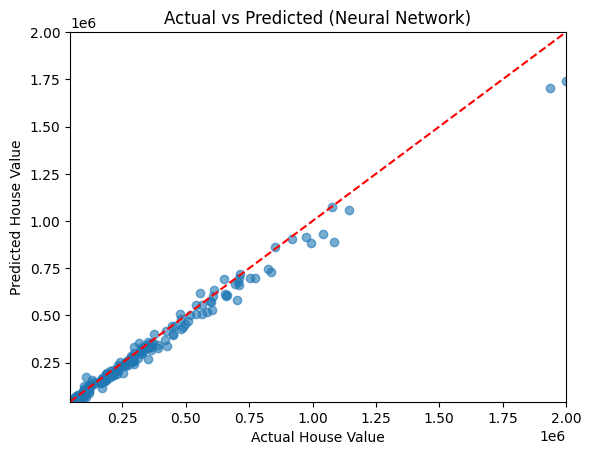


--- Running Trial 25 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


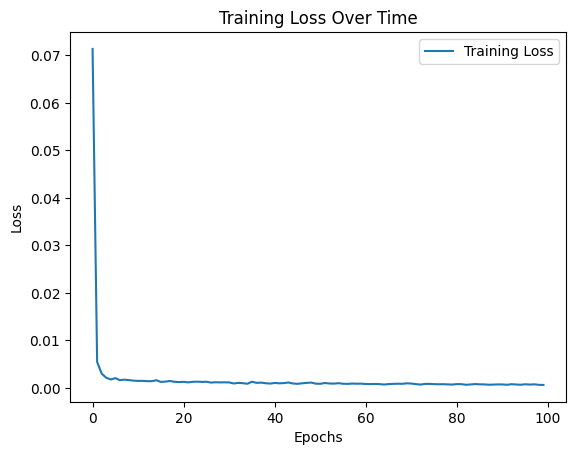

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 25698.14
RMSE: 36785.34
R²: 0.985


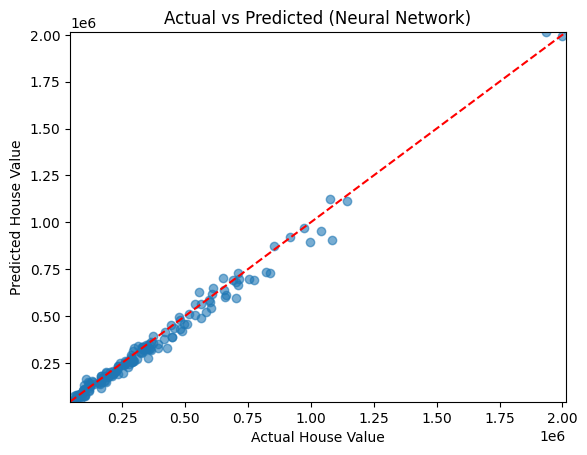


--- Running Trial 26 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


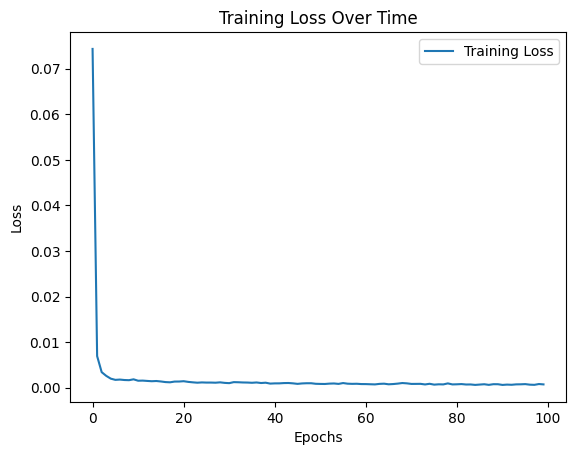

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 26357.29
RMSE: 45212.28
R²: 0.978


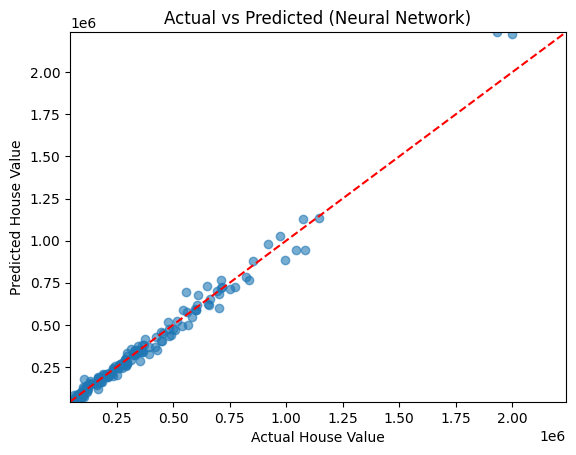


--- Running Trial 27 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


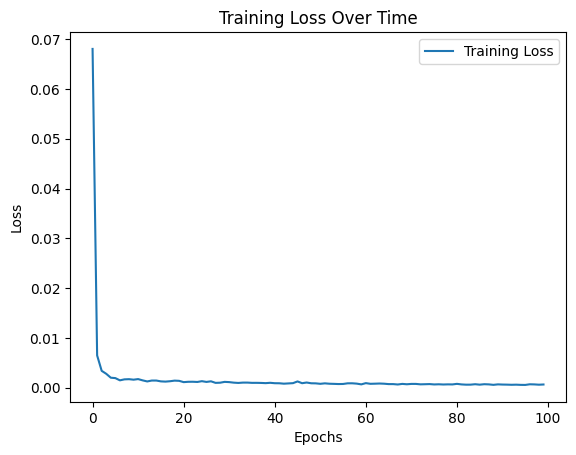

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAE: 28215.57
RMSE: 42737.39
R²: 0.980


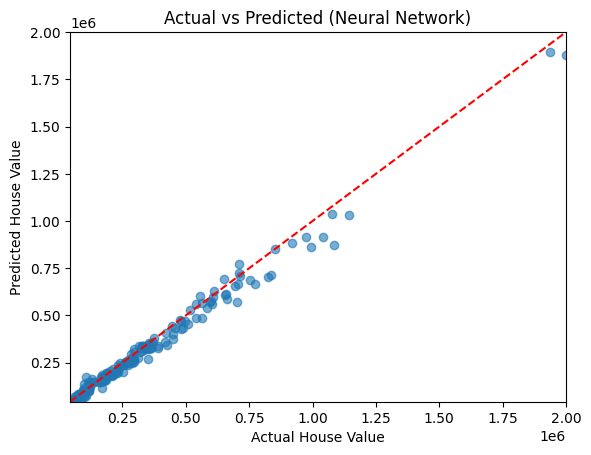


--- Running Trial 28 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


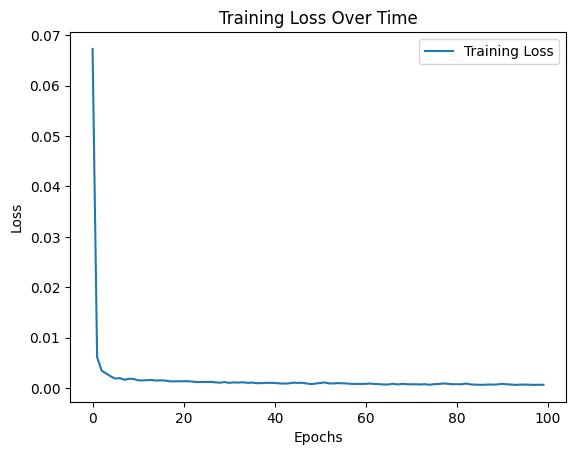

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 33465.56
RMSE: 49251.07
R²: 0.973


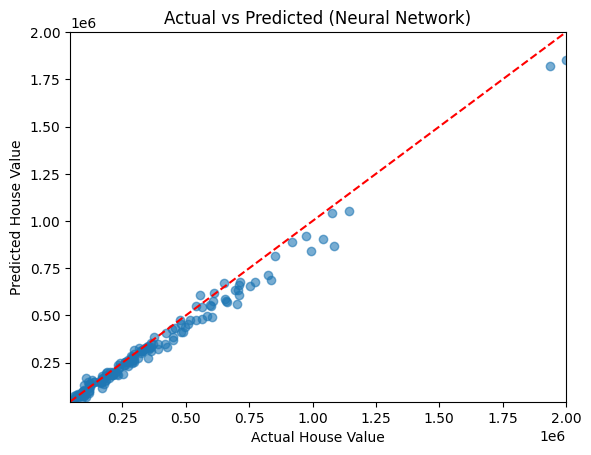


--- Running Trial 29 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


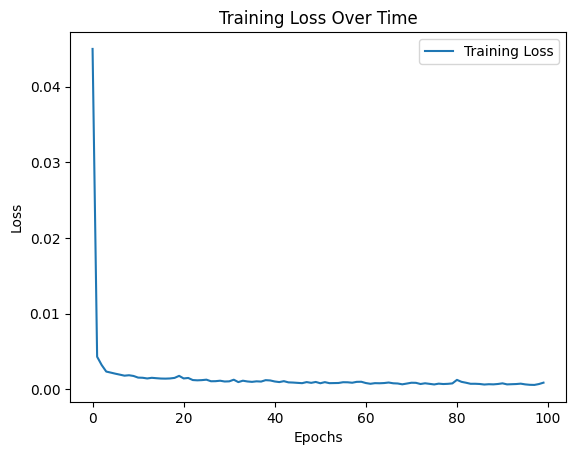

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE: 36101.82
RMSE: 56701.98
R²: 0.965


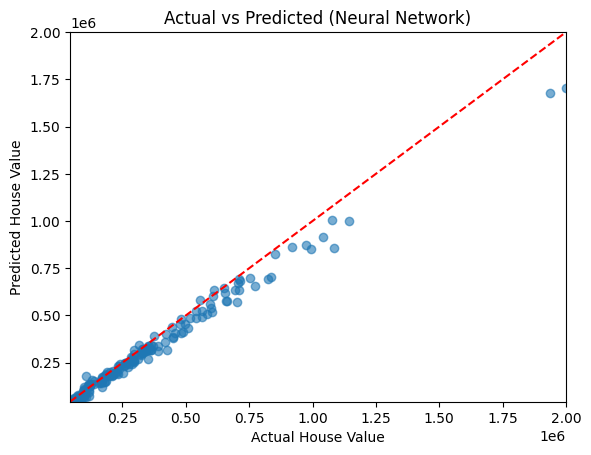


--- Running Trial 30 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


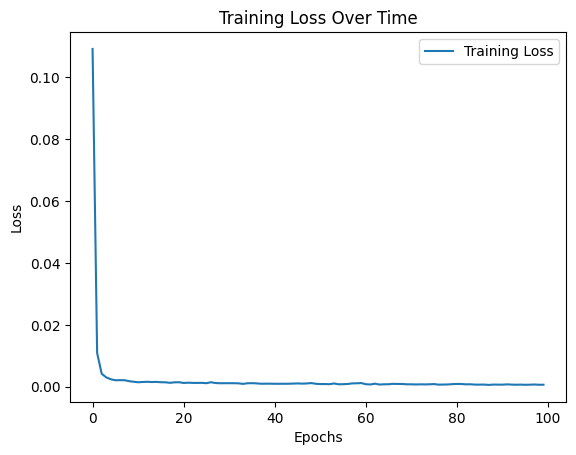

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAE: 23133.51
RMSE: 31697.11
R²: 0.989


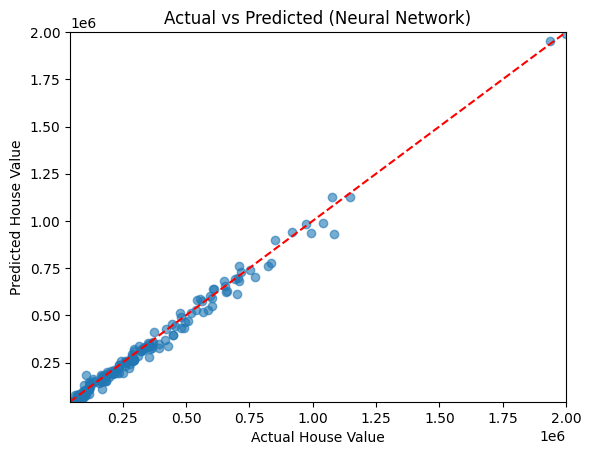


--- Summary of Results ---
Average MAE: 31052.51
Average RMSE: 46356.51
Average R²: 0.975

--- Standard Deviation of Results ---
Standard Deviation of MAE: 6933.07
Standard Deviation of RMSE: 9956.08
Standard Deviation of R²: 0.011


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler  # Make sure to import the scaler if needed
import random
import os

# Set random seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# Function to train and evaluate the model
def train_and_evaluate(X_train, y_train, X_test, y_test, house_value_scaler):
    # --- Build the neural network ---
    model = tf.keras.Sequential()

    # Input layer
    model.add(tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

    # Hidden layers
    model.add(tf.keras.layers.Dense(240, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Dense(224, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='linear'))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00032264295936501765),
        loss='mean_squared_error'
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,          # Adjust epochs if needed
        batch_size=32,       # Adjust batch_size if needed
        verbose=0            # Set verbose=0 to suppress detailed output
    )

    # Plot training loss history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

    # Evaluate the model on test data
    y_pred_scaled = model.predict(X_test)
    y_pred_inv_scaled = house_value_scaler.inverse_transform(y_pred_scaled).flatten()
    y_test_inv_scaled = house_value_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(y_test_inv_scaled, y_pred_inv_scaled))
    mae = mean_absolute_error(y_test_inv_scaled, y_pred_inv_scaled)
    r2 = r2_score(y_test_inv_scaled, y_pred_inv_scaled)

    print(f"MAE (log-space): {mae:.4f}")
    print(f"RMSE (log-space): {rmse:.4f}")
    print(f"R² (log-space): {r2:.3f}")

    y_pred_original = np.expm1(y_pred_inv_scaled)
    y_test_original = np.expm1(y_test_inv_scaled)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.3f}")

    # Plot Actual vs Predicted
    lims = [min(min(y_test_original), min(y_pred_original)), max(max(y_test_original), max(y_pred_original))]
    plt.scatter(y_test_original, y_pred_original, alpha=0.6)
    plt.plot(lims, lims, color='red', linestyle='--')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel("Actual House Value")
    plt.ylabel("Predicted House Value")
    plt.title("Actual vs Predicted (Neural Network)")
    plt.show()

    return rmse, mae, r2


# Example of running multiple trials
n_trials = 30
all_rmse, all_mae, all_r2 = [], [], []

for trial in range(n_trials):
    print(f"\n--- Running Trial {trial + 1} ---")

    # Train and evaluate model
    rmse, mae, r2 = train_and_evaluate(X_train, y_train, X_test, y_test, house_value_scaler)

    all_rmse.append(rmse)
    all_mae.append(mae)
    all_r2.append(r2)

# Average metrics across all trials
avg_rmse = np.mean(all_rmse)
avg_mae = np.mean(all_mae)
avg_r2 = np.mean(all_r2)

print("\n--- Summary of Results ---")
print(f"Average MAE: {avg_mae:.2f}")
print(f"Average RMSE: {avg_rmse:.2f}")
print(f"Average R²: {avg_r2:.3f}")

# Calculate the variability (standard deviation) of the metrics
std_rmse = np.std(all_rmse)
std_mae = np.std(all_mae)
std_r2 = np.std(all_r2)

print("\n--- Standard Deviation of Results ---")
print(f"Standard Deviation of MAE: {std_mae:.2f}")
print(f"Standard Deviation of RMSE: {std_rmse:.2f}")
print(f"Standard Deviation of R²: {std_r2:.3f}")


# Prediction (Better)

## LM

In [ ]:
def predict_future_lm(model, merged_data, predictors, lag_years, start_year=2023, end_year=2025, forward_fill=True):
    """
    Recursively predict future house values for multiple years using lag features
    and either forward-filled or linearly extrapolated features.

    Parameters:
    - model: Trained regression model (e.g., linear regression)
    - merged_data: DataFrame containing historical data up to the latest year
    - predictors: List of feature columns used in training (including lag features)
    - lag_years: List of lag periods used for lag features
    - start_year: First year to predict (default 2023)
    - end_year: Last year to predict (default 2025)
    - forward_fill: Boolean, if True uses last available values for non-lag features;
                    if False, uses linear trend extrapolation

    Returns:
    - future_predictions: DataFrame with predicted scaled house values for each tract and year
    """

    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LinearRegression

    latest_data = merged_data[merged_data['Year'] == merged_data['Year'].max()].copy()
    future_predictions = []

    for year in range(start_year, end_year + 1):
        future_data = latest_data.copy()
        future_data['Year'] = year

        # Handle non-lag features
        non_lag_features = [f for f in predictors if not any(f'Lag{lag}_House_Value' in f for lag in lag_years)]
        for feat in non_lag_features:
            if not forward_fill:
                lr = LinearRegression()
                tract_preds = []
                for tract in merged_data['Census_Tract'].unique():
                    tract_hist = merged_data[merged_data['Census_Tract'] == tract][['Year', feat]]
                    lr.fit(tract_hist['Year'].values.reshape(-1,1), tract_hist[feat].values)
                    pred = lr.predict(np.array([[year]]))[0]
                    tract_preds.append(pred)
                future_data[feat] = tract_preds
            else:
                pass  # keep latest value

        # Handle lag features
        for lag in lag_years:
            lag_col = f'Scaled_Lag{lag}_House_Value'
            future_data[lag_col] = future_data.groupby('Census_Tract')['Scaled_House_Value'].shift(lag)

        # Fill missing lag values for the first predicted year
        if year == start_year:
            for lag in lag_years:
                lag_col = f'Scaled_Lag{lag}_House_Value'
                if lag == 1:
                    future_data[lag_col] = latest_data['Scaled_House_Value'].values
                elif lag > 1:
                    future_data[lag_col] = merged_data[merged_data['Year'] == merged_data['Year'].max()-1][
                        'Scaled_House_Value'].values

        # Predict
        X_pred = future_data[predictors].values
        y_pred = model.predict(X_pred)
        future_data['Scaled_House_Value'] = y_pred

        future_predictions.append(future_data[['Census_Tract', 'Year', 'Scaled_House_Value']])
        latest_data = future_data.copy()

    result = pd.concat(future_predictions).reset_index(drop=True)

    log_values = house_value_scaler.inverse_transform(result[['Scaled_House_Value']])
    result['Pred_House_Value'] = np.expm1(log_values)  # undo log1p transform

    return result

In [ ]:
# Use forward-fill for features
future_preds = predict_future_lm(model, merged_data, predictors, lag_years, forward_fill=True)

# Use linear trend extrapolation for features
#future_preds = predict_future(lr_model, merged_data, predictors, lag_years, forward_fill=False)


In [ ]:
# Save to CSV
output_path = dir + 'future_predicted_house_values_lm.csv' # Replace with actual file directory, name, variables used, and sequence length used
future_preds.to_csv(output_path, index=False)
print(f"Future predicted house values for 2023, 2024, and 2025 saved to {output_path}")

## Neural Network

In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 240)            │        61,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 224)            │        53,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,013 (1.42 MB)

 Trainable params: 124,337 (485.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 248,676 (971.39 KB)

In [ ]:
def predict_future_nn(model, merged_data, predictors, lag_years, house_value_scaler,
                      start_year=2023, end_year=2025, forward_fill=True):
    """
    Recursively predict future house values for multiple years using lag features
    and either forward-filled or linearly extrapolated features, using trained neural network.

    Parameters:
    - model: Trained neural network
    - merged_data: DataFrame containing historical data up to the latest year
    - predictors: List of feature columns used in training (including lag features)
    - lag_years: List of lag periods used for lag features
    - house_value_scaler: Scaler used for target variable
    - start_year: First year to predict
    - end_year: Last year to predict
    - forward_fill: Boolean, if True uses last available values for non-lag features;
                    if False, uses linear trend extrapolation

    Returns:
    - result_wide: DataFrame with one row per Census Tract and predicted values for each year
    """
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LinearRegression

    latest_data = merged_data[merged_data['Year'] == merged_data['Year'].max()].copy()
    tracts = latest_data['Census_Tract'].values
    future_values = {f'Predicted_House_Value_{year}': [] for year in range(start_year, end_year + 1)}

    for year in range(start_year, end_year + 1):
        future_data = latest_data.copy()
        future_data['Year'] = year

        # Handle non-lag features
        non_lag_features = [f for f in predictors if not any(f'Lag{lag}_House_Value' in f for lag in lag_years)]
        for feat in non_lag_features:
            if not forward_fill:
                lr = LinearRegression()
                tract_preds = []
                for tract in tracts:
                    tract_hist = merged_data[merged_data['Census_Tract'] == tract][['Year', feat]]
                    lr.fit(tract_hist['Year'].values.reshape(-1,1), tract_hist[feat].values)
                    pred = lr.predict(np.array([[year]]))[0]
                    tract_preds.append(pred)
                future_data[feat] = tract_preds
            else:
                pass  # keep latest value

        # Handle lag features
        for lag in lag_years:
            lag_col = f'Scaled_Lag{lag}_House_Value'
            if year == start_year:
                if lag == 1:
                    future_data[lag_col] = latest_data['Scaled_House_Value'].values
                elif lag > 1:
                    future_data[lag_col] = merged_data[merged_data['Year'] == merged_data['Year'].max() - (lag-1)][
                        'Scaled_House_Value'].values
            else:
                future_data[lag_col] = latest_data['Scaled_House_Value'].values

        # Predict with NN
        X_pred = future_data[predictors].values
        y_pred_scaled = model.predict(X_pred)
        future_data['Scaled_House_Value'] = y_pred_scaled.flatten()

        # Inverse scale to original house value
        log_values = house_value_scaler.inverse_transform(future_data[['Scaled_House_Value']])
        y_pred_original = np.expm1(log_values).flatten()

        # Save predictions for this year
        future_values[f'Predicted_House_Value_{year}'] = y_pred_original

        latest_data = future_data.copy()  # update for next iteration

    # Combine into wide-format DataFrame
    result_wide = pd.DataFrame({'Census_Tract': tracts})
    for year_col, values in future_values.items():
        result_wide[year_col] = values

    return result_wide

In [ ]:
# Use forward-fill for features
#future_preds_nn = predict_future_nn(model, merged_data, predictors, lag_years, house_value_scaler, start_year=2023, end_year=2025, forward_fill=True)

# Use linear trend extrapolation for features
future_preds_nn = predict_future_nn(model, merged_data, predictors, lag_years, house_value_scaler, start_year=2023, end_year=2025, forward_fill=False)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [ ]:
# Save to CSV
output_path = dir + 'future_predicted_house_values_nn_linear_trend.csv' # Replace with actual file directory, name, variables used, and sequence length used
future_preds_nn.to_csv(output_path, index=False)
print(f"Future predicted house values for 2023, 2024, and 2025 saved to {output_path}")

Future predicted house values for 2023, 2024, and 2025 saved to /content/drive/MyDrive/HousingWorkplace/NEW and IMPROVED Mercer County Housing Analysis/Assets/future_predicted_house_values_nn_linear_trend.csv
